# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] I could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from my analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, I have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import keras
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect("amazon-fine-food-reviews/database.sqlite") 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId',
                                      axis=0,
                                      ascending=True,
                                      inplace=False,
                                      kind='quicksort',
                                      na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

<div class="alert alert-block alert-danger">
From the above result, we can see that data is imbalanced (Positive Reviews > Negative Reviews)

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that deduplication is finished for our data and requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_4900)

Can't do sugar.  Have tried scores of SF Syrups.  NONE of them can touch the excellence of this product.<br /><br />Thick, delicious.  Perfect.  3 ingredients: Water, Maltitol, Natural Maple Flavor.  PERIOD.  No chemicals.  No garbage.<br /><br />Have numerous friends & family members hooked on this stuff.  My husband & son, who do NOT like "sugar free" prefer this over major label regular syrup.<br /><br />I use this as my SWEETENER in baking: cheesecakes, white brownies, muffins, pumpkin pies, etc... Unbelievably delicious...<br /><br />Can you tell I like it? :)


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_1500 = re.sub("\S*\d\S*", "", sent_1500).strip()
print(sent_1500)

Great ingredients although, chicken should have been  rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late  is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_4900 = re.sub('[^A-Za-z0-9]+', ' ', sent_4900)
print(sent_4900)

Can t do sugar Have tried scores of SF Syrups NONE of them can touch the excellence of this product br br Thick delicious Perfect 3 ingredients Water Maltitol Natural Maple Flavor PERIOD No chemicals No garbage br br Have numerous friends family members hooked on this stuff My husband son who do NOT like sugar free prefer this over major label regular syrup br br I use this as my SWEETENER in baking cheesecakes white brownies muffins pumpkin pies etc Unbelievably delicious br br Can you tell I like it 


In [21]:
# https://gist.github.com/sebleier/554280
# removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, "br" is present in reviews
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above preprocessing steps 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [01:48<00:00, 3345.34it/s]


In [23]:
preprocessed_reviews[4900]

'ca not sugar tried scores sf syrups none touch excellence product thick delicious perfect ingredients water maltitol natural maple flavor period no chemicals no garbage numerous friends family members hooked stuff husband son not like sugar free prefer major label regular syrup use sweetener baking cheesecakes white brownies muffins pumpkin pies etc unbelievably delicious tell like'

In [24]:
def wordFrequency(textCorpus):
    frequency_dict = {}
    for eachReview in tqdm(textCorpus):
        eachReview = eachReview.split(" ")
        for eachWord in eachReview:
            if eachWord in frequency_dict.keys():
                frequency_dict[eachWord] += 1
            else:
                frequency_dict[eachWord] = 1
                
    frequency_df = pd.DataFrame({"words":list(frequency_dict.keys()),"frequency":list(frequency_dict.values())})
    #sorting according to 1st priority frequency -> Descending order  2nd priority Words -> alphabetical order
    frequency_df = frequency_df.sort_values(by=["frequency","words"],ascending=[False,True])
    frequency_df = frequency_df.reset_index(drop=True)
    return list(frequency_df["words"])[:58107] #taking words, which have only frequency greater than 1
    

In [25]:
frequencySortedWords = wordFrequency(preprocessed_reviews)
print(frequencySortedWords) 

100%|███████████████████████████████████████████████████████████████████████| 364171/364171 [00:04<00:00, 91012.75it/s]


['not', 'like', 'good', 'great', 'one', 'taste', 'product', 'would', 'flavor', 'coffee', 'tea', 'love', 'no', 'get', 'food', 'really', 'amazon', 'use', 'much', 'also', 'time', 'little', 'best', 'buy', 'find', 'price', 'make', 'well', 'tried', 'even', 'better', 'try', 'chocolate', 'eat', 'sugar', 'first', 'water', 'used', 'could', 'found', 'made', 'sweet', 'bought', 'free', 'bag', 'drink', 'box', 'dog', 'cup', 'store', 'way', 'two', 'delicious', 'tastes', 'order', 'since', 'day', 'think', 'go', 'mix', 'recommend', 'nice', 'many', 'still', 'know', 'bit', 'add', 'got', 'never', 'hot', 'favorite', 'milk', 'give', 'stuff', 'years', 'want', 'makes', 'every', 'always', 'without', 'brand', 'something', 'flavors', 'ever', 'right', 'lot', 'quality', 'perfect', 'fresh', 'say', 'easy', 'back', 'less', 'organic', 'ordered', 'different', 'healthy', 'oil', 'enough', 'using', 'products', 'keep', 'loves', 'sauce', 'small', 'put', 'long', 'whole', 'need', 'ingredients', 'sure', 'hard', 'old', 'however',

<div class="alert alert-info">
above Words present in the list are sorted in descending order of their respective frequencies

In [26]:
convertedReviews = []
for eachReview in tqdm(preprocessed_reviews):
    eachReview = eachReview.split(" ")
    convertedReview = []
    for eachWord in eachReview:
        if eachWord not in frequencySortedWords: continue
        convertedReview.append(frequencySortedWords.index(eachWord)+1)
    convertedReviews.append(convertedReview)
            

100%|█████████████████████████████████████████████████████████████████████████| 364171/364171 [11:54<00:00, 510.03it/s]


<div class="alert alert-success">
each word in preprocessed reviews are converted to their respective rank present in "frequencySortedWords"

## Splitting Data - Train(70%) & Test(30%)

Source: __https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6__
![](https://miro.medium.com/max/1420/1*-8_kogvwmL1H6ooN1A1tsQ.png)

In [27]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(convertedReviews,final['Score'],test_size = 0.3, shuffle = False)
print("Length of review - Train: " + str(len(x_train)))
print("Length of review - Test: " + str(len(x_test)))

Length of review - Train: 254919
Length of review - Test: 109252


# [4] Applying LSTM

![](https://miro.medium.com/max/1406/1*goJVQs-p9kgLODFNyhl9zA.gif)
<div align="right"><font size=2>Source: https://towardsdatascience.com/animated-rnn-lstm-and-gru-ef124d06cf45</div>

In [28]:
# truncate and/or pad input sequences
#it is observed in one review that maximum length is 1576 words
#So we are taking max_review_length as 1600
max_review_length = 1600
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=max_review_length)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=max_review_length)

print(x_train.shape)

(254919, 1600)


In [29]:
#encoding 1600 vector to 128 vector
#model with 1 LSTM layer
embedding_vecor_length = 128
model1 = keras.models.Sequential()
model1.add(keras.layers.embeddings.Embedding(len(frequencySortedWords)+1,
                                             embedding_vecor_length,
                                             input_length=max_review_length))
model1.add(keras.layers.LSTM(100))
model1.add(keras.layers.Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model1.summary())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1600, 128)         7437824   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 7,529,525
Trainable params: 7,529,525
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
history1 = model1.fit(x=x_train,
                    y=y_train,
                    batch_size=128,
                    epochs=10,
                    verbose=1,
                    validation_split=0.2, #spliting 20% train data for validation
                    workers=-1,
                    use_multiprocessing=True)
# Final evaluation of the model
scores1 = model1.evaluate(x_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores1[1]*100))


Train on 203935 samples, validate on 50984 samples
Epoch 1/10


 22784/203935 [==>...........................] - ETA: 58:32 - loss: 0.6941 - accuracy: 0.460 - ETA: 43:22 - loss: 0.6893 - accuracy: 0.660 - ETA: 38:24 - loss: 0.6846 - accuracy: 0.737 - ETA: 35:52 - loss: 0.6802 - accuracy: 0.761 - ETA: 34:22 - loss: 0.6735 - accuracy: 0.787 - ETA: 33:17 - loss: 0.6667 - accuracy: 0.795 - ETA: 32:27 - loss: 0.6567 - accuracy: 0.803 - ETA: 31:54 - loss: 0.6468 - accuracy: 0.803 - ETA: 31:35 - loss: 0.6195 - accuracy: 0.819 - ETA: 31:23 - loss: 0.6013 - accuracy: 0.821 - ETA: 31:08 - loss: 0.5846 - accuracy: 0.825 - ETA: 30:49 - loss: 0.5705 - accuracy: 0.828 - ETA: 30:37 - loss: 0.5627 - accuracy: 0.830 - ETA: 30:23 - loss: 0.5611 - accuracy: 0.829 - ETA: 30:16 - loss: 0.5519 - accuracy: 0.830 - ETA: 30:04 - loss: 0.5416 - accuracy: 0.833 - ETA: 29:56 - loss: 0.5336 - accuracy: 0.834 - ETA: 29:49 - loss: 0.5325 - accuracy: 0.831 - ETA: 29:40 - loss: 0.5286 - accuracy: 0.831 - ETA: 29:35 - loss: 0.5248 - accuracy: 0.831 - ETA: 29:34 - loss: 0.5189 - acc

 68352/203935 [=========>....................] - ETA: 34:32 - loss: 0.2579 - accuracy: 0.899 - ETA: 34:31 - loss: 0.2576 - accuracy: 0.899 - ETA: 34:30 - loss: 0.2575 - accuracy: 0.899 - ETA: 34:28 - loss: 0.2574 - accuracy: 0.899 - ETA: 34:27 - loss: 0.2573 - accuracy: 0.899 - ETA: 34:26 - loss: 0.2570 - accuracy: 0.900 - ETA: 34:24 - loss: 0.2568 - accuracy: 0.900 - ETA: 34:23 - loss: 0.2565 - accuracy: 0.900 - ETA: 34:22 - loss: 0.2564 - accuracy: 0.900 - ETA: 34:20 - loss: 0.2561 - accuracy: 0.900 - ETA: 34:19 - loss: 0.2560 - accuracy: 0.900 - ETA: 34:18 - loss: 0.2559 - accuracy: 0.900 - ETA: 34:16 - loss: 0.2555 - accuracy: 0.900 - ETA: 34:15 - loss: 0.2552 - accuracy: 0.900 - ETA: 34:14 - loss: 0.2550 - accuracy: 0.901 - ETA: 34:12 - loss: 0.2548 - accuracy: 0.901 - ETA: 34:11 - loss: 0.2547 - accuracy: 0.901 - ETA: 34:10 - loss: 0.2548 - accuracy: 0.901 - ETA: 34:08 - loss: 0.2549 - accuracy: 0.901 - ETA: 34:07 - loss: 0.2547 - accuracy: 0.901 - ETA: 34:06 - loss: 0.2545 - acc

 91136/203935 [============>.................] - ETA: 30:10 - loss: 0.2377 - accuracy: 0.907 - ETA: 30:08 - loss: 0.2379 - accuracy: 0.907 - ETA: 30:07 - loss: 0.2377 - accuracy: 0.907 - ETA: 30:05 - loss: 0.2377 - accuracy: 0.907 - ETA: 30:03 - loss: 0.2376 - accuracy: 0.907 - ETA: 30:00 - loss: 0.2375 - accuracy: 0.907 - ETA: 29:57 - loss: 0.2373 - accuracy: 0.907 - ETA: 29:55 - loss: 0.2372 - accuracy: 0.907 - ETA: 29:53 - loss: 0.2371 - accuracy: 0.907 - ETA: 29:52 - loss: 0.2371 - accuracy: 0.907 - ETA: 29:50 - loss: 0.2370 - accuracy: 0.907 - ETA: 29:49 - loss: 0.2368 - accuracy: 0.907 - ETA: 29:47 - loss: 0.2367 - accuracy: 0.907 - ETA: 29:45 - loss: 0.2366 - accuracy: 0.907 - ETA: 29:44 - loss: 0.2365 - accuracy: 0.907 - ETA: 29:42 - loss: 0.2363 - accuracy: 0.907 - ETA: 29:41 - loss: 0.2362 - accuracy: 0.907 - ETA: 29:39 - loss: 0.2360 - accuracy: 0.907 - ETA: 29:38 - loss: 0.2359 - accuracy: 0.907 - ETA: 29:36 - loss: 0.2359 - accuracy: 0.907 - ETA: 29:35 - loss: 0.2358 - acc

113920/203935 [===============>..............] - ETA: 25:23 - loss: 0.2268 - accuracy: 0.911 - ETA: 25:22 - loss: 0.2268 - accuracy: 0.911 - ETA: 25:20 - loss: 0.2268 - accuracy: 0.911 - ETA: 25:18 - loss: 0.2268 - accuracy: 0.911 - ETA: 25:17 - loss: 0.2268 - accuracy: 0.911 - ETA: 25:15 - loss: 0.2267 - accuracy: 0.911 - ETA: 25:13 - loss: 0.2266 - accuracy: 0.911 - ETA: 25:12 - loss: 0.2266 - accuracy: 0.911 - ETA: 25:10 - loss: 0.2265 - accuracy: 0.911 - ETA: 25:08 - loss: 0.2265 - accuracy: 0.911 - ETA: 25:07 - loss: 0.2265 - accuracy: 0.911 - ETA: 25:05 - loss: 0.2263 - accuracy: 0.911 - ETA: 25:04 - loss: 0.2263 - accuracy: 0.911 - ETA: 25:02 - loss: 0.2263 - accuracy: 0.911 - ETA: 25:00 - loss: 0.2264 - accuracy: 0.911 - ETA: 24:59 - loss: 0.2264 - accuracy: 0.911 - ETA: 24:57 - loss: 0.2264 - accuracy: 0.911 - ETA: 24:55 - loss: 0.2264 - accuracy: 0.911 - ETA: 24:54 - loss: 0.2263 - accuracy: 0.911 - ETA: 24:52 - loss: 0.2262 - accuracy: 0.911 - ETA: 24:50 - loss: 0.2262 - acc

136704/203935 [===================>..........] - ETA: 20:24 - loss: 0.2190 - accuracy: 0.914 - ETA: 20:22 - loss: 0.2189 - accuracy: 0.914 - ETA: 20:20 - loss: 0.2189 - accuracy: 0.914 - ETA: 20:19 - loss: 0.2189 - accuracy: 0.914 - ETA: 20:17 - loss: 0.2189 - accuracy: 0.914 - ETA: 20:15 - loss: 0.2188 - accuracy: 0.914 - ETA: 20:13 - loss: 0.2188 - accuracy: 0.914 - ETA: 20:11 - loss: 0.2187 - accuracy: 0.914 - ETA: 20:09 - loss: 0.2186 - accuracy: 0.914 - ETA: 20:07 - loss: 0.2187 - accuracy: 0.914 - ETA: 20:05 - loss: 0.2187 - accuracy: 0.914 - ETA: 20:03 - loss: 0.2187 - accuracy: 0.914 - ETA: 20:02 - loss: 0.2187 - accuracy: 0.914 - ETA: 20:00 - loss: 0.2187 - accuracy: 0.914 - ETA: 19:58 - loss: 0.2187 - accuracy: 0.914 - ETA: 19:56 - loss: 0.2186 - accuracy: 0.914 - ETA: 19:55 - loss: 0.2186 - accuracy: 0.914 - ETA: 19:53 - loss: 0.2186 - accuracy: 0.914 - ETA: 19:51 - loss: 0.2185 - accuracy: 0.914 - ETA: 19:50 - loss: 0.2185 - accuracy: 0.914 - ETA: 19:48 - loss: 0.2185 - acc

159488/203935 [======================>.......] - ETA: 15:18 - loss: 0.2134 - accuracy: 0.916 - ETA: 15:17 - loss: 0.2134 - accuracy: 0.916 - ETA: 15:15 - loss: 0.2134 - accuracy: 0.916 - ETA: 15:13 - loss: 0.2133 - accuracy: 0.916 - ETA: 15:11 - loss: 0.2132 - accuracy: 0.916 - ETA: 15:10 - loss: 0.2131 - accuracy: 0.916 - ETA: 15:08 - loss: 0.2131 - accuracy: 0.916 - ETA: 15:06 - loss: 0.2131 - accuracy: 0.916 - ETA: 15:05 - loss: 0.2131 - accuracy: 0.916 - ETA: 15:03 - loss: 0.2131 - accuracy: 0.916 - ETA: 15:01 - loss: 0.2131 - accuracy: 0.916 - ETA: 15:00 - loss: 0.2130 - accuracy: 0.916 - ETA: 14:58 - loss: 0.2130 - accuracy: 0.916 - ETA: 14:56 - loss: 0.2129 - accuracy: 0.916 - ETA: 14:54 - loss: 0.2129 - accuracy: 0.916 - ETA: 14:53 - loss: 0.2128 - accuracy: 0.916 - ETA: 14:51 - loss: 0.2127 - accuracy: 0.916 - ETA: 14:49 - loss: 0.2128 - accuracy: 0.916 - ETA: 14:48 - loss: 0.2128 - accuracy: 0.916 - ETA: 14:46 - loss: 0.2127 - accuracy: 0.916 - ETA: 14:44 - loss: 0.2127 - acc

183168/203935 [=========================>....] - ETA: 10:11 - loss: 0.2087 - accuracy: 0.918 - ETA: 10:09 - loss: 0.2087 - accuracy: 0.918 - ETA: 10:08 - loss: 0.2087 - accuracy: 0.918 - ETA: 10:06 - loss: 0.2087 - accuracy: 0.918 - ETA: 10:04 - loss: 0.2086 - accuracy: 0.918 - ETA: 10:02 - loss: 0.2085 - accuracy: 0.918 - ETA: 10:01 - loss: 0.2085 - accuracy: 0.918 - ETA: 9:59 - loss: 0.2084 - accuracy: 0.918 - ETA: 9:57 - loss: 0.2084 - accuracy: 0.91 - ETA: 9:55 - loss: 0.2083 - accuracy: 0.91 - ETA: 9:54 - loss: 0.2083 - accuracy: 0.91 - ETA: 9:52 - loss: 0.2083 - accuracy: 0.91 - ETA: 9:50 - loss: 0.2083 - accuracy: 0.91 - ETA: 9:48 - loss: 0.2082 - accuracy: 0.91 - ETA: 9:47 - loss: 0.2082 - accuracy: 0.91 - ETA: 9:45 - loss: 0.2082 - accuracy: 0.91 - ETA: 9:43 - loss: 0.2082 - accuracy: 0.91 - ETA: 9:41 - loss: 0.2082 - accuracy: 0.91 - ETA: 9:40 - loss: 0.2082 - accuracy: 0.91 - ETA: 9:38 - loss: 0.2082 - accuracy: 0.91 - ETA: 9:36 - loss: 0.2082 - accuracy: 0.91 - ETA: 9:34 - 

203935/203935 [==============================] - ETA: 4:48 - loss: 0.2042 - accuracy: 0.92 - ETA: 4:47 - loss: 0.2041 - accuracy: 0.92 - ETA: 4:45 - loss: 0.2041 - accuracy: 0.92 - ETA: 4:43 - loss: 0.2041 - accuracy: 0.92 - ETA: 4:41 - loss: 0.2041 - accuracy: 0.92 - ETA: 4:39 - loss: 0.2040 - accuracy: 0.92 - ETA: 4:38 - loss: 0.2040 - accuracy: 0.92 - ETA: 4:36 - loss: 0.2040 - accuracy: 0.92 - ETA: 4:34 - loss: 0.2039 - accuracy: 0.92 - ETA: 4:32 - loss: 0.2039 - accuracy: 0.92 - ETA: 4:31 - loss: 0.2039 - accuracy: 0.92 - ETA: 4:29 - loss: 0.2038 - accuracy: 0.92 - ETA: 4:27 - loss: 0.2038 - accuracy: 0.92 - ETA: 4:25 - loss: 0.2038 - accuracy: 0.92 - ETA: 4:24 - loss: 0.2038 - accuracy: 0.92 - ETA: 4:22 - loss: 0.2037 - accuracy: 0.92 - ETA: 4:20 - loss: 0.2037 - accuracy: 0.92 - ETA: 4:18 - loss: 0.2036 - accuracy: 0.92 - ETA: 4:16 - loss: 0.2036 - accuracy: 0.92 - ETA: 4:15 - loss: 0.2036 - accuracy: 0.92 - ETA: 4:13 - loss: 0.2036 - accuracy: 0.92 - ETA: 4:11 - loss: 0.2035 - 

 22784/203935 [==>...........................] - ETA: 47:05 - loss: 0.1457 - accuracy: 0.929 - ETA: 48:07 - loss: 0.1535 - accuracy: 0.929 - ETA: 47:54 - loss: 0.1407 - accuracy: 0.940 - ETA: 47:53 - loss: 0.1356 - accuracy: 0.947 - ETA: 48:15 - loss: 0.1429 - accuracy: 0.945 - ETA: 48:00 - loss: 0.1370 - accuracy: 0.946 - ETA: 48:32 - loss: 0.1295 - accuracy: 0.949 - ETA: 48:50 - loss: 0.1262 - accuracy: 0.952 - ETA: 49:00 - loss: 0.1270 - accuracy: 0.951 - ETA: 49:16 - loss: 0.1373 - accuracy: 0.948 - ETA: 49:27 - loss: 0.1444 - accuracy: 0.946 - ETA: 50:00 - loss: 0.1413 - accuracy: 0.947 - ETA: 49:56 - loss: 0.1434 - accuracy: 0.945 - ETA: 50:22 - loss: 0.1457 - accuracy: 0.943 - ETA: 50:25 - loss: 0.1449 - accuracy: 0.944 - ETA: 50:12 - loss: 0.1463 - accuracy: 0.945 - ETA: 50:13 - loss: 0.1455 - accuracy: 0.945 - ETA: 50:38 - loss: 0.1421 - accuracy: 0.946 - ETA: 50:45 - loss: 0.1420 - accuracy: 0.947 - ETA: 50:38 - loss: 0.1440 - accuracy: 0.946 - ETA: 50:40 - loss: 0.1432 - acc

 68352/203935 [=========>....................] - ETA: 38:11 - loss: 0.1342 - accuracy: 0.949 - ETA: 38:09 - loss: 0.1342 - accuracy: 0.949 - ETA: 38:07 - loss: 0.1344 - accuracy: 0.949 - ETA: 38:05 - loss: 0.1345 - accuracy: 0.949 - ETA: 38:03 - loss: 0.1345 - accuracy: 0.949 - ETA: 38:01 - loss: 0.1346 - accuracy: 0.949 - ETA: 37:59 - loss: 0.1346 - accuracy: 0.949 - ETA: 37:57 - loss: 0.1348 - accuracy: 0.949 - ETA: 37:55 - loss: 0.1348 - accuracy: 0.949 - ETA: 37:53 - loss: 0.1347 - accuracy: 0.948 - ETA: 37:51 - loss: 0.1346 - accuracy: 0.948 - ETA: 37:49 - loss: 0.1345 - accuracy: 0.949 - ETA: 37:47 - loss: 0.1344 - accuracy: 0.949 - ETA: 37:45 - loss: 0.1344 - accuracy: 0.949 - ETA: 37:43 - loss: 0.1343 - accuracy: 0.949 - ETA: 37:41 - loss: 0.1342 - accuracy: 0.949 - ETA: 37:39 - loss: 0.1342 - accuracy: 0.949 - ETA: 37:37 - loss: 0.1340 - accuracy: 0.949 - ETA: 37:35 - loss: 0.1340 - accuracy: 0.949 - ETA: 37:33 - loss: 0.1340 - accuracy: 0.949 - ETA: 37:31 - loss: 0.1341 - acc

 91136/203935 [============>.................] - ETA: 32:19 - loss: 0.1352 - accuracy: 0.948 - ETA: 32:17 - loss: 0.1352 - accuracy: 0.948 - ETA: 32:15 - loss: 0.1353 - accuracy: 0.948 - ETA: 32:13 - loss: 0.1354 - accuracy: 0.948 - ETA: 32:11 - loss: 0.1354 - accuracy: 0.948 - ETA: 32:10 - loss: 0.1355 - accuracy: 0.948 - ETA: 32:08 - loss: 0.1354 - accuracy: 0.948 - ETA: 32:06 - loss: 0.1357 - accuracy: 0.948 - ETA: 32:04 - loss: 0.1357 - accuracy: 0.948 - ETA: 32:02 - loss: 0.1358 - accuracy: 0.948 - ETA: 32:00 - loss: 0.1358 - accuracy: 0.948 - ETA: 31:59 - loss: 0.1359 - accuracy: 0.948 - ETA: 31:57 - loss: 0.1358 - accuracy: 0.948 - ETA: 31:55 - loss: 0.1358 - accuracy: 0.948 - ETA: 31:53 - loss: 0.1359 - accuracy: 0.948 - ETA: 31:51 - loss: 0.1359 - accuracy: 0.948 - ETA: 31:49 - loss: 0.1359 - accuracy: 0.948 - ETA: 31:47 - loss: 0.1359 - accuracy: 0.948 - ETA: 31:46 - loss: 0.1359 - accuracy: 0.948 - ETA: 31:44 - loss: 0.1359 - accuracy: 0.948 - ETA: 31:42 - loss: 0.1360 - acc

113920/203935 [===============>..............] - ETA: 26:50 - loss: 0.1342 - accuracy: 0.949 - ETA: 26:48 - loss: 0.1344 - accuracy: 0.949 - ETA: 26:46 - loss: 0.1343 - accuracy: 0.949 - ETA: 26:44 - loss: 0.1342 - accuracy: 0.949 - ETA: 26:42 - loss: 0.1343 - accuracy: 0.949 - ETA: 26:40 - loss: 0.1343 - accuracy: 0.949 - ETA: 26:38 - loss: 0.1343 - accuracy: 0.949 - ETA: 26:37 - loss: 0.1344 - accuracy: 0.949 - ETA: 26:35 - loss: 0.1344 - accuracy: 0.949 - ETA: 26:33 - loss: 0.1344 - accuracy: 0.949 - ETA: 26:30 - loss: 0.1343 - accuracy: 0.949 - ETA: 26:27 - loss: 0.1344 - accuracy: 0.949 - ETA: 26:24 - loss: 0.1344 - accuracy: 0.949 - ETA: 26:23 - loss: 0.1344 - accuracy: 0.949 - ETA: 26:21 - loss: 0.1344 - accuracy: 0.949 - ETA: 26:19 - loss: 0.1344 - accuracy: 0.949 - ETA: 26:17 - loss: 0.1344 - accuracy: 0.949 - ETA: 26:15 - loss: 0.1345 - accuracy: 0.949 - ETA: 26:13 - loss: 0.1344 - accuracy: 0.949 - ETA: 26:12 - loss: 0.1344 - accuracy: 0.949 - ETA: 26:10 - loss: 0.1343 - acc

136704/203935 [===================>..........] - ETA: 21:16 - loss: 0.1344 - accuracy: 0.949 - ETA: 21:15 - loss: 0.1344 - accuracy: 0.949 - ETA: 21:13 - loss: 0.1344 - accuracy: 0.949 - ETA: 21:11 - loss: 0.1344 - accuracy: 0.949 - ETA: 21:09 - loss: 0.1343 - accuracy: 0.949 - ETA: 21:07 - loss: 0.1343 - accuracy: 0.949 - ETA: 21:05 - loss: 0.1343 - accuracy: 0.949 - ETA: 21:04 - loss: 0.1343 - accuracy: 0.949 - ETA: 21:02 - loss: 0.1344 - accuracy: 0.949 - ETA: 21:00 - loss: 0.1344 - accuracy: 0.949 - ETA: 20:58 - loss: 0.1343 - accuracy: 0.949 - ETA: 20:56 - loss: 0.1343 - accuracy: 0.949 - ETA: 20:54 - loss: 0.1343 - accuracy: 0.949 - ETA: 20:53 - loss: 0.1343 - accuracy: 0.949 - ETA: 20:51 - loss: 0.1343 - accuracy: 0.949 - ETA: 20:48 - loss: 0.1343 - accuracy: 0.949 - ETA: 20:46 - loss: 0.1343 - accuracy: 0.949 - ETA: 20:43 - loss: 0.1344 - accuracy: 0.949 - ETA: 20:42 - loss: 0.1343 - accuracy: 0.949 - ETA: 20:40 - loss: 0.1344 - accuracy: 0.949 - ETA: 20:38 - loss: 0.1344 - acc

159488/203935 [======================>.......] - ETA: 15:49 - loss: 0.1344 - accuracy: 0.949 - ETA: 15:47 - loss: 0.1343 - accuracy: 0.949 - ETA: 15:45 - loss: 0.1343 - accuracy: 0.949 - ETA: 15:43 - loss: 0.1343 - accuracy: 0.949 - ETA: 15:42 - loss: 0.1343 - accuracy: 0.949 - ETA: 15:40 - loss: 0.1342 - accuracy: 0.949 - ETA: 15:38 - loss: 0.1342 - accuracy: 0.949 - ETA: 15:36 - loss: 0.1342 - accuracy: 0.949 - ETA: 15:34 - loss: 0.1342 - accuracy: 0.949 - ETA: 15:32 - loss: 0.1342 - accuracy: 0.949 - ETA: 15:31 - loss: 0.1342 - accuracy: 0.949 - ETA: 15:29 - loss: 0.1342 - accuracy: 0.949 - ETA: 15:27 - loss: 0.1343 - accuracy: 0.949 - ETA: 15:25 - loss: 0.1343 - accuracy: 0.949 - ETA: 15:23 - loss: 0.1344 - accuracy: 0.949 - ETA: 15:22 - loss: 0.1344 - accuracy: 0.949 - ETA: 15:20 - loss: 0.1344 - accuracy: 0.949 - ETA: 15:18 - loss: 0.1344 - accuracy: 0.949 - ETA: 15:16 - loss: 0.1345 - accuracy: 0.949 - ETA: 15:14 - loss: 0.1345 - accuracy: 0.949 - ETA: 15:13 - loss: 0.1345 - acc

183168/203935 [=========================>....] - ETA: 10:25 - loss: 0.1347 - accuracy: 0.949 - ETA: 10:23 - loss: 0.1347 - accuracy: 0.948 - ETA: 10:22 - loss: 0.1347 - accuracy: 0.948 - ETA: 10:20 - loss: 0.1347 - accuracy: 0.949 - ETA: 10:18 - loss: 0.1347 - accuracy: 0.949 - ETA: 10:16 - loss: 0.1347 - accuracy: 0.949 - ETA: 10:14 - loss: 0.1347 - accuracy: 0.949 - ETA: 10:13 - loss: 0.1348 - accuracy: 0.948 - ETA: 10:11 - loss: 0.1348 - accuracy: 0.948 - ETA: 10:09 - loss: 0.1348 - accuracy: 0.948 - ETA: 10:07 - loss: 0.1349 - accuracy: 0.948 - ETA: 10:05 - loss: 0.1349 - accuracy: 0.948 - ETA: 10:03 - loss: 0.1349 - accuracy: 0.948 - ETA: 10:02 - loss: 0.1349 - accuracy: 0.948 - ETA: 10:00 - loss: 0.1349 - accuracy: 0.948 - ETA: 9:58 - loss: 0.1349 - accuracy: 0.948 - ETA: 9:56 - loss: 0.1350 - accuracy: 0.94 - ETA: 9:54 - loss: 0.1349 - accuracy: 0.94 - ETA: 9:53 - loss: 0.1349 - accuracy: 0.94 - ETA: 9:51 - loss: 0.1349 - accuracy: 0.94 - ETA: 9:49 - loss: 0.1348 - accuracy: 0.9

203935/203935 [==============================] - ETA: 4:51 - loss: 0.1356 - accuracy: 0.94 - ETA: 4:49 - loss: 0.1356 - accuracy: 0.94 - ETA: 4:47 - loss: 0.1356 - accuracy: 0.94 - ETA: 4:45 - loss: 0.1356 - accuracy: 0.94 - ETA: 4:43 - loss: 0.1356 - accuracy: 0.94 - ETA: 4:42 - loss: 0.1357 - accuracy: 0.94 - ETA: 4:40 - loss: 0.1356 - accuracy: 0.94 - ETA: 4:38 - loss: 0.1357 - accuracy: 0.94 - ETA: 4:36 - loss: 0.1357 - accuracy: 0.94 - ETA: 4:34 - loss: 0.1357 - accuracy: 0.94 - ETA: 4:33 - loss: 0.1356 - accuracy: 0.94 - ETA: 4:31 - loss: 0.1357 - accuracy: 0.94 - ETA: 4:29 - loss: 0.1357 - accuracy: 0.94 - ETA: 4:27 - loss: 0.1357 - accuracy: 0.94 - ETA: 4:25 - loss: 0.1356 - accuracy: 0.94 - ETA: 4:24 - loss: 0.1356 - accuracy: 0.94 - ETA: 4:22 - loss: 0.1356 - accuracy: 0.94 - ETA: 4:20 - loss: 0.1356 - accuracy: 0.94 - ETA: 4:18 - loss: 0.1357 - accuracy: 0.94 - ETA: 4:16 - loss: 0.1356 - accuracy: 0.94 - ETA: 4:14 - loss: 0.1356 - accuracy: 0.94 - ETA: 4:13 - loss: 0.1356 - 

 22784/203935 [==>...........................] - ETA: 48:46 - loss: 0.0838 - accuracy: 0.960 - ETA: 48:22 - loss: 0.0814 - accuracy: 0.976 - ETA: 48:22 - loss: 0.0908 - accuracy: 0.968 - ETA: 48:16 - loss: 0.0826 - accuracy: 0.972 - ETA: 48:05 - loss: 0.0892 - accuracy: 0.965 - ETA: 48:04 - loss: 0.0961 - accuracy: 0.964 - ETA: 47:58 - loss: 0.0911 - accuracy: 0.966 - ETA: 47:54 - loss: 0.0894 - accuracy: 0.966 - ETA: 47:48 - loss: 0.0876 - accuracy: 0.967 - ETA: 47:52 - loss: 0.0882 - accuracy: 0.968 - ETA: 47:47 - loss: 0.0952 - accuracy: 0.967 - ETA: 47:52 - loss: 0.0958 - accuracy: 0.965 - ETA: 47:46 - loss: 0.0961 - accuracy: 0.965 - ETA: 47:48 - loss: 0.0949 - accuracy: 0.966 - ETA: 47:49 - loss: 0.0931 - accuracy: 0.966 - ETA: 47:47 - loss: 0.0954 - accuracy: 0.965 - ETA: 47:46 - loss: 0.0973 - accuracy: 0.964 - ETA: 47:45 - loss: 0.0955 - accuracy: 0.965 - ETA: 47:47 - loss: 0.0936 - accuracy: 0.965 - ETA: 47:47 - loss: 0.0959 - accuracy: 0.964 - ETA: 47:45 - loss: 0.1017 - acc

 68352/203935 [=========>....................] - ETA: 36:45 - loss: 0.0931 - accuracy: 0.966 - ETA: 36:44 - loss: 0.0930 - accuracy: 0.966 - ETA: 36:42 - loss: 0.0929 - accuracy: 0.966 - ETA: 36:40 - loss: 0.0929 - accuracy: 0.966 - ETA: 36:39 - loss: 0.0929 - accuracy: 0.966 - ETA: 36:37 - loss: 0.0929 - accuracy: 0.966 - ETA: 36:36 - loss: 0.0929 - accuracy: 0.966 - ETA: 36:34 - loss: 0.0930 - accuracy: 0.966 - ETA: 36:32 - loss: 0.0930 - accuracy: 0.966 - ETA: 36:31 - loss: 0.0931 - accuracy: 0.966 - ETA: 36:29 - loss: 0.0932 - accuracy: 0.966 - ETA: 36:27 - loss: 0.0932 - accuracy: 0.966 - ETA: 36:26 - loss: 0.0932 - accuracy: 0.966 - ETA: 36:24 - loss: 0.0931 - accuracy: 0.966 - ETA: 36:22 - loss: 0.0933 - accuracy: 0.966 - ETA: 36:21 - loss: 0.0933 - accuracy: 0.966 - ETA: 36:19 - loss: 0.0933 - accuracy: 0.966 - ETA: 36:18 - loss: 0.0933 - accuracy: 0.966 - ETA: 36:16 - loss: 0.0936 - accuracy: 0.965 - ETA: 36:14 - loss: 0.0935 - accuracy: 0.965 - ETA: 36:13 - loss: 0.0936 - acc

 91136/203935 [============>.................] - ETA: 31:37 - loss: 0.0948 - accuracy: 0.965 - ETA: 31:35 - loss: 0.0948 - accuracy: 0.965 - ETA: 31:33 - loss: 0.0948 - accuracy: 0.965 - ETA: 31:32 - loss: 0.0948 - accuracy: 0.965 - ETA: 31:30 - loss: 0.0948 - accuracy: 0.965 - ETA: 31:28 - loss: 0.0948 - accuracy: 0.965 - ETA: 31:26 - loss: 0.0947 - accuracy: 0.965 - ETA: 31:25 - loss: 0.0947 - accuracy: 0.965 - ETA: 31:23 - loss: 0.0948 - accuracy: 0.965 - ETA: 31:21 - loss: 0.0947 - accuracy: 0.965 - ETA: 31:19 - loss: 0.0946 - accuracy: 0.965 - ETA: 31:18 - loss: 0.0946 - accuracy: 0.965 - ETA: 31:16 - loss: 0.0945 - accuracy: 0.965 - ETA: 31:14 - loss: 0.0945 - accuracy: 0.965 - ETA: 31:12 - loss: 0.0945 - accuracy: 0.965 - ETA: 31:10 - loss: 0.0945 - accuracy: 0.965 - ETA: 31:09 - loss: 0.0945 - accuracy: 0.965 - ETA: 31:07 - loss: 0.0944 - accuracy: 0.965 - ETA: 31:05 - loss: 0.0944 - accuracy: 0.965 - ETA: 31:03 - loss: 0.0943 - accuracy: 0.965 - ETA: 31:01 - loss: 0.0943 - acc

113920/203935 [===============>..............] - ETA: 26:19 - loss: 0.0948 - accuracy: 0.965 - ETA: 26:17 - loss: 0.0948 - accuracy: 0.965 - ETA: 26:15 - loss: 0.0948 - accuracy: 0.965 - ETA: 26:14 - loss: 0.0949 - accuracy: 0.965 - ETA: 26:11 - loss: 0.0950 - accuracy: 0.965 - ETA: 26:09 - loss: 0.0951 - accuracy: 0.965 - ETA: 26:06 - loss: 0.0951 - accuracy: 0.965 - ETA: 26:04 - loss: 0.0951 - accuracy: 0.965 - ETA: 26:02 - loss: 0.0953 - accuracy: 0.965 - ETA: 26:00 - loss: 0.0953 - accuracy: 0.965 - ETA: 25:58 - loss: 0.0953 - accuracy: 0.965 - ETA: 25:56 - loss: 0.0952 - accuracy: 0.965 - ETA: 25:55 - loss: 0.0953 - accuracy: 0.965 - ETA: 25:53 - loss: 0.0953 - accuracy: 0.965 - ETA: 25:51 - loss: 0.0952 - accuracy: 0.965 - ETA: 25:49 - loss: 0.0952 - accuracy: 0.965 - ETA: 25:48 - loss: 0.0952 - accuracy: 0.965 - ETA: 25:46 - loss: 0.0952 - accuracy: 0.965 - ETA: 25:44 - loss: 0.0953 - accuracy: 0.965 - ETA: 25:42 - loss: 0.0953 - accuracy: 0.965 - ETA: 25:40 - loss: 0.0954 - acc

136704/203935 [===================>..........] - ETA: 20:59 - loss: 0.0953 - accuracy: 0.964 - ETA: 20:57 - loss: 0.0954 - accuracy: 0.964 - ETA: 20:55 - loss: 0.0954 - accuracy: 0.964 - ETA: 20:53 - loss: 0.0954 - accuracy: 0.964 - ETA: 20:51 - loss: 0.0954 - accuracy: 0.964 - ETA: 20:50 - loss: 0.0954 - accuracy: 0.964 - ETA: 20:48 - loss: 0.0954 - accuracy: 0.964 - ETA: 20:46 - loss: 0.0954 - accuracy: 0.964 - ETA: 20:44 - loss: 0.0954 - accuracy: 0.964 - ETA: 20:43 - loss: 0.0954 - accuracy: 0.964 - ETA: 20:41 - loss: 0.0954 - accuracy: 0.964 - ETA: 20:39 - loss: 0.0954 - accuracy: 0.964 - ETA: 20:37 - loss: 0.0953 - accuracy: 0.965 - ETA: 20:36 - loss: 0.0953 - accuracy: 0.964 - ETA: 20:34 - loss: 0.0953 - accuracy: 0.964 - ETA: 20:32 - loss: 0.0953 - accuracy: 0.964 - ETA: 20:30 - loss: 0.0953 - accuracy: 0.964 - ETA: 20:28 - loss: 0.0953 - accuracy: 0.964 - ETA: 20:27 - loss: 0.0953 - accuracy: 0.964 - ETA: 20:25 - loss: 0.0953 - accuracy: 0.964 - ETA: 20:23 - loss: 0.0954 - acc

159488/203935 [======================>.......] - ETA: 15:42 - loss: 0.0963 - accuracy: 0.964 - ETA: 15:40 - loss: 0.0963 - accuracy: 0.964 - ETA: 15:39 - loss: 0.0963 - accuracy: 0.964 - ETA: 15:37 - loss: 0.0963 - accuracy: 0.964 - ETA: 15:35 - loss: 0.0964 - accuracy: 0.964 - ETA: 15:33 - loss: 0.0964 - accuracy: 0.964 - ETA: 15:31 - loss: 0.0965 - accuracy: 0.964 - ETA: 15:30 - loss: 0.0964 - accuracy: 0.964 - ETA: 15:28 - loss: 0.0964 - accuracy: 0.964 - ETA: 15:26 - loss: 0.0964 - accuracy: 0.964 - ETA: 15:24 - loss: 0.0964 - accuracy: 0.964 - ETA: 15:22 - loss: 0.0964 - accuracy: 0.964 - ETA: 15:21 - loss: 0.0964 - accuracy: 0.964 - ETA: 15:19 - loss: 0.0965 - accuracy: 0.964 - ETA: 15:17 - loss: 0.0965 - accuracy: 0.964 - ETA: 15:15 - loss: 0.0965 - accuracy: 0.964 - ETA: 15:14 - loss: 0.0965 - accuracy: 0.964 - ETA: 15:12 - loss: 0.0965 - accuracy: 0.964 - ETA: 15:10 - loss: 0.0964 - accuracy: 0.964 - ETA: 15:08 - loss: 0.0964 - accuracy: 0.964 - ETA: 15:06 - loss: 0.0964 - acc

183168/203935 [=========================>....] - ETA: 10:23 - loss: 0.0980 - accuracy: 0.963 - ETA: 10:21 - loss: 0.0980 - accuracy: 0.963 - ETA: 10:20 - loss: 0.0980 - accuracy: 0.963 - ETA: 10:18 - loss: 0.0980 - accuracy: 0.963 - ETA: 10:16 - loss: 0.0981 - accuracy: 0.963 - ETA: 10:14 - loss: 0.0981 - accuracy: 0.963 - ETA: 10:12 - loss: 0.0981 - accuracy: 0.963 - ETA: 10:11 - loss: 0.0981 - accuracy: 0.963 - ETA: 10:09 - loss: 0.0982 - accuracy: 0.963 - ETA: 10:07 - loss: 0.0982 - accuracy: 0.963 - ETA: 10:05 - loss: 0.0982 - accuracy: 0.963 - ETA: 10:04 - loss: 0.0981 - accuracy: 0.963 - ETA: 10:02 - loss: 0.0981 - accuracy: 0.963 - ETA: 10:00 - loss: 0.0982 - accuracy: 0.963 - ETA: 9:58 - loss: 0.0982 - accuracy: 0.963 - ETA: 9:56 - loss: 0.0982 - accuracy: 0.96 - ETA: 9:55 - loss: 0.0982 - accuracy: 0.96 - ETA: 9:53 - loss: 0.0982 - accuracy: 0.96 - ETA: 9:51 - loss: 0.0982 - accuracy: 0.96 - ETA: 9:49 - loss: 0.0982 - accuracy: 0.96 - ETA: 9:47 - loss: 0.0983 - accuracy: 0.96 

203935/203935 [==============================] - ETA: 4:50 - loss: 0.0987 - accuracy: 0.96 - ETA: 4:48 - loss: 0.0987 - accuracy: 0.96 - ETA: 4:47 - loss: 0.0987 - accuracy: 0.96 - ETA: 4:45 - loss: 0.0988 - accuracy: 0.96 - ETA: 4:43 - loss: 0.0988 - accuracy: 0.96 - ETA: 4:41 - loss: 0.0988 - accuracy: 0.96 - ETA: 4:39 - loss: 0.0988 - accuracy: 0.96 - ETA: 4:38 - loss: 0.0988 - accuracy: 0.96 - ETA: 4:36 - loss: 0.0988 - accuracy: 0.96 - ETA: 4:34 - loss: 0.0988 - accuracy: 0.96 - ETA: 4:32 - loss: 0.0988 - accuracy: 0.96 - ETA: 4:30 - loss: 0.0988 - accuracy: 0.96 - ETA: 4:29 - loss: 0.0988 - accuracy: 0.96 - ETA: 4:27 - loss: 0.0988 - accuracy: 0.96 - ETA: 4:25 - loss: 0.0988 - accuracy: 0.96 - ETA: 4:23 - loss: 0.0988 - accuracy: 0.96 - ETA: 4:21 - loss: 0.0988 - accuracy: 0.96 - ETA: 4:20 - loss: 0.0988 - accuracy: 0.96 - ETA: 4:18 - loss: 0.0988 - accuracy: 0.96 - ETA: 4:16 - loss: 0.0988 - accuracy: 0.96 - ETA: 4:14 - loss: 0.0988 - accuracy: 0.96 - ETA: 4:12 - loss: 0.0988 - 

 22784/203935 [==>...........................] - ETA: 31:23 - loss: 0.0502 - accuracy: 0.984 - ETA: 30:24 - loss: 0.0428 - accuracy: 0.988 - ETA: 29:56 - loss: 0.0714 - accuracy: 0.976 - ETA: 33:59 - loss: 0.0956 - accuracy: 0.970 - ETA: 36:33 - loss: 0.0844 - accuracy: 0.971 - ETA: 38:28 - loss: 0.0885 - accuracy: 0.970 - ETA: 39:47 - loss: 0.0801 - accuracy: 0.974 - ETA: 40:49 - loss: 0.0748 - accuracy: 0.976 - ETA: 41:30 - loss: 0.0695 - accuracy: 0.978 - ETA: 42:11 - loss: 0.0683 - accuracy: 0.978 - ETA: 42:34 - loss: 0.0668 - accuracy: 0.978 - ETA: 42:56 - loss: 0.0695 - accuracy: 0.977 - ETA: 43:19 - loss: 0.0675 - accuracy: 0.978 - ETA: 43:35 - loss: 0.0650 - accuracy: 0.978 - ETA: 44:02 - loss: 0.0624 - accuracy: 0.979 - ETA: 44:14 - loss: 0.0623 - accuracy: 0.979 - ETA: 44:23 - loss: 0.0598 - accuracy: 0.979 - ETA: 44:37 - loss: 0.0583 - accuracy: 0.980 - ETA: 44:45 - loss: 0.0560 - accuracy: 0.981 - ETA: 44:54 - loss: 0.0566 - accuracy: 0.981 - ETA: 45:02 - loss: 0.0566 - acc

 68352/203935 [=========>....................] - ETA: 37:21 - loss: 0.0616 - accuracy: 0.978 - ETA: 37:19 - loss: 0.0617 - accuracy: 0.978 - ETA: 37:17 - loss: 0.0616 - accuracy: 0.978 - ETA: 37:15 - loss: 0.0615 - accuracy: 0.978 - ETA: 37:14 - loss: 0.0614 - accuracy: 0.978 - ETA: 37:12 - loss: 0.0614 - accuracy: 0.978 - ETA: 37:10 - loss: 0.0614 - accuracy: 0.978 - ETA: 37:08 - loss: 0.0614 - accuracy: 0.978 - ETA: 37:06 - loss: 0.0614 - accuracy: 0.978 - ETA: 37:04 - loss: 0.0615 - accuracy: 0.978 - ETA: 37:03 - loss: 0.0615 - accuracy: 0.978 - ETA: 37:01 - loss: 0.0617 - accuracy: 0.978 - ETA: 36:59 - loss: 0.0617 - accuracy: 0.978 - ETA: 36:58 - loss: 0.0617 - accuracy: 0.978 - ETA: 36:56 - loss: 0.0617 - accuracy: 0.978 - ETA: 36:54 - loss: 0.0616 - accuracy: 0.978 - ETA: 36:52 - loss: 0.0617 - accuracy: 0.978 - ETA: 36:50 - loss: 0.0617 - accuracy: 0.978 - ETA: 36:48 - loss: 0.0619 - accuracy: 0.977 - ETA: 36:46 - loss: 0.0619 - accuracy: 0.977 - ETA: 36:44 - loss: 0.0619 - acc

 91136/203935 [============>.................] - ETA: 31:57 - loss: 0.0655 - accuracy: 0.976 - ETA: 31:55 - loss: 0.0655 - accuracy: 0.976 - ETA: 31:54 - loss: 0.0656 - accuracy: 0.976 - ETA: 31:52 - loss: 0.0655 - accuracy: 0.976 - ETA: 31:50 - loss: 0.0654 - accuracy: 0.976 - ETA: 31:48 - loss: 0.0656 - accuracy: 0.976 - ETA: 31:47 - loss: 0.0657 - accuracy: 0.976 - ETA: 31:45 - loss: 0.0658 - accuracy: 0.976 - ETA: 31:43 - loss: 0.0657 - accuracy: 0.976 - ETA: 31:41 - loss: 0.0657 - accuracy: 0.976 - ETA: 31:40 - loss: 0.0657 - accuracy: 0.976 - ETA: 31:38 - loss: 0.0658 - accuracy: 0.976 - ETA: 31:36 - loss: 0.0659 - accuracy: 0.976 - ETA: 31:34 - loss: 0.0660 - accuracy: 0.976 - ETA: 31:33 - loss: 0.0660 - accuracy: 0.976 - ETA: 31:31 - loss: 0.0661 - accuracy: 0.976 - ETA: 31:29 - loss: 0.0661 - accuracy: 0.976 - ETA: 31:27 - loss: 0.0662 - accuracy: 0.976 - ETA: 31:26 - loss: 0.0663 - accuracy: 0.976 - ETA: 31:24 - loss: 0.0662 - accuracy: 0.976 - ETA: 31:22 - loss: 0.0662 - acc

113920/203935 [===============>..............] - ETA: 26:34 - loss: 0.0674 - accuracy: 0.975 - ETA: 26:33 - loss: 0.0674 - accuracy: 0.975 - ETA: 26:31 - loss: 0.0674 - accuracy: 0.975 - ETA: 26:29 - loss: 0.0673 - accuracy: 0.975 - ETA: 26:27 - loss: 0.0674 - accuracy: 0.975 - ETA: 26:25 - loss: 0.0673 - accuracy: 0.975 - ETA: 26:24 - loss: 0.0673 - accuracy: 0.975 - ETA: 26:22 - loss: 0.0673 - accuracy: 0.975 - ETA: 26:20 - loss: 0.0673 - accuracy: 0.975 - ETA: 26:18 - loss: 0.0673 - accuracy: 0.975 - ETA: 26:16 - loss: 0.0673 - accuracy: 0.975 - ETA: 26:15 - loss: 0.0673 - accuracy: 0.975 - ETA: 26:13 - loss: 0.0673 - accuracy: 0.975 - ETA: 26:11 - loss: 0.0674 - accuracy: 0.975 - ETA: 26:09 - loss: 0.0674 - accuracy: 0.975 - ETA: 26:07 - loss: 0.0674 - accuracy: 0.975 - ETA: 26:06 - loss: 0.0675 - accuracy: 0.975 - ETA: 26:04 - loss: 0.0675 - accuracy: 0.975 - ETA: 26:02 - loss: 0.0675 - accuracy: 0.975 - ETA: 26:00 - loss: 0.0675 - accuracy: 0.975 - ETA: 25:58 - loss: 0.0676 - acc

136704/203935 [===================>..........] - ETA: 21:12 - loss: 0.0686 - accuracy: 0.975 - ETA: 21:10 - loss: 0.0686 - accuracy: 0.975 - ETA: 21:09 - loss: 0.0686 - accuracy: 0.975 - ETA: 21:07 - loss: 0.0686 - accuracy: 0.975 - ETA: 21:05 - loss: 0.0686 - accuracy: 0.975 - ETA: 21:03 - loss: 0.0686 - accuracy: 0.975 - ETA: 21:01 - loss: 0.0686 - accuracy: 0.975 - ETA: 20:59 - loss: 0.0686 - accuracy: 0.975 - ETA: 20:58 - loss: 0.0687 - accuracy: 0.975 - ETA: 20:56 - loss: 0.0687 - accuracy: 0.975 - ETA: 20:54 - loss: 0.0686 - accuracy: 0.975 - ETA: 20:52 - loss: 0.0686 - accuracy: 0.975 - ETA: 20:50 - loss: 0.0686 - accuracy: 0.975 - ETA: 20:49 - loss: 0.0686 - accuracy: 0.975 - ETA: 20:47 - loss: 0.0687 - accuracy: 0.975 - ETA: 20:45 - loss: 0.0687 - accuracy: 0.975 - ETA: 20:43 - loss: 0.0687 - accuracy: 0.975 - ETA: 20:41 - loss: 0.0688 - accuracy: 0.975 - ETA: 20:40 - loss: 0.0689 - accuracy: 0.975 - ETA: 20:38 - loss: 0.0689 - accuracy: 0.975 - ETA: 20:36 - loss: 0.0689 - acc

159488/203935 [======================>.......] - ETA: 15:49 - loss: 0.0695 - accuracy: 0.974 - ETA: 15:48 - loss: 0.0695 - accuracy: 0.974 - ETA: 15:46 - loss: 0.0694 - accuracy: 0.974 - ETA: 15:44 - loss: 0.0694 - accuracy: 0.974 - ETA: 15:42 - loss: 0.0694 - accuracy: 0.974 - ETA: 15:40 - loss: 0.0694 - accuracy: 0.974 - ETA: 15:39 - loss: 0.0694 - accuracy: 0.974 - ETA: 15:37 - loss: 0.0694 - accuracy: 0.974 - ETA: 15:35 - loss: 0.0694 - accuracy: 0.974 - ETA: 15:33 - loss: 0.0694 - accuracy: 0.974 - ETA: 15:31 - loss: 0.0693 - accuracy: 0.974 - ETA: 15:30 - loss: 0.0693 - accuracy: 0.974 - ETA: 15:28 - loss: 0.0693 - accuracy: 0.974 - ETA: 15:26 - loss: 0.0693 - accuracy: 0.974 - ETA: 15:24 - loss: 0.0693 - accuracy: 0.974 - ETA: 15:22 - loss: 0.0693 - accuracy: 0.974 - ETA: 15:21 - loss: 0.0693 - accuracy: 0.974 - ETA: 15:19 - loss: 0.0693 - accuracy: 0.974 - ETA: 15:17 - loss: 0.0694 - accuracy: 0.974 - ETA: 15:15 - loss: 0.0694 - accuracy: 0.974 - ETA: 15:13 - loss: 0.0694 - acc

183168/203935 [=========================>....] - ETA: 10:26 - loss: 0.0702 - accuracy: 0.974 - ETA: 10:24 - loss: 0.0702 - accuracy: 0.974 - ETA: 10:22 - loss: 0.0702 - accuracy: 0.974 - ETA: 10:20 - loss: 0.0702 - accuracy: 0.974 - ETA: 10:19 - loss: 0.0703 - accuracy: 0.974 - ETA: 10:17 - loss: 0.0703 - accuracy: 0.974 - ETA: 10:15 - loss: 0.0703 - accuracy: 0.974 - ETA: 10:13 - loss: 0.0703 - accuracy: 0.974 - ETA: 10:11 - loss: 0.0702 - accuracy: 0.974 - ETA: 10:10 - loss: 0.0702 - accuracy: 0.974 - ETA: 10:08 - loss: 0.0702 - accuracy: 0.974 - ETA: 10:06 - loss: 0.0702 - accuracy: 0.974 - ETA: 10:04 - loss: 0.0702 - accuracy: 0.974 - ETA: 10:02 - loss: 0.0702 - accuracy: 0.974 - ETA: 10:01 - loss: 0.0703 - accuracy: 0.974 - ETA: 9:59 - loss: 0.0703 - accuracy: 0.974 - ETA: 9:57 - loss: 0.0703 - accuracy: 0.97 - ETA: 9:55 - loss: 0.0703 - accuracy: 0.97 - ETA: 9:53 - loss: 0.0703 - accuracy: 0.97 - ETA: 9:52 - loss: 0.0703 - accuracy: 0.97 - ETA: 9:50 - loss: 0.0703 - accuracy: 0.9

203935/203935 [==============================] - ETA: 4:51 - loss: 0.0710 - accuracy: 0.97 - ETA: 4:49 - loss: 0.0710 - accuracy: 0.97 - ETA: 4:48 - loss: 0.0710 - accuracy: 0.97 - ETA: 4:46 - loss: 0.0710 - accuracy: 0.97 - ETA: 4:44 - loss: 0.0710 - accuracy: 0.97 - ETA: 4:42 - loss: 0.0710 - accuracy: 0.97 - ETA: 4:40 - loss: 0.0710 - accuracy: 0.97 - ETA: 4:39 - loss: 0.0710 - accuracy: 0.97 - ETA: 4:37 - loss: 0.0711 - accuracy: 0.97 - ETA: 4:35 - loss: 0.0711 - accuracy: 0.97 - ETA: 4:33 - loss: 0.0711 - accuracy: 0.97 - ETA: 4:31 - loss: 0.0710 - accuracy: 0.97 - ETA: 4:29 - loss: 0.0710 - accuracy: 0.97 - ETA: 4:28 - loss: 0.0711 - accuracy: 0.97 - ETA: 4:26 - loss: 0.0711 - accuracy: 0.97 - ETA: 4:24 - loss: 0.0710 - accuracy: 0.97 - ETA: 4:22 - loss: 0.0710 - accuracy: 0.97 - ETA: 4:20 - loss: 0.0710 - accuracy: 0.97 - ETA: 4:19 - loss: 0.0711 - accuracy: 0.97 - ETA: 4:17 - loss: 0.0711 - accuracy: 0.97 - ETA: 4:15 - loss: 0.0711 - accuracy: 0.97 - ETA: 4:13 - loss: 0.0711 - 

 22784/203935 [==>...........................] - ETA: 30:16 - loss: 0.0657 - accuracy: 0.992 - ETA: 30:06 - loss: 0.0726 - accuracy: 0.988 - ETA: 35:53 - loss: 0.0523 - accuracy: 0.992 - ETA: 38:56 - loss: 0.0458 - accuracy: 0.992 - ETA: 40:42 - loss: 0.0421 - accuracy: 0.992 - ETA: 41:58 - loss: 0.0408 - accuracy: 0.989 - ETA: 42:57 - loss: 0.0452 - accuracy: 0.988 - ETA: 43:27 - loss: 0.0428 - accuracy: 0.989 - ETA: 44:04 - loss: 0.0443 - accuracy: 0.987 - ETA: 44:26 - loss: 0.0460 - accuracy: 0.987 - ETA: 44:40 - loss: 0.0451 - accuracy: 0.986 - ETA: 44:52 - loss: 0.0428 - accuracy: 0.987 - ETA: 44:58 - loss: 0.0420 - accuracy: 0.987 - ETA: 45:10 - loss: 0.0424 - accuracy: 0.986 - ETA: 45:15 - loss: 0.0425 - accuracy: 0.985 - ETA: 45:17 - loss: 0.0441 - accuracy: 0.984 - ETA: 45:24 - loss: 0.0431 - accuracy: 0.985 - ETA: 45:26 - loss: 0.0425 - accuracy: 0.985 - ETA: 45:31 - loss: 0.0431 - accuracy: 0.984 - ETA: 45:40 - loss: 0.0447 - accuracy: 0.984 - ETA: 45:43 - loss: 0.0439 - acc

 68352/203935 [=========>....................] - ETA: 37:11 - loss: 0.0443 - accuracy: 0.985 - ETA: 37:10 - loss: 0.0444 - accuracy: 0.985 - ETA: 37:08 - loss: 0.0443 - accuracy: 0.985 - ETA: 37:06 - loss: 0.0443 - accuracy: 0.985 - ETA: 37:04 - loss: 0.0442 - accuracy: 0.985 - ETA: 37:02 - loss: 0.0442 - accuracy: 0.985 - ETA: 37:00 - loss: 0.0441 - accuracy: 0.985 - ETA: 36:59 - loss: 0.0441 - accuracy: 0.985 - ETA: 36:57 - loss: 0.0441 - accuracy: 0.985 - ETA: 36:55 - loss: 0.0441 - accuracy: 0.985 - ETA: 36:53 - loss: 0.0440 - accuracy: 0.985 - ETA: 36:52 - loss: 0.0440 - accuracy: 0.985 - ETA: 36:50 - loss: 0.0440 - accuracy: 0.985 - ETA: 36:48 - loss: 0.0439 - accuracy: 0.985 - ETA: 36:46 - loss: 0.0440 - accuracy: 0.985 - ETA: 36:44 - loss: 0.0440 - accuracy: 0.985 - ETA: 36:42 - loss: 0.0442 - accuracy: 0.985 - ETA: 36:41 - loss: 0.0442 - accuracy: 0.985 - ETA: 36:39 - loss: 0.0442 - accuracy: 0.985 - ETA: 36:37 - loss: 0.0442 - accuracy: 0.985 - ETA: 36:36 - loss: 0.0444 - acc

 91136/203935 [============>.................] - ETA: 31:51 - loss: 0.0443 - accuracy: 0.985 - ETA: 31:49 - loss: 0.0443 - accuracy: 0.985 - ETA: 31:47 - loss: 0.0443 - accuracy: 0.985 - ETA: 31:45 - loss: 0.0443 - accuracy: 0.985 - ETA: 31:44 - loss: 0.0443 - accuracy: 0.985 - ETA: 31:42 - loss: 0.0443 - accuracy: 0.985 - ETA: 31:40 - loss: 0.0444 - accuracy: 0.984 - ETA: 31:38 - loss: 0.0443 - accuracy: 0.984 - ETA: 31:36 - loss: 0.0443 - accuracy: 0.984 - ETA: 31:35 - loss: 0.0443 - accuracy: 0.985 - ETA: 31:33 - loss: 0.0442 - accuracy: 0.985 - ETA: 31:31 - loss: 0.0442 - accuracy: 0.985 - ETA: 31:29 - loss: 0.0442 - accuracy: 0.985 - ETA: 31:28 - loss: 0.0441 - accuracy: 0.985 - ETA: 31:26 - loss: 0.0441 - accuracy: 0.985 - ETA: 31:24 - loss: 0.0442 - accuracy: 0.985 - ETA: 31:22 - loss: 0.0442 - accuracy: 0.985 - ETA: 31:20 - loss: 0.0442 - accuracy: 0.985 - ETA: 31:19 - loss: 0.0442 - accuracy: 0.985 - ETA: 31:17 - loss: 0.0443 - accuracy: 0.985 - ETA: 31:15 - loss: 0.0442 - acc

113920/203935 [===============>..............] - ETA: 26:30 - loss: 0.0463 - accuracy: 0.984 - ETA: 26:28 - loss: 0.0463 - accuracy: 0.984 - ETA: 26:26 - loss: 0.0464 - accuracy: 0.984 - ETA: 26:24 - loss: 0.0464 - accuracy: 0.984 - ETA: 26:23 - loss: 0.0464 - accuracy: 0.984 - ETA: 26:21 - loss: 0.0465 - accuracy: 0.984 - ETA: 26:19 - loss: 0.0465 - accuracy: 0.984 - ETA: 26:17 - loss: 0.0465 - accuracy: 0.984 - ETA: 26:15 - loss: 0.0466 - accuracy: 0.984 - ETA: 26:14 - loss: 0.0466 - accuracy: 0.984 - ETA: 26:12 - loss: 0.0466 - accuracy: 0.984 - ETA: 26:10 - loss: 0.0466 - accuracy: 0.984 - ETA: 26:08 - loss: 0.0466 - accuracy: 0.984 - ETA: 26:06 - loss: 0.0466 - accuracy: 0.984 - ETA: 26:05 - loss: 0.0466 - accuracy: 0.984 - ETA: 26:03 - loss: 0.0466 - accuracy: 0.984 - ETA: 26:01 - loss: 0.0466 - accuracy: 0.984 - ETA: 25:59 - loss: 0.0466 - accuracy: 0.984 - ETA: 25:58 - loss: 0.0467 - accuracy: 0.984 - ETA: 25:56 - loss: 0.0467 - accuracy: 0.984 - ETA: 25:54 - loss: 0.0467 - acc

136704/203935 [===================>..........] - ETA: 21:09 - loss: 0.0480 - accuracy: 0.983 - ETA: 21:07 - loss: 0.0480 - accuracy: 0.983 - ETA: 21:05 - loss: 0.0481 - accuracy: 0.983 - ETA: 21:04 - loss: 0.0481 - accuracy: 0.983 - ETA: 21:02 - loss: 0.0481 - accuracy: 0.983 - ETA: 21:00 - loss: 0.0481 - accuracy: 0.983 - ETA: 20:58 - loss: 0.0481 - accuracy: 0.983 - ETA: 20:56 - loss: 0.0481 - accuracy: 0.983 - ETA: 20:55 - loss: 0.0480 - accuracy: 0.983 - ETA: 20:53 - loss: 0.0481 - accuracy: 0.983 - ETA: 20:51 - loss: 0.0481 - accuracy: 0.983 - ETA: 20:49 - loss: 0.0481 - accuracy: 0.983 - ETA: 20:47 - loss: 0.0481 - accuracy: 0.983 - ETA: 20:46 - loss: 0.0481 - accuracy: 0.983 - ETA: 20:44 - loss: 0.0481 - accuracy: 0.983 - ETA: 20:42 - loss: 0.0481 - accuracy: 0.983 - ETA: 20:40 - loss: 0.0481 - accuracy: 0.983 - ETA: 20:38 - loss: 0.0481 - accuracy: 0.983 - ETA: 20:37 - loss: 0.0480 - accuracy: 0.983 - ETA: 20:35 - loss: 0.0481 - accuracy: 0.983 - ETA: 20:33 - loss: 0.0481 - acc

159488/203935 [======================>.......] - ETA: 15:48 - loss: 0.0485 - accuracy: 0.983 - ETA: 15:46 - loss: 0.0486 - accuracy: 0.983 - ETA: 15:44 - loss: 0.0486 - accuracy: 0.983 - ETA: 15:42 - loss: 0.0486 - accuracy: 0.983 - ETA: 15:40 - loss: 0.0487 - accuracy: 0.983 - ETA: 15:39 - loss: 0.0486 - accuracy: 0.983 - ETA: 15:37 - loss: 0.0487 - accuracy: 0.983 - ETA: 15:35 - loss: 0.0487 - accuracy: 0.983 - ETA: 15:33 - loss: 0.0487 - accuracy: 0.983 - ETA: 15:31 - loss: 0.0487 - accuracy: 0.983 - ETA: 15:30 - loss: 0.0487 - accuracy: 0.983 - ETA: 15:28 - loss: 0.0487 - accuracy: 0.983 - ETA: 15:26 - loss: 0.0487 - accuracy: 0.983 - ETA: 15:24 - loss: 0.0487 - accuracy: 0.983 - ETA: 15:22 - loss: 0.0488 - accuracy: 0.983 - ETA: 15:21 - loss: 0.0488 - accuracy: 0.983 - ETA: 15:19 - loss: 0.0488 - accuracy: 0.983 - ETA: 15:17 - loss: 0.0488 - accuracy: 0.983 - ETA: 15:15 - loss: 0.0488 - accuracy: 0.983 - ETA: 15:13 - loss: 0.0488 - accuracy: 0.983 - ETA: 15:12 - loss: 0.0488 - acc

183168/203935 [=========================>....] - ETA: 10:26 - loss: 0.0498 - accuracy: 0.982 - ETA: 10:24 - loss: 0.0498 - accuracy: 0.982 - ETA: 10:22 - loss: 0.0498 - accuracy: 0.982 - ETA: 10:20 - loss: 0.0498 - accuracy: 0.982 - ETA: 10:19 - loss: 0.0499 - accuracy: 0.982 - ETA: 10:17 - loss: 0.0499 - accuracy: 0.982 - ETA: 10:15 - loss: 0.0499 - accuracy: 0.982 - ETA: 10:13 - loss: 0.0498 - accuracy: 0.982 - ETA: 10:11 - loss: 0.0498 - accuracy: 0.982 - ETA: 10:10 - loss: 0.0499 - accuracy: 0.982 - ETA: 10:08 - loss: 0.0499 - accuracy: 0.982 - ETA: 10:06 - loss: 0.0499 - accuracy: 0.982 - ETA: 10:04 - loss: 0.0499 - accuracy: 0.982 - ETA: 10:02 - loss: 0.0499 - accuracy: 0.982 - ETA: 10:01 - loss: 0.0499 - accuracy: 0.982 - ETA: 9:59 - loss: 0.0499 - accuracy: 0.982 - ETA: 9:57 - loss: 0.0499 - accuracy: 0.98 - ETA: 9:55 - loss: 0.0499 - accuracy: 0.98 - ETA: 9:53 - loss: 0.0499 - accuracy: 0.98 - ETA: 9:51 - loss: 0.0499 - accuracy: 0.98 - ETA: 9:50 - loss: 0.0499 - accuracy: 0.9

203935/203935 [==============================] - ETA: 4:51 - loss: 0.0504 - accuracy: 0.98 - ETA: 4:49 - loss: 0.0504 - accuracy: 0.98 - ETA: 4:48 - loss: 0.0504 - accuracy: 0.98 - ETA: 4:46 - loss: 0.0504 - accuracy: 0.98 - ETA: 4:44 - loss: 0.0504 - accuracy: 0.98 - ETA: 4:42 - loss: 0.0504 - accuracy: 0.98 - ETA: 4:40 - loss: 0.0504 - accuracy: 0.98 - ETA: 4:39 - loss: 0.0504 - accuracy: 0.98 - ETA: 4:37 - loss: 0.0504 - accuracy: 0.98 - ETA: 4:35 - loss: 0.0504 - accuracy: 0.98 - ETA: 4:33 - loss: 0.0504 - accuracy: 0.98 - ETA: 4:31 - loss: 0.0504 - accuracy: 0.98 - ETA: 4:30 - loss: 0.0504 - accuracy: 0.98 - ETA: 4:28 - loss: 0.0504 - accuracy: 0.98 - ETA: 4:26 - loss: 0.0504 - accuracy: 0.98 - ETA: 4:24 - loss: 0.0504 - accuracy: 0.98 - ETA: 4:22 - loss: 0.0503 - accuracy: 0.98 - ETA: 4:21 - loss: 0.0504 - accuracy: 0.98 - ETA: 4:19 - loss: 0.0504 - accuracy: 0.98 - ETA: 4:17 - loss: 0.0504 - accuracy: 0.98 - ETA: 4:15 - loss: 0.0504 - accuracy: 0.98 - ETA: 4:13 - loss: 0.0504 - 

 22784/203935 [==>...........................] - ETA: 35:01 - loss: 0.0254 - accuracy: 0.992 - ETA: 32:16 - loss: 0.0191 - accuracy: 0.996 - ETA: 35:36 - loss: 0.0243 - accuracy: 0.994 - ETA: 38:39 - loss: 0.0267 - accuracy: 0.994 - ETA: 40:35 - loss: 0.0358 - accuracy: 0.990 - ETA: 41:44 - loss: 0.0374 - accuracy: 0.989 - ETA: 42:38 - loss: 0.0376 - accuracy: 0.988 - ETA: 43:23 - loss: 0.0351 - accuracy: 0.989 - ETA: 43:50 - loss: 0.0346 - accuracy: 0.989 - ETA: 44:19 - loss: 0.0360 - accuracy: 0.987 - ETA: 44:36 - loss: 0.0405 - accuracy: 0.986 - ETA: 44:57 - loss: 0.0386 - accuracy: 0.987 - ETA: 45:09 - loss: 0.0380 - accuracy: 0.987 - ETA: 45:24 - loss: 0.0363 - accuracy: 0.987 - ETA: 45:31 - loss: 0.0360 - accuracy: 0.987 - ETA: 45:37 - loss: 0.0368 - accuracy: 0.987 - ETA: 45:42 - loss: 0.0380 - accuracy: 0.987 - ETA: 45:51 - loss: 0.0377 - accuracy: 0.987 - ETA: 46:03 - loss: 0.0378 - accuracy: 0.986 - ETA: 46:10 - loss: 0.0367 - accuracy: 0.987 - ETA: 46:14 - loss: 0.0397 - acc

 68352/203935 [=========>....................] - ETA: 37:04 - loss: 0.0307 - accuracy: 0.989 - ETA: 37:02 - loss: 0.0306 - accuracy: 0.989 - ETA: 37:00 - loss: 0.0305 - accuracy: 0.989 - ETA: 36:58 - loss: 0.0306 - accuracy: 0.989 - ETA: 36:57 - loss: 0.0307 - accuracy: 0.989 - ETA: 36:55 - loss: 0.0306 - accuracy: 0.989 - ETA: 36:53 - loss: 0.0306 - accuracy: 0.989 - ETA: 36:51 - loss: 0.0305 - accuracy: 0.989 - ETA: 36:49 - loss: 0.0306 - accuracy: 0.989 - ETA: 36:47 - loss: 0.0306 - accuracy: 0.989 - ETA: 36:46 - loss: 0.0306 - accuracy: 0.989 - ETA: 36:44 - loss: 0.0305 - accuracy: 0.990 - ETA: 36:42 - loss: 0.0306 - accuracy: 0.989 - ETA: 36:40 - loss: 0.0306 - accuracy: 0.989 - ETA: 36:39 - loss: 0.0306 - accuracy: 0.989 - ETA: 36:37 - loss: 0.0305 - accuracy: 0.989 - ETA: 36:35 - loss: 0.0306 - accuracy: 0.989 - ETA: 36:33 - loss: 0.0307 - accuracy: 0.989 - ETA: 36:32 - loss: 0.0306 - accuracy: 0.989 - ETA: 36:30 - loss: 0.0307 - accuracy: 0.989 - ETA: 36:27 - loss: 0.0307 - acc

 91136/203935 [============>.................] - ETA: 31:45 - loss: 0.0310 - accuracy: 0.989 - ETA: 31:43 - loss: 0.0310 - accuracy: 0.989 - ETA: 31:42 - loss: 0.0310 - accuracy: 0.989 - ETA: 31:39 - loss: 0.0310 - accuracy: 0.989 - ETA: 31:36 - loss: 0.0310 - accuracy: 0.989 - ETA: 31:33 - loss: 0.0311 - accuracy: 0.989 - ETA: 31:30 - loss: 0.0312 - accuracy: 0.989 - ETA: 31:28 - loss: 0.0312 - accuracy: 0.989 - ETA: 31:26 - loss: 0.0311 - accuracy: 0.989 - ETA: 31:25 - loss: 0.0313 - accuracy: 0.989 - ETA: 31:23 - loss: 0.0312 - accuracy: 0.989 - ETA: 31:21 - loss: 0.0312 - accuracy: 0.989 - ETA: 31:20 - loss: 0.0312 - accuracy: 0.989 - ETA: 31:18 - loss: 0.0312 - accuracy: 0.989 - ETA: 31:16 - loss: 0.0312 - accuracy: 0.989 - ETA: 31:14 - loss: 0.0312 - accuracy: 0.989 - ETA: 31:13 - loss: 0.0312 - accuracy: 0.989 - ETA: 31:11 - loss: 0.0312 - accuracy: 0.989 - ETA: 31:09 - loss: 0.0312 - accuracy: 0.989 - ETA: 31:07 - loss: 0.0313 - accuracy: 0.989 - ETA: 31:06 - loss: 0.0313 - acc

113920/203935 [===============>..............] - ETA: 26:27 - loss: 0.0320 - accuracy: 0.989 - ETA: 26:25 - loss: 0.0321 - accuracy: 0.989 - ETA: 26:23 - loss: 0.0321 - accuracy: 0.989 - ETA: 26:22 - loss: 0.0321 - accuracy: 0.989 - ETA: 26:20 - loss: 0.0321 - accuracy: 0.989 - ETA: 26:18 - loss: 0.0321 - accuracy: 0.989 - ETA: 26:17 - loss: 0.0321 - accuracy: 0.989 - ETA: 26:15 - loss: 0.0321 - accuracy: 0.989 - ETA: 26:13 - loss: 0.0322 - accuracy: 0.989 - ETA: 26:11 - loss: 0.0322 - accuracy: 0.989 - ETA: 26:10 - loss: 0.0322 - accuracy: 0.989 - ETA: 26:08 - loss: 0.0322 - accuracy: 0.989 - ETA: 26:06 - loss: 0.0322 - accuracy: 0.989 - ETA: 26:04 - loss: 0.0322 - accuracy: 0.989 - ETA: 26:02 - loss: 0.0322 - accuracy: 0.989 - ETA: 26:01 - loss: 0.0322 - accuracy: 0.989 - ETA: 25:59 - loss: 0.0322 - accuracy: 0.989 - ETA: 25:57 - loss: 0.0323 - accuracy: 0.989 - ETA: 25:55 - loss: 0.0322 - accuracy: 0.989 - ETA: 25:54 - loss: 0.0323 - accuracy: 0.989 - ETA: 25:52 - loss: 0.0322 - acc

136704/203935 [===================>..........] - ETA: 21:06 - loss: 0.0324 - accuracy: 0.989 - ETA: 21:04 - loss: 0.0325 - accuracy: 0.989 - ETA: 21:02 - loss: 0.0325 - accuracy: 0.989 - ETA: 21:00 - loss: 0.0325 - accuracy: 0.989 - ETA: 20:59 - loss: 0.0325 - accuracy: 0.989 - ETA: 20:57 - loss: 0.0326 - accuracy: 0.989 - ETA: 20:55 - loss: 0.0326 - accuracy: 0.989 - ETA: 20:53 - loss: 0.0327 - accuracy: 0.989 - ETA: 20:51 - loss: 0.0326 - accuracy: 0.989 - ETA: 20:50 - loss: 0.0326 - accuracy: 0.989 - ETA: 20:48 - loss: 0.0326 - accuracy: 0.989 - ETA: 20:46 - loss: 0.0327 - accuracy: 0.989 - ETA: 20:44 - loss: 0.0327 - accuracy: 0.989 - ETA: 20:42 - loss: 0.0327 - accuracy: 0.989 - ETA: 20:41 - loss: 0.0327 - accuracy: 0.989 - ETA: 20:39 - loss: 0.0327 - accuracy: 0.989 - ETA: 20:37 - loss: 0.0327 - accuracy: 0.989 - ETA: 20:35 - loss: 0.0327 - accuracy: 0.989 - ETA: 20:33 - loss: 0.0327 - accuracy: 0.989 - ETA: 20:32 - loss: 0.0328 - accuracy: 0.989 - ETA: 20:30 - loss: 0.0328 - acc

159488/203935 [======================>.......] - ETA: 15:44 - loss: 0.0340 - accuracy: 0.988 - ETA: 15:43 - loss: 0.0340 - accuracy: 0.988 - ETA: 15:41 - loss: 0.0340 - accuracy: 0.988 - ETA: 15:39 - loss: 0.0340 - accuracy: 0.988 - ETA: 15:37 - loss: 0.0340 - accuracy: 0.988 - ETA: 15:35 - loss: 0.0340 - accuracy: 0.988 - ETA: 15:34 - loss: 0.0340 - accuracy: 0.988 - ETA: 15:32 - loss: 0.0340 - accuracy: 0.988 - ETA: 15:30 - loss: 0.0340 - accuracy: 0.988 - ETA: 15:28 - loss: 0.0340 - accuracy: 0.988 - ETA: 15:26 - loss: 0.0340 - accuracy: 0.988 - ETA: 15:25 - loss: 0.0340 - accuracy: 0.988 - ETA: 15:23 - loss: 0.0340 - accuracy: 0.988 - ETA: 15:21 - loss: 0.0340 - accuracy: 0.988 - ETA: 15:19 - loss: 0.0340 - accuracy: 0.988 - ETA: 15:17 - loss: 0.0340 - accuracy: 0.988 - ETA: 15:16 - loss: 0.0340 - accuracy: 0.988 - ETA: 15:14 - loss: 0.0340 - accuracy: 0.988 - ETA: 15:12 - loss: 0.0340 - accuracy: 0.988 - ETA: 15:10 - loss: 0.0340 - accuracy: 0.988 - ETA: 15:08 - loss: 0.0340 - acc

183168/203935 [=========================>....] - ETA: 10:24 - loss: 0.0352 - accuracy: 0.988 - ETA: 10:22 - loss: 0.0352 - accuracy: 0.988 - ETA: 10:20 - loss: 0.0352 - accuracy: 0.988 - ETA: 10:18 - loss: 0.0352 - accuracy: 0.988 - ETA: 10:17 - loss: 0.0352 - accuracy: 0.988 - ETA: 10:15 - loss: 0.0352 - accuracy: 0.988 - ETA: 10:13 - loss: 0.0352 - accuracy: 0.988 - ETA: 10:11 - loss: 0.0352 - accuracy: 0.988 - ETA: 10:09 - loss: 0.0352 - accuracy: 0.988 - ETA: 10:08 - loss: 0.0351 - accuracy: 0.988 - ETA: 10:06 - loss: 0.0351 - accuracy: 0.988 - ETA: 10:04 - loss: 0.0351 - accuracy: 0.988 - ETA: 10:02 - loss: 0.0352 - accuracy: 0.988 - ETA: 10:00 - loss: 0.0352 - accuracy: 0.988 - ETA: 9:59 - loss: 0.0351 - accuracy: 0.988 - ETA: 9:57 - loss: 0.0352 - accuracy: 0.98 - ETA: 9:55 - loss: 0.0352 - accuracy: 0.98 - ETA: 9:53 - loss: 0.0351 - accuracy: 0.98 - ETA: 9:51 - loss: 0.0352 - accuracy: 0.98 - ETA: 9:50 - loss: 0.0352 - accuracy: 0.98 - ETA: 9:48 - loss: 0.0352 - accuracy: 0.98 

203935/203935 [==============================] - ETA: 4:50 - loss: 0.0357 - accuracy: 0.98 - ETA: 4:48 - loss: 0.0357 - accuracy: 0.98 - ETA: 4:47 - loss: 0.0357 - accuracy: 0.98 - ETA: 4:45 - loss: 0.0357 - accuracy: 0.98 - ETA: 4:43 - loss: 0.0357 - accuracy: 0.98 - ETA: 4:41 - loss: 0.0357 - accuracy: 0.98 - ETA: 4:39 - loss: 0.0356 - accuracy: 0.98 - ETA: 4:38 - loss: 0.0356 - accuracy: 0.98 - ETA: 4:36 - loss: 0.0357 - accuracy: 0.98 - ETA: 4:34 - loss: 0.0357 - accuracy: 0.98 - ETA: 4:32 - loss: 0.0357 - accuracy: 0.98 - ETA: 4:30 - loss: 0.0357 - accuracy: 0.98 - ETA: 4:29 - loss: 0.0357 - accuracy: 0.98 - ETA: 4:27 - loss: 0.0357 - accuracy: 0.98 - ETA: 4:25 - loss: 0.0357 - accuracy: 0.98 - ETA: 4:23 - loss: 0.0357 - accuracy: 0.98 - ETA: 4:21 - loss: 0.0357 - accuracy: 0.98 - ETA: 4:20 - loss: 0.0357 - accuracy: 0.98 - ETA: 4:18 - loss: 0.0357 - accuracy: 0.98 - ETA: 4:16 - loss: 0.0357 - accuracy: 0.98 - ETA: 4:14 - loss: 0.0357 - accuracy: 0.98 - ETA: 4:12 - loss: 0.0357 - 

 22784/203935 [==>...........................] - ETA: 31:42 - loss: 0.0239 - accuracy: 0.984 - ETA: 30:12 - loss: 0.0168 - accuracy: 0.992 - ETA: 33:53 - loss: 0.0208 - accuracy: 0.989 - ETA: 37:28 - loss: 0.0176 - accuracy: 0.992 - ETA: 39:43 - loss: 0.0198 - accuracy: 0.990 - ETA: 41:14 - loss: 0.0237 - accuracy: 0.990 - ETA: 42:07 - loss: 0.0250 - accuracy: 0.991 - ETA: 42:53 - loss: 0.0306 - accuracy: 0.990 - ETA: 43:23 - loss: 0.0289 - accuracy: 0.990 - ETA: 43:56 - loss: 0.0284 - accuracy: 0.990 - ETA: 44:17 - loss: 0.0300 - accuracy: 0.990 - ETA: 44:34 - loss: 0.0289 - accuracy: 0.990 - ETA: 44:46 - loss: 0.0272 - accuracy: 0.991 - ETA: 44:52 - loss: 0.0266 - accuracy: 0.991 - ETA: 45:01 - loss: 0.0286 - accuracy: 0.991 - ETA: 45:09 - loss: 0.0272 - accuracy: 0.991 - ETA: 45:09 - loss: 0.0263 - accuracy: 0.992 - ETA: 45:16 - loss: 0.0261 - accuracy: 0.991 - ETA: 45:24 - loss: 0.0259 - accuracy: 0.991 - ETA: 45:33 - loss: 0.0254 - accuracy: 0.991 - ETA: 45:34 - loss: 0.0247 - acc

 68352/203935 [=========>....................] - ETA: 37:02 - loss: 0.0205 - accuracy: 0.993 - ETA: 37:01 - loss: 0.0206 - accuracy: 0.993 - ETA: 36:59 - loss: 0.0206 - accuracy: 0.993 - ETA: 36:57 - loss: 0.0206 - accuracy: 0.993 - ETA: 36:55 - loss: 0.0206 - accuracy: 0.993 - ETA: 36:53 - loss: 0.0206 - accuracy: 0.993 - ETA: 36:52 - loss: 0.0206 - accuracy: 0.993 - ETA: 36:50 - loss: 0.0207 - accuracy: 0.993 - ETA: 36:49 - loss: 0.0207 - accuracy: 0.993 - ETA: 36:47 - loss: 0.0208 - accuracy: 0.993 - ETA: 36:45 - loss: 0.0208 - accuracy: 0.993 - ETA: 36:43 - loss: 0.0207 - accuracy: 0.993 - ETA: 36:42 - loss: 0.0208 - accuracy: 0.993 - ETA: 36:40 - loss: 0.0208 - accuracy: 0.993 - ETA: 36:38 - loss: 0.0208 - accuracy: 0.993 - ETA: 36:37 - loss: 0.0207 - accuracy: 0.993 - ETA: 36:35 - loss: 0.0207 - accuracy: 0.993 - ETA: 36:33 - loss: 0.0207 - accuracy: 0.993 - ETA: 36:31 - loss: 0.0207 - accuracy: 0.993 - ETA: 36:30 - loss: 0.0207 - accuracy: 0.993 - ETA: 36:28 - loss: 0.0207 - acc

 91136/203935 [============>.................] - ETA: 31:41 - loss: 0.0218 - accuracy: 0.993 - ETA: 31:39 - loss: 0.0218 - accuracy: 0.993 - ETA: 31:37 - loss: 0.0218 - accuracy: 0.993 - ETA: 31:36 - loss: 0.0217 - accuracy: 0.993 - ETA: 31:34 - loss: 0.0218 - accuracy: 0.993 - ETA: 31:32 - loss: 0.0218 - accuracy: 0.993 - ETA: 31:31 - loss: 0.0218 - accuracy: 0.993 - ETA: 31:29 - loss: 0.0219 - accuracy: 0.993 - ETA: 31:27 - loss: 0.0219 - accuracy: 0.993 - ETA: 31:25 - loss: 0.0219 - accuracy: 0.993 - ETA: 31:23 - loss: 0.0219 - accuracy: 0.993 - ETA: 31:22 - loss: 0.0219 - accuracy: 0.993 - ETA: 31:20 - loss: 0.0219 - accuracy: 0.993 - ETA: 31:18 - loss: 0.0219 - accuracy: 0.993 - ETA: 31:16 - loss: 0.0219 - accuracy: 0.993 - ETA: 31:15 - loss: 0.0219 - accuracy: 0.993 - ETA: 31:13 - loss: 0.0219 - accuracy: 0.993 - ETA: 31:11 - loss: 0.0219 - accuracy: 0.992 - ETA: 31:09 - loss: 0.0219 - accuracy: 0.992 - ETA: 31:08 - loss: 0.0219 - accuracy: 0.992 - ETA: 31:06 - loss: 0.0220 - acc

113920/203935 [===============>..............] - ETA: 26:20 - loss: 0.0226 - accuracy: 0.992 - ETA: 26:19 - loss: 0.0226 - accuracy: 0.992 - ETA: 26:17 - loss: 0.0226 - accuracy: 0.992 - ETA: 26:15 - loss: 0.0226 - accuracy: 0.992 - ETA: 26:13 - loss: 0.0226 - accuracy: 0.992 - ETA: 26:12 - loss: 0.0226 - accuracy: 0.992 - ETA: 26:10 - loss: 0.0226 - accuracy: 0.992 - ETA: 26:08 - loss: 0.0227 - accuracy: 0.992 - ETA: 26:06 - loss: 0.0226 - accuracy: 0.992 - ETA: 26:05 - loss: 0.0226 - accuracy: 0.992 - ETA: 26:03 - loss: 0.0227 - accuracy: 0.992 - ETA: 26:01 - loss: 0.0227 - accuracy: 0.992 - ETA: 25:59 - loss: 0.0228 - accuracy: 0.992 - ETA: 25:58 - loss: 0.0228 - accuracy: 0.992 - ETA: 25:56 - loss: 0.0228 - accuracy: 0.992 - ETA: 25:54 - loss: 0.0228 - accuracy: 0.992 - ETA: 25:52 - loss: 0.0228 - accuracy: 0.992 - ETA: 25:51 - loss: 0.0229 - accuracy: 0.992 - ETA: 25:49 - loss: 0.0229 - accuracy: 0.992 - ETA: 25:47 - loss: 0.0229 - accuracy: 0.992 - ETA: 25:45 - loss: 0.0229 - acc

136704/203935 [===================>..........] - ETA: 21:23 - loss: 0.0235 - accuracy: 0.992 - ETA: 21:21 - loss: 0.0235 - accuracy: 0.992 - ETA: 21:19 - loss: 0.0235 - accuracy: 0.992 - ETA: 21:17 - loss: 0.0235 - accuracy: 0.992 - ETA: 21:16 - loss: 0.0236 - accuracy: 0.992 - ETA: 21:15 - loss: 0.0236 - accuracy: 0.992 - ETA: 21:13 - loss: 0.0236 - accuracy: 0.992 - ETA: 21:12 - loss: 0.0236 - accuracy: 0.992 - ETA: 21:10 - loss: 0.0236 - accuracy: 0.992 - ETA: 21:08 - loss: 0.0235 - accuracy: 0.992 - ETA: 21:06 - loss: 0.0236 - accuracy: 0.992 - ETA: 21:04 - loss: 0.0236 - accuracy: 0.992 - ETA: 21:03 - loss: 0.0236 - accuracy: 0.992 - ETA: 21:02 - loss: 0.0236 - accuracy: 0.992 - ETA: 21:01 - loss: 0.0235 - accuracy: 0.992 - ETA: 20:59 - loss: 0.0235 - accuracy: 0.992 - ETA: 20:58 - loss: 0.0235 - accuracy: 0.992 - ETA: 20:56 - loss: 0.0235 - accuracy: 0.992 - ETA: 20:54 - loss: 0.0235 - accuracy: 0.992 - ETA: 20:52 - loss: 0.0235 - accuracy: 0.992 - ETA: 20:49 - loss: 0.0235 - acc

159488/203935 [======================>.......] - ETA: 16:27 - loss: 0.0240 - accuracy: 0.992 - ETA: 16:25 - loss: 0.0240 - accuracy: 0.992 - ETA: 16:23 - loss: 0.0240 - accuracy: 0.992 - ETA: 16:21 - loss: 0.0240 - accuracy: 0.992 - ETA: 16:20 - loss: 0.0240 - accuracy: 0.992 - ETA: 16:18 - loss: 0.0240 - accuracy: 0.992 - ETA: 16:16 - loss: 0.0240 - accuracy: 0.992 - ETA: 16:14 - loss: 0.0240 - accuracy: 0.992 - ETA: 16:12 - loss: 0.0240 - accuracy: 0.992 - ETA: 16:10 - loss: 0.0240 - accuracy: 0.992 - ETA: 16:09 - loss: 0.0240 - accuracy: 0.992 - ETA: 16:07 - loss: 0.0241 - accuracy: 0.992 - ETA: 16:06 - loss: 0.0240 - accuracy: 0.992 - ETA: 16:04 - loss: 0.0241 - accuracy: 0.992 - ETA: 16:02 - loss: 0.0241 - accuracy: 0.992 - ETA: 16:00 - loss: 0.0241 - accuracy: 0.992 - ETA: 15:58 - loss: 0.0241 - accuracy: 0.992 - ETA: 15:56 - loss: 0.0241 - accuracy: 0.992 - ETA: 15:54 - loss: 0.0241 - accuracy: 0.992 - ETA: 15:52 - loss: 0.0241 - accuracy: 0.992 - ETA: 15:51 - loss: 0.0242 - acc

183040/203935 [=========================>....] - ETA: 11:23 - loss: 0.0252 - accuracy: 0.991 - ETA: 11:21 - loss: 0.0252 - accuracy: 0.991 - ETA: 11:19 - loss: 0.0252 - accuracy: 0.991 - ETA: 11:17 - loss: 0.0252 - accuracy: 0.991 - ETA: 11:15 - loss: 0.0253 - accuracy: 0.991 - ETA: 11:13 - loss: 0.0253 - accuracy: 0.991 - ETA: 11:11 - loss: 0.0253 - accuracy: 0.991 - ETA: 11:09 - loss: 0.0254 - accuracy: 0.991 - ETA: 11:07 - loss: 0.0254 - accuracy: 0.991 - ETA: 11:05 - loss: 0.0254 - accuracy: 0.991 - ETA: 11:03 - loss: 0.0253 - accuracy: 0.991 - ETA: 11:02 - loss: 0.0253 - accuracy: 0.991 - ETA: 11:00 - loss: 0.0253 - accuracy: 0.991 - ETA: 10:58 - loss: 0.0254 - accuracy: 0.991 - ETA: 10:56 - loss: 0.0254 - accuracy: 0.991 - ETA: 10:54 - loss: 0.0254 - accuracy: 0.991 - ETA: 10:52 - loss: 0.0255 - accuracy: 0.991 - ETA: 10:50 - loss: 0.0255 - accuracy: 0.991 - ETA: 10:48 - loss: 0.0255 - accuracy: 0.991 - ETA: 10:46 - loss: 0.0255 - accuracy: 0.991 - ETA: 10:44 - loss: 0.0255 - acc

203935/203935 [==============================] - ETA: 5:32 - loss: 0.0256 - accuracy: 0.99 - ETA: 5:30 - loss: 0.0256 - accuracy: 0.99 - ETA: 5:28 - loss: 0.0256 - accuracy: 0.99 - ETA: 5:26 - loss: 0.0256 - accuracy: 0.99 - ETA: 5:24 - loss: 0.0256 - accuracy: 0.99 - ETA: 5:22 - loss: 0.0256 - accuracy: 0.99 - ETA: 5:20 - loss: 0.0256 - accuracy: 0.99 - ETA: 5:18 - loss: 0.0256 - accuracy: 0.99 - ETA: 5:16 - loss: 0.0256 - accuracy: 0.99 - ETA: 5:14 - loss: 0.0256 - accuracy: 0.99 - ETA: 5:12 - loss: 0.0256 - accuracy: 0.99 - ETA: 5:10 - loss: 0.0256 - accuracy: 0.99 - ETA: 5:08 - loss: 0.0256 - accuracy: 0.99 - ETA: 5:06 - loss: 0.0256 - accuracy: 0.99 - ETA: 5:04 - loss: 0.0256 - accuracy: 0.99 - ETA: 5:02 - loss: 0.0257 - accuracy: 0.99 - ETA: 5:00 - loss: 0.0257 - accuracy: 0.99 - ETA: 4:57 - loss: 0.0257 - accuracy: 0.99 - ETA: 4:55 - loss: 0.0257 - accuracy: 0.99 - ETA: 4:53 - loss: 0.0257 - accuracy: 0.99 - ETA: 4:51 - loss: 0.0257 - accuracy: 0.99 - ETA: 4:49 - loss: 0.0257 - 

 22528/203935 [==>...........................] - ETA: 1:20:11 - loss: 0.0056 - accuracy: 1.000 - ETA: 1:17:51 - loss: 0.0103 - accuracy: 0.996 - ETA: 1:14:20 - loss: 0.0117 - accuracy: 0.994 - ETA: 1:12:19 - loss: 0.0097 - accuracy: 0.996 - ETA: 1:11:20 - loss: 0.0136 - accuracy: 0.995 - ETA: 1:10:16 - loss: 0.0153 - accuracy: 0.994 - ETA: 1:11:25 - loss: 0.0135 - accuracy: 0.995 - ETA: 1:12:17 - loss: 0.0200 - accuracy: 0.993 - ETA: 1:12:26 - loss: 0.0202 - accuracy: 0.993 - ETA: 1:12:59 - loss: 0.0185 - accuracy: 0.993 - ETA: 1:13:42 - loss: 0.0191 - accuracy: 0.992 - ETA: 1:13:55 - loss: 0.0191 - accuracy: 0.992 - ETA: 1:14:01 - loss: 0.0183 - accuracy: 0.992 - ETA: 1:14:37 - loss: 0.0177 - accuracy: 0.993 - ETA: 1:14:45 - loss: 0.0173 - accuracy: 0.993 - ETA: 1:14:48 - loss: 0.0166 - accuracy: 0.994 - ETA: 1:13:41 - loss: 0.0177 - accuracy: 0.993 - ETA: 1:13:01 - loss: 0.0170 - accuracy: 0.993 - ETA: 1:13:21 - loss: 0.0164 - accuracy: 0.994 - ETA: 1:12:30 - loss: 0.0161 - accuracy:

 68096/203935 [=========>....................] - ETA: 38:12 - loss: 0.0146 - accuracy: 0.995 - ETA: 38:10 - loss: 0.0146 - accuracy: 0.995 - ETA: 38:08 - loss: 0.0146 - accuracy: 0.995 - ETA: 38:06 - loss: 0.0146 - accuracy: 0.995 - ETA: 38:04 - loss: 0.0145 - accuracy: 0.995 - ETA: 38:02 - loss: 0.0145 - accuracy: 0.995 - ETA: 38:00 - loss: 0.0145 - accuracy: 0.995 - ETA: 37:58 - loss: 0.0145 - accuracy: 0.995 - ETA: 37:56 - loss: 0.0146 - accuracy: 0.995 - ETA: 37:54 - loss: 0.0146 - accuracy: 0.995 - ETA: 37:52 - loss: 0.0147 - accuracy: 0.995 - ETA: 37:50 - loss: 0.0147 - accuracy: 0.995 - ETA: 37:48 - loss: 0.0147 - accuracy: 0.995 - ETA: 37:46 - loss: 0.0147 - accuracy: 0.995 - ETA: 37:44 - loss: 0.0149 - accuracy: 0.995 - ETA: 37:42 - loss: 0.0148 - accuracy: 0.995 - ETA: 37:40 - loss: 0.0148 - accuracy: 0.995 - ETA: 37:38 - loss: 0.0148 - accuracy: 0.995 - ETA: 37:36 - loss: 0.0148 - accuracy: 0.995 - ETA: 37:34 - loss: 0.0147 - accuracy: 0.995 - ETA: 37:32 - loss: 0.0148 - acc

 90880/203935 [============>.................] - ETA: 32:26 - loss: 0.0157 - accuracy: 0.994 - ETA: 32:24 - loss: 0.0157 - accuracy: 0.994 - ETA: 32:22 - loss: 0.0157 - accuracy: 0.994 - ETA: 32:20 - loss: 0.0157 - accuracy: 0.994 - ETA: 32:18 - loss: 0.0157 - accuracy: 0.994 - ETA: 32:16 - loss: 0.0158 - accuracy: 0.994 - ETA: 32:15 - loss: 0.0158 - accuracy: 0.994 - ETA: 32:13 - loss: 0.0158 - accuracy: 0.994 - ETA: 32:11 - loss: 0.0159 - accuracy: 0.994 - ETA: 32:09 - loss: 0.0159 - accuracy: 0.994 - ETA: 32:07 - loss: 0.0159 - accuracy: 0.994 - ETA: 32:05 - loss: 0.0159 - accuracy: 0.994 - ETA: 32:03 - loss: 0.0159 - accuracy: 0.994 - ETA: 32:01 - loss: 0.0160 - accuracy: 0.994 - ETA: 31:59 - loss: 0.0160 - accuracy: 0.994 - ETA: 31:57 - loss: 0.0161 - accuracy: 0.994 - ETA: 31:55 - loss: 0.0161 - accuracy: 0.994 - ETA: 31:54 - loss: 0.0161 - accuracy: 0.994 - ETA: 31:52 - loss: 0.0161 - accuracy: 0.994 - ETA: 31:50 - loss: 0.0161 - accuracy: 0.994 - ETA: 31:48 - loss: 0.0160 - acc

113664/203935 [===============>..............] - ETA: 26:53 - loss: 0.0167 - accuracy: 0.994 - ETA: 26:51 - loss: 0.0166 - accuracy: 0.994 - ETA: 26:49 - loss: 0.0166 - accuracy: 0.994 - ETA: 26:47 - loss: 0.0167 - accuracy: 0.994 - ETA: 26:46 - loss: 0.0167 - accuracy: 0.994 - ETA: 26:44 - loss: 0.0167 - accuracy: 0.994 - ETA: 26:42 - loss: 0.0168 - accuracy: 0.994 - ETA: 26:40 - loss: 0.0168 - accuracy: 0.994 - ETA: 26:38 - loss: 0.0167 - accuracy: 0.994 - ETA: 26:36 - loss: 0.0167 - accuracy: 0.994 - ETA: 26:34 - loss: 0.0167 - accuracy: 0.994 - ETA: 26:33 - loss: 0.0167 - accuracy: 0.994 - ETA: 26:31 - loss: 0.0168 - accuracy: 0.994 - ETA: 26:29 - loss: 0.0168 - accuracy: 0.994 - ETA: 26:27 - loss: 0.0168 - accuracy: 0.994 - ETA: 26:25 - loss: 0.0167 - accuracy: 0.994 - ETA: 26:23 - loss: 0.0167 - accuracy: 0.994 - ETA: 26:21 - loss: 0.0167 - accuracy: 0.994 - ETA: 26:19 - loss: 0.0167 - accuracy: 0.994 - ETA: 26:18 - loss: 0.0167 - accuracy: 0.994 - ETA: 26:16 - loss: 0.0167 - acc

136448/203935 [===================>..........] - ETA: 21:24 - loss: 0.0176 - accuracy: 0.994 - ETA: 21:22 - loss: 0.0175 - accuracy: 0.994 - ETA: 21:21 - loss: 0.0175 - accuracy: 0.994 - ETA: 21:19 - loss: 0.0175 - accuracy: 0.994 - ETA: 21:17 - loss: 0.0175 - accuracy: 0.994 - ETA: 21:15 - loss: 0.0175 - accuracy: 0.994 - ETA: 21:13 - loss: 0.0175 - accuracy: 0.994 - ETA: 21:11 - loss: 0.0175 - accuracy: 0.994 - ETA: 21:10 - loss: 0.0175 - accuracy: 0.994 - ETA: 21:08 - loss: 0.0175 - accuracy: 0.994 - ETA: 21:06 - loss: 0.0175 - accuracy: 0.994 - ETA: 21:04 - loss: 0.0175 - accuracy: 0.994 - ETA: 21:02 - loss: 0.0175 - accuracy: 0.994 - ETA: 21:00 - loss: 0.0175 - accuracy: 0.994 - ETA: 20:59 - loss: 0.0176 - accuracy: 0.994 - ETA: 20:57 - loss: 0.0176 - accuracy: 0.994 - ETA: 20:55 - loss: 0.0176 - accuracy: 0.994 - ETA: 20:53 - loss: 0.0176 - accuracy: 0.994 - ETA: 20:51 - loss: 0.0176 - accuracy: 0.994 - ETA: 20:49 - loss: 0.0176 - accuracy: 0.994 - ETA: 20:47 - loss: 0.0176 - acc

159232/203935 [======================>.......] - ETA: 15:58 - loss: 0.0179 - accuracy: 0.994 - ETA: 15:56 - loss: 0.0178 - accuracy: 0.994 - ETA: 15:54 - loss: 0.0178 - accuracy: 0.994 - ETA: 15:53 - loss: 0.0178 - accuracy: 0.994 - ETA: 15:51 - loss: 0.0179 - accuracy: 0.994 - ETA: 15:49 - loss: 0.0179 - accuracy: 0.994 - ETA: 15:47 - loss: 0.0179 - accuracy: 0.994 - ETA: 15:45 - loss: 0.0179 - accuracy: 0.994 - ETA: 15:43 - loss: 0.0179 - accuracy: 0.994 - ETA: 15:42 - loss: 0.0179 - accuracy: 0.994 - ETA: 15:40 - loss: 0.0179 - accuracy: 0.994 - ETA: 15:38 - loss: 0.0179 - accuracy: 0.994 - ETA: 15:36 - loss: 0.0179 - accuracy: 0.994 - ETA: 15:34 - loss: 0.0179 - accuracy: 0.994 - ETA: 15:33 - loss: 0.0180 - accuracy: 0.994 - ETA: 15:31 - loss: 0.0180 - accuracy: 0.994 - ETA: 15:29 - loss: 0.0180 - accuracy: 0.994 - ETA: 15:27 - loss: 0.0180 - accuracy: 0.994 - ETA: 15:25 - loss: 0.0180 - accuracy: 0.994 - ETA: 15:23 - loss: 0.0181 - accuracy: 0.994 - ETA: 15:22 - loss: 0.0181 - acc

182912/203935 [=========================>....] - ETA: 10:33 - loss: 0.0185 - accuracy: 0.994 - ETA: 10:31 - loss: 0.0185 - accuracy: 0.994 - ETA: 10:30 - loss: 0.0184 - accuracy: 0.994 - ETA: 10:28 - loss: 0.0185 - accuracy: 0.994 - ETA: 10:26 - loss: 0.0185 - accuracy: 0.994 - ETA: 10:24 - loss: 0.0185 - accuracy: 0.994 - ETA: 10:22 - loss: 0.0185 - accuracy: 0.994 - ETA: 10:21 - loss: 0.0185 - accuracy: 0.994 - ETA: 10:19 - loss: 0.0185 - accuracy: 0.994 - ETA: 10:17 - loss: 0.0185 - accuracy: 0.994 - ETA: 10:15 - loss: 0.0185 - accuracy: 0.994 - ETA: 10:13 - loss: 0.0185 - accuracy: 0.994 - ETA: 10:11 - loss: 0.0185 - accuracy: 0.994 - ETA: 10:10 - loss: 0.0185 - accuracy: 0.994 - ETA: 10:08 - loss: 0.0185 - accuracy: 0.994 - ETA: 10:06 - loss: 0.0185 - accuracy: 0.994 - ETA: 10:04 - loss: 0.0185 - accuracy: 0.994 - ETA: 10:02 - loss: 0.0185 - accuracy: 0.994 - ETA: 10:00 - loss: 0.0185 - accuracy: 0.994 - ETA: 9:59 - loss: 0.0185 - accuracy: 0.994 - ETA: 9:57 - loss: 0.0185 - accur

203935/203935 [==============================] - ETA: 4:56 - loss: 0.0189 - accuracy: 0.99 - ETA: 4:54 - loss: 0.0189 - accuracy: 0.99 - ETA: 4:53 - loss: 0.0189 - accuracy: 0.99 - ETA: 4:51 - loss: 0.0189 - accuracy: 0.99 - ETA: 4:49 - loss: 0.0189 - accuracy: 0.99 - ETA: 4:47 - loss: 0.0189 - accuracy: 0.99 - ETA: 4:45 - loss: 0.0189 - accuracy: 0.99 - ETA: 4:44 - loss: 0.0189 - accuracy: 0.99 - ETA: 4:42 - loss: 0.0189 - accuracy: 0.99 - ETA: 4:40 - loss: 0.0189 - accuracy: 0.99 - ETA: 4:38 - loss: 0.0189 - accuracy: 0.99 - ETA: 4:36 - loss: 0.0189 - accuracy: 0.99 - ETA: 4:34 - loss: 0.0189 - accuracy: 0.99 - ETA: 4:33 - loss: 0.0189 - accuracy: 0.99 - ETA: 4:31 - loss: 0.0189 - accuracy: 0.99 - ETA: 4:29 - loss: 0.0189 - accuracy: 0.99 - ETA: 4:27 - loss: 0.0189 - accuracy: 0.99 - ETA: 4:25 - loss: 0.0189 - accuracy: 0.99 - ETA: 4:24 - loss: 0.0190 - accuracy: 0.99 - ETA: 4:22 - loss: 0.0189 - accuracy: 0.99 - ETA: 4:20 - loss: 0.0189 - accuracy: 0.99 - ETA: 4:18 - loss: 0.0189 - 

 22784/203935 [==>...........................] - ETA: 59:58 - loss: 0.0098 - accuracy: 0.992 - ETA: 59:26 - loss: 0.0065 - accuracy: 0.996 - ETA: 59:40 - loss: 0.0053 - accuracy: 0.997 - ETA: 59:40 - loss: 0.0104 - accuracy: 0.996 - ETA: 59:47 - loss: 0.0140 - accuracy: 0.995 - ETA: 59:43 - loss: 0.0121 - accuracy: 0.996 - ETA: 59:33 - loss: 0.0118 - accuracy: 0.996 - ETA: 59:32 - loss: 0.0118 - accuracy: 0.996 - ETA: 59:28 - loss: 0.0111 - accuracy: 0.996 - ETA: 59:31 - loss: 0.0119 - accuracy: 0.996 - ETA: 59:19 - loss: 0.0117 - accuracy: 0.995 - ETA: 59:14 - loss: 0.0111 - accuracy: 0.996 - ETA: 59:07 - loss: 0.0112 - accuracy: 0.995 - ETA: 59:04 - loss: 0.0110 - accuracy: 0.996 - ETA: 59:01 - loss: 0.0103 - accuracy: 0.996 - ETA: 59:03 - loss: 0.0098 - accuracy: 0.996 - ETA: 59:00 - loss: 0.0098 - accuracy: 0.996 - ETA: 59:00 - loss: 0.0098 - accuracy: 0.996 - ETA: 58:54 - loss: 0.0100 - accuracy: 0.995 - ETA: 58:50 - loss: 0.0096 - accuracy: 0.996 - ETA: 58:44 - loss: 0.0092 - acc

 68352/203935 [=========>....................] - ETA: 43:25 - loss: 0.0126 - accuracy: 0.996 - ETA: 43:24 - loss: 0.0126 - accuracy: 0.996 - ETA: 43:21 - loss: 0.0126 - accuracy: 0.996 - ETA: 43:19 - loss: 0.0125 - accuracy: 0.996 - ETA: 43:17 - loss: 0.0125 - accuracy: 0.996 - ETA: 43:15 - loss: 0.0125 - accuracy: 0.996 - ETA: 43:12 - loss: 0.0125 - accuracy: 0.996 - ETA: 43:09 - loss: 0.0124 - accuracy: 0.996 - ETA: 43:07 - loss: 0.0125 - accuracy: 0.996 - ETA: 43:04 - loss: 0.0124 - accuracy: 0.996 - ETA: 43:02 - loss: 0.0124 - accuracy: 0.996 - ETA: 43:01 - loss: 0.0124 - accuracy: 0.996 - ETA: 42:58 - loss: 0.0124 - accuracy: 0.996 - ETA: 42:57 - loss: 0.0124 - accuracy: 0.996 - ETA: 42:55 - loss: 0.0124 - accuracy: 0.996 - ETA: 42:52 - loss: 0.0124 - accuracy: 0.996 - ETA: 42:50 - loss: 0.0124 - accuracy: 0.996 - ETA: 42:47 - loss: 0.0124 - accuracy: 0.996 - ETA: 42:44 - loss: 0.0123 - accuracy: 0.996 - ETA: 42:41 - loss: 0.0124 - accuracy: 0.996 - ETA: 42:38 - loss: 0.0123 - acc

 91136/203935 [============>.................] - ETA: 36:19 - loss: 0.0132 - accuracy: 0.995 - ETA: 36:17 - loss: 0.0132 - accuracy: 0.995 - ETA: 36:15 - loss: 0.0132 - accuracy: 0.995 - ETA: 36:12 - loss: 0.0132 - accuracy: 0.995 - ETA: 36:09 - loss: 0.0132 - accuracy: 0.995 - ETA: 36:07 - loss: 0.0132 - accuracy: 0.995 - ETA: 36:05 - loss: 0.0132 - accuracy: 0.995 - ETA: 36:02 - loss: 0.0132 - accuracy: 0.995 - ETA: 36:00 - loss: 0.0132 - accuracy: 0.995 - ETA: 35:57 - loss: 0.0132 - accuracy: 0.995 - ETA: 35:55 - loss: 0.0132 - accuracy: 0.995 - ETA: 35:52 - loss: 0.0132 - accuracy: 0.995 - ETA: 35:50 - loss: 0.0132 - accuracy: 0.995 - ETA: 35:47 - loss: 0.0131 - accuracy: 0.995 - ETA: 35:44 - loss: 0.0131 - accuracy: 0.995 - ETA: 35:42 - loss: 0.0131 - accuracy: 0.995 - ETA: 35:39 - loss: 0.0131 - accuracy: 0.995 - ETA: 35:37 - loss: 0.0131 - accuracy: 0.995 - ETA: 35:34 - loss: 0.0132 - accuracy: 0.995 - ETA: 35:32 - loss: 0.0132 - accuracy: 0.995 - ETA: 35:29 - loss: 0.0132 - acc

113920/203935 [===============>..............] - ETA: 29:22 - loss: 0.0130 - accuracy: 0.995 - ETA: 29:20 - loss: 0.0129 - accuracy: 0.995 - ETA: 29:17 - loss: 0.0129 - accuracy: 0.995 - ETA: 29:15 - loss: 0.0130 - accuracy: 0.995 - ETA: 29:13 - loss: 0.0130 - accuracy: 0.995 - ETA: 29:11 - loss: 0.0130 - accuracy: 0.995 - ETA: 29:09 - loss: 0.0131 - accuracy: 0.995 - ETA: 29:06 - loss: 0.0131 - accuracy: 0.995 - ETA: 29:04 - loss: 0.0132 - accuracy: 0.995 - ETA: 29:02 - loss: 0.0132 - accuracy: 0.995 - ETA: 29:00 - loss: 0.0132 - accuracy: 0.995 - ETA: 28:58 - loss: 0.0132 - accuracy: 0.995 - ETA: 28:55 - loss: 0.0132 - accuracy: 0.995 - ETA: 28:53 - loss: 0.0132 - accuracy: 0.995 - ETA: 28:51 - loss: 0.0132 - accuracy: 0.995 - ETA: 28:49 - loss: 0.0132 - accuracy: 0.995 - ETA: 28:47 - loss: 0.0132 - accuracy: 0.995 - ETA: 28:45 - loss: 0.0132 - accuracy: 0.995 - ETA: 28:42 - loss: 0.0132 - accuracy: 0.995 - ETA: 28:40 - loss: 0.0132 - accuracy: 0.995 - ETA: 28:38 - loss: 0.0132 - acc

136704/203935 [===================>..........] - ETA: 23:02 - loss: 0.0131 - accuracy: 0.995 - ETA: 23:00 - loss: 0.0131 - accuracy: 0.995 - ETA: 22:58 - loss: 0.0131 - accuracy: 0.995 - ETA: 22:56 - loss: 0.0131 - accuracy: 0.995 - ETA: 22:53 - loss: 0.0131 - accuracy: 0.995 - ETA: 22:51 - loss: 0.0131 - accuracy: 0.995 - ETA: 22:49 - loss: 0.0131 - accuracy: 0.995 - ETA: 22:47 - loss: 0.0131 - accuracy: 0.995 - ETA: 22:45 - loss: 0.0131 - accuracy: 0.995 - ETA: 22:43 - loss: 0.0131 - accuracy: 0.995 - ETA: 22:41 - loss: 0.0131 - accuracy: 0.995 - ETA: 22:39 - loss: 0.0131 - accuracy: 0.995 - ETA: 22:37 - loss: 0.0132 - accuracy: 0.995 - ETA: 22:35 - loss: 0.0132 - accuracy: 0.995 - ETA: 22:33 - loss: 0.0131 - accuracy: 0.995 - ETA: 22:30 - loss: 0.0131 - accuracy: 0.995 - ETA: 22:29 - loss: 0.0131 - accuracy: 0.995 - ETA: 22:26 - loss: 0.0131 - accuracy: 0.995 - ETA: 22:24 - loss: 0.0131 - accuracy: 0.995 - ETA: 22:22 - loss: 0.0131 - accuracy: 0.995 - ETA: 22:20 - loss: 0.0131 - acc

159488/203935 [======================>.......] - ETA: 16:58 - loss: 0.0134 - accuracy: 0.995 - ETA: 16:56 - loss: 0.0134 - accuracy: 0.995 - ETA: 16:54 - loss: 0.0134 - accuracy: 0.995 - ETA: 16:52 - loss: 0.0134 - accuracy: 0.995 - ETA: 16:50 - loss: 0.0134 - accuracy: 0.995 - ETA: 16:48 - loss: 0.0134 - accuracy: 0.995 - ETA: 16:46 - loss: 0.0134 - accuracy: 0.995 - ETA: 16:44 - loss: 0.0134 - accuracy: 0.995 - ETA: 16:42 - loss: 0.0134 - accuracy: 0.995 - ETA: 16:40 - loss: 0.0134 - accuracy: 0.995 - ETA: 16:38 - loss: 0.0134 - accuracy: 0.995 - ETA: 16:36 - loss: 0.0134 - accuracy: 0.995 - ETA: 16:34 - loss: 0.0134 - accuracy: 0.995 - ETA: 16:32 - loss: 0.0134 - accuracy: 0.995 - ETA: 16:30 - loss: 0.0134 - accuracy: 0.995 - ETA: 16:28 - loss: 0.0135 - accuracy: 0.995 - ETA: 16:26 - loss: 0.0135 - accuracy: 0.995 - ETA: 16:24 - loss: 0.0135 - accuracy: 0.995 - ETA: 16:22 - loss: 0.0135 - accuracy: 0.995 - ETA: 16:20 - loss: 0.0135 - accuracy: 0.995 - ETA: 16:18 - loss: 0.0135 - acc

183040/203935 [=========================>....] - ETA: 11:07 - loss: 0.0143 - accuracy: 0.995 - ETA: 11:05 - loss: 0.0143 - accuracy: 0.995 - ETA: 11:03 - loss: 0.0144 - accuracy: 0.995 - ETA: 11:01 - loss: 0.0144 - accuracy: 0.995 - ETA: 10:59 - loss: 0.0144 - accuracy: 0.995 - ETA: 10:57 - loss: 0.0144 - accuracy: 0.995 - ETA: 10:55 - loss: 0.0144 - accuracy: 0.995 - ETA: 10:53 - loss: 0.0144 - accuracy: 0.995 - ETA: 10:51 - loss: 0.0144 - accuracy: 0.995 - ETA: 10:49 - loss: 0.0144 - accuracy: 0.995 - ETA: 10:47 - loss: 0.0144 - accuracy: 0.995 - ETA: 10:45 - loss: 0.0144 - accuracy: 0.995 - ETA: 10:43 - loss: 0.0144 - accuracy: 0.995 - ETA: 10:41 - loss: 0.0144 - accuracy: 0.995 - ETA: 10:39 - loss: 0.0143 - accuracy: 0.995 - ETA: 10:37 - loss: 0.0143 - accuracy: 0.995 - ETA: 10:35 - loss: 0.0143 - accuracy: 0.995 - ETA: 10:34 - loss: 0.0143 - accuracy: 0.995 - ETA: 10:32 - loss: 0.0143 - accuracy: 0.995 - ETA: 10:30 - loss: 0.0143 - accuracy: 0.995 - ETA: 10:28 - loss: 0.0143 - acc

203935/203935 [==============================] - ETA: 5:10 - loss: 0.0147 - accuracy: 0.99 - ETA: 5:08 - loss: 0.0147 - accuracy: 0.99 - ETA: 5:06 - loss: 0.0147 - accuracy: 0.99 - ETA: 5:04 - loss: 0.0147 - accuracy: 0.99 - ETA: 5:02 - loss: 0.0147 - accuracy: 0.99 - ETA: 5:00 - loss: 0.0147 - accuracy: 0.99 - ETA: 4:58 - loss: 0.0147 - accuracy: 0.99 - ETA: 4:56 - loss: 0.0147 - accuracy: 0.99 - ETA: 4:54 - loss: 0.0147 - accuracy: 0.99 - ETA: 4:53 - loss: 0.0147 - accuracy: 0.99 - ETA: 4:51 - loss: 0.0147 - accuracy: 0.99 - ETA: 4:49 - loss: 0.0147 - accuracy: 0.99 - ETA: 4:47 - loss: 0.0147 - accuracy: 0.99 - ETA: 4:45 - loss: 0.0147 - accuracy: 0.99 - ETA: 4:43 - loss: 0.0147 - accuracy: 0.99 - ETA: 4:41 - loss: 0.0147 - accuracy: 0.99 - ETA: 4:39 - loss: 0.0147 - accuracy: 0.99 - ETA: 4:37 - loss: 0.0147 - accuracy: 0.99 - ETA: 4:35 - loss: 0.0147 - accuracy: 0.99 - ETA: 4:33 - loss: 0.0147 - accuracy: 0.99 - ETA: 4:31 - loss: 0.0147 - accuracy: 0.99 - ETA: 4:29 - loss: 0.0147 - 

 22784/203935 [==>...........................] - ETA: 29:54 - loss: 0.0100 - accuracy: 0.992 - ETA: 29:18 - loss: 0.0069 - accuracy: 0.996 - ETA: 34:18 - loss: 0.0068 - accuracy: 0.997 - ETA: 38:00 - loss: 0.0058 - accuracy: 0.998 - ETA: 40:02 - loss: 0.0085 - accuracy: 0.996 - ETA: 41:17 - loss: 0.0074 - accuracy: 0.997 - ETA: 42:20 - loss: 0.0097 - accuracy: 0.995 - ETA: 42:54 - loss: 0.0090 - accuracy: 0.996 - ETA: 43:34 - loss: 0.0081 - accuracy: 0.996 - ETA: 43:58 - loss: 0.0085 - accuracy: 0.996 - ETA: 44:27 - loss: 0.0086 - accuracy: 0.996 - ETA: 44:42 - loss: 0.0081 - accuracy: 0.996 - ETA: 44:55 - loss: 0.0108 - accuracy: 0.996 - ETA: 45:09 - loss: 0.0104 - accuracy: 0.996 - ETA: 45:16 - loss: 0.0110 - accuracy: 0.996 - ETA: 45:27 - loss: 0.0107 - accuracy: 0.996 - ETA: 45:32 - loss: 0.0102 - accuracy: 0.996 - ETA: 45:35 - loss: 0.0098 - accuracy: 0.997 - ETA: 45:37 - loss: 0.0100 - accuracy: 0.997 - ETA: 45:45 - loss: 0.0095 - accuracy: 0.997 - ETA: 45:48 - loss: 0.0092 - acc

 68352/203935 [=========>....................] - ETA: 37:10 - loss: 0.0087 - accuracy: 0.997 - ETA: 37:08 - loss: 0.0087 - accuracy: 0.997 - ETA: 37:06 - loss: 0.0087 - accuracy: 0.997 - ETA: 37:04 - loss: 0.0087 - accuracy: 0.997 - ETA: 37:02 - loss: 0.0087 - accuracy: 0.997 - ETA: 37:01 - loss: 0.0087 - accuracy: 0.997 - ETA: 36:59 - loss: 0.0087 - accuracy: 0.997 - ETA: 36:57 - loss: 0.0087 - accuracy: 0.997 - ETA: 36:56 - loss: 0.0087 - accuracy: 0.997 - ETA: 36:54 - loss: 0.0087 - accuracy: 0.997 - ETA: 36:52 - loss: 0.0087 - accuracy: 0.997 - ETA: 36:51 - loss: 0.0087 - accuracy: 0.997 - ETA: 36:49 - loss: 0.0087 - accuracy: 0.997 - ETA: 36:47 - loss: 0.0087 - accuracy: 0.997 - ETA: 36:46 - loss: 0.0087 - accuracy: 0.997 - ETA: 36:44 - loss: 0.0087 - accuracy: 0.997 - ETA: 36:43 - loss: 0.0087 - accuracy: 0.997 - ETA: 36:41 - loss: 0.0087 - accuracy: 0.997 - ETA: 36:39 - loss: 0.0087 - accuracy: 0.997 - ETA: 36:38 - loss: 0.0087 - accuracy: 0.997 - ETA: 36:36 - loss: 0.0087 - acc

 91136/203935 [============>.................] - ETA: 31:47 - loss: 0.0086 - accuracy: 0.997 - ETA: 31:45 - loss: 0.0086 - accuracy: 0.997 - ETA: 31:43 - loss: 0.0086 - accuracy: 0.997 - ETA: 31:41 - loss: 0.0086 - accuracy: 0.997 - ETA: 31:40 - loss: 0.0086 - accuracy: 0.997 - ETA: 31:38 - loss: 0.0086 - accuracy: 0.997 - ETA: 31:36 - loss: 0.0086 - accuracy: 0.997 - ETA: 31:34 - loss: 0.0087 - accuracy: 0.997 - ETA: 31:33 - loss: 0.0087 - accuracy: 0.997 - ETA: 31:31 - loss: 0.0087 - accuracy: 0.997 - ETA: 31:29 - loss: 0.0087 - accuracy: 0.997 - ETA: 31:27 - loss: 0.0086 - accuracy: 0.997 - ETA: 31:26 - loss: 0.0086 - accuracy: 0.997 - ETA: 31:24 - loss: 0.0086 - accuracy: 0.997 - ETA: 31:22 - loss: 0.0087 - accuracy: 0.997 - ETA: 31:20 - loss: 0.0087 - accuracy: 0.997 - ETA: 31:18 - loss: 0.0087 - accuracy: 0.997 - ETA: 31:17 - loss: 0.0087 - accuracy: 0.997 - ETA: 31:15 - loss: 0.0087 - accuracy: 0.997 - ETA: 31:13 - loss: 0.0087 - accuracy: 0.997 - ETA: 31:11 - loss: 0.0087 - acc

113920/203935 [===============>..............] - ETA: 26:24 - loss: 0.0087 - accuracy: 0.997 - ETA: 26:22 - loss: 0.0087 - accuracy: 0.997 - ETA: 26:20 - loss: 0.0086 - accuracy: 0.997 - ETA: 26:18 - loss: 0.0086 - accuracy: 0.997 - ETA: 26:17 - loss: 0.0086 - accuracy: 0.997 - ETA: 26:15 - loss: 0.0086 - accuracy: 0.997 - ETA: 26:13 - loss: 0.0087 - accuracy: 0.997 - ETA: 26:11 - loss: 0.0087 - accuracy: 0.997 - ETA: 26:10 - loss: 0.0087 - accuracy: 0.997 - ETA: 26:08 - loss: 0.0087 - accuracy: 0.997 - ETA: 26:06 - loss: 0.0087 - accuracy: 0.997 - ETA: 26:04 - loss: 0.0087 - accuracy: 0.997 - ETA: 26:02 - loss: 0.0087 - accuracy: 0.997 - ETA: 26:01 - loss: 0.0087 - accuracy: 0.997 - ETA: 25:59 - loss: 0.0087 - accuracy: 0.997 - ETA: 25:57 - loss: 0.0087 - accuracy: 0.997 - ETA: 25:55 - loss: 0.0087 - accuracy: 0.997 - ETA: 25:54 - loss: 0.0087 - accuracy: 0.997 - ETA: 25:52 - loss: 0.0087 - accuracy: 0.997 - ETA: 25:50 - loss: 0.0087 - accuracy: 0.997 - ETA: 25:49 - loss: 0.0087 - acc

136704/203935 [===================>..........] - ETA: 21:01 - loss: 0.0091 - accuracy: 0.997 - ETA: 20:59 - loss: 0.0091 - accuracy: 0.997 - ETA: 20:58 - loss: 0.0091 - accuracy: 0.997 - ETA: 20:56 - loss: 0.0091 - accuracy: 0.997 - ETA: 20:54 - loss: 0.0091 - accuracy: 0.997 - ETA: 20:52 - loss: 0.0091 - accuracy: 0.997 - ETA: 20:51 - loss: 0.0091 - accuracy: 0.997 - ETA: 20:49 - loss: 0.0091 - accuracy: 0.997 - ETA: 20:47 - loss: 0.0091 - accuracy: 0.997 - ETA: 20:45 - loss: 0.0091 - accuracy: 0.997 - ETA: 20:44 - loss: 0.0091 - accuracy: 0.997 - ETA: 20:42 - loss: 0.0091 - accuracy: 0.997 - ETA: 20:40 - loss: 0.0091 - accuracy: 0.997 - ETA: 20:38 - loss: 0.0092 - accuracy: 0.997 - ETA: 20:36 - loss: 0.0092 - accuracy: 0.997 - ETA: 20:35 - loss: 0.0091 - accuracy: 0.997 - ETA: 20:33 - loss: 0.0091 - accuracy: 0.997 - ETA: 20:31 - loss: 0.0092 - accuracy: 0.997 - ETA: 20:29 - loss: 0.0091 - accuracy: 0.997 - ETA: 20:28 - loss: 0.0091 - accuracy: 0.997 - ETA: 20:26 - loss: 0.0091 - acc

159488/203935 [======================>.......] - ETA: 15:42 - loss: 0.0096 - accuracy: 0.996 - ETA: 15:41 - loss: 0.0096 - accuracy: 0.996 - ETA: 15:39 - loss: 0.0096 - accuracy: 0.996 - ETA: 15:37 - loss: 0.0096 - accuracy: 0.996 - ETA: 15:35 - loss: 0.0096 - accuracy: 0.996 - ETA: 15:33 - loss: 0.0096 - accuracy: 0.996 - ETA: 15:31 - loss: 0.0096 - accuracy: 0.996 - ETA: 15:29 - loss: 0.0096 - accuracy: 0.996 - ETA: 15:27 - loss: 0.0096 - accuracy: 0.996 - ETA: 15:25 - loss: 0.0096 - accuracy: 0.996 - ETA: 15:23 - loss: 0.0096 - accuracy: 0.996 - ETA: 15:22 - loss: 0.0096 - accuracy: 0.996 - ETA: 15:20 - loss: 0.0096 - accuracy: 0.996 - ETA: 15:18 - loss: 0.0096 - accuracy: 0.996 - ETA: 15:16 - loss: 0.0096 - accuracy: 0.996 - ETA: 15:14 - loss: 0.0096 - accuracy: 0.996 - ETA: 15:13 - loss: 0.0096 - accuracy: 0.996 - ETA: 15:11 - loss: 0.0096 - accuracy: 0.996 - ETA: 15:09 - loss: 0.0096 - accuracy: 0.996 - ETA: 15:07 - loss: 0.0096 - accuracy: 0.996 - ETA: 15:06 - loss: 0.0096 - acc

183168/203935 [=========================>....] - ETA: 10:22 - loss: 0.0110 - accuracy: 0.996 - ETA: 10:20 - loss: 0.0110 - accuracy: 0.996 - ETA: 10:18 - loss: 0.0110 - accuracy: 0.996 - ETA: 10:17 - loss: 0.0110 - accuracy: 0.996 - ETA: 10:15 - loss: 0.0110 - accuracy: 0.996 - ETA: 10:13 - loss: 0.0110 - accuracy: 0.996 - ETA: 10:11 - loss: 0.0110 - accuracy: 0.996 - ETA: 10:09 - loss: 0.0110 - accuracy: 0.996 - ETA: 10:08 - loss: 0.0110 - accuracy: 0.996 - ETA: 10:06 - loss: 0.0110 - accuracy: 0.996 - ETA: 10:04 - loss: 0.0110 - accuracy: 0.996 - ETA: 10:02 - loss: 0.0110 - accuracy: 0.996 - ETA: 10:00 - loss: 0.0110 - accuracy: 0.996 - ETA: 9:59 - loss: 0.0110 - accuracy: 0.996 - ETA: 9:57 - loss: 0.0110 - accuracy: 0.99 - ETA: 9:55 - loss: 0.0110 - accuracy: 0.99 - ETA: 9:53 - loss: 0.0110 - accuracy: 0.99 - ETA: 9:51 - loss: 0.0110 - accuracy: 0.99 - ETA: 9:50 - loss: 0.0110 - accuracy: 0.99 - ETA: 9:48 - loss: 0.0110 - accuracy: 0.99 - ETA: 9:46 - loss: 0.0110 - accuracy: 0.99 - 

203935/203935 [==============================] - ETA: 4:49 - loss: 0.0113 - accuracy: 0.99 - ETA: 4:48 - loss: 0.0113 - accuracy: 0.99 - ETA: 4:46 - loss: 0.0113 - accuracy: 0.99 - ETA: 4:44 - loss: 0.0113 - accuracy: 0.99 - ETA: 4:42 - loss: 0.0113 - accuracy: 0.99 - ETA: 4:40 - loss: 0.0113 - accuracy: 0.99 - ETA: 4:39 - loss: 0.0113 - accuracy: 0.99 - ETA: 4:37 - loss: 0.0113 - accuracy: 0.99 - ETA: 4:35 - loss: 0.0113 - accuracy: 0.99 - ETA: 4:33 - loss: 0.0113 - accuracy: 0.99 - ETA: 4:32 - loss: 0.0113 - accuracy: 0.99 - ETA: 4:30 - loss: 0.0113 - accuracy: 0.99 - ETA: 4:28 - loss: 0.0113 - accuracy: 0.99 - ETA: 4:26 - loss: 0.0113 - accuracy: 0.99 - ETA: 4:24 - loss: 0.0113 - accuracy: 0.99 - ETA: 4:23 - loss: 0.0112 - accuracy: 0.99 - ETA: 4:21 - loss: 0.0112 - accuracy: 0.99 - ETA: 4:19 - loss: 0.0112 - accuracy: 0.99 - ETA: 4:17 - loss: 0.0112 - accuracy: 0.99 - ETA: 4:15 - loss: 0.0112 - accuracy: 0.99 - ETA: 4:14 - loss: 0.0112 - accuracy: 0.99 - ETA: 4:12 - loss: 0.0112 - 

 21728/109252 [====>.........................] - ETA: 33:2 - ETA: 33:3 - ETA: 33:5 - ETA: 33:3 - ETA: 33:5 - ETA: 33:5 - ETA: 33:5 - ETA: 33:5 - ETA: 33:5 - ETA: 33:4 - ETA: 33:5 - ETA: 33:5 - ETA: 35:0 - ETA: 36:3 - ETA: 37:5 - ETA: 38:5 - ETA: 39:5 - ETA: 40:4 - ETA: 41:3 - ETA: 42:1 - ETA: 42:5 - ETA: 43:2 - ETA: 44:0 - ETA: 44:2 - ETA: 44:5 - ETA: 45:1 - ETA: 45:4 - ETA: 46:0 - ETA: 46:2 - ETA: 46:3 - ETA: 46:5 - ETA: 47:0 - ETA: 47:1 - ETA: 47:2 - ETA: 47:4 - ETA: 47:5 - ETA: 48:0 - ETA: 48:1 - ETA: 48:2 - ETA: 48:3 - ETA: 48:4 - ETA: 48:5 - ETA: 49:0 - ETA: 49:1 - ETA: 49:1 - ETA: 49:2 - ETA: 49:2 - ETA: 49:3 - ETA: 49:3 - ETA: 49:4 - ETA: 49:5 - ETA: 49:5 - ETA: 49:4 - ETA: 49:3 - ETA: 49:1 - ETA: 48:5 - ETA: 48:3 - ETA: 48:1 - ETA: 48:0 - ETA: 47:4 - ETA: 47:3 - ETA: 47:1 - ETA: 47:0 - ETA: 46:4 - ETA: 46:3 - ETA: 46:2 - ETA: 46:1 - ETA: 45:5 - ETA: 45:4 - ETA: 45:3 - ETA: 45:4 - ETA: 45:5 - ETA: 46:0 - ETA: 46:0 - ETA: 46:1 - ETA: 46:1 - ETA: 46:1 - ETA: 46:2 - ETA: 46:3 - ETA

 65184/109252 [================>.............] - ETA: 29:5 - ETA: 29:5 - ETA: 29:5 - ETA: 29:5 - ETA: 29:5 - ETA: 29:5 - ETA: 29:5 - ETA: 29:5 - ETA: 29:5 - ETA: 29:5 - ETA: 29:5 - ETA: 29:5 - ETA: 29:4 - ETA: 29:4 - ETA: 29:4 - ETA: 29:4 - ETA: 29:4 - ETA: 29:4 - ETA: 29:4 - ETA: 29:4 - ETA: 29:4 - ETA: 29:4 - ETA: 29:4 - ETA: 29:4 - ETA: 29:4 - ETA: 29:3 - ETA: 29:3 - ETA: 29:3 - ETA: 29:3 - ETA: 29:3 - ETA: 29:3 - ETA: 29:3 - ETA: 29:3 - ETA: 29:3 - ETA: 29:3 - ETA: 29:3 - ETA: 29:3 - ETA: 29:2 - ETA: 29:2 - ETA: 29:2 - ETA: 29:2 - ETA: 29:2 - ETA: 29:2 - ETA: 29:2 - ETA: 29:2 - ETA: 29:1 - ETA: 29:1 - ETA: 29:1 - ETA: 29:1 - ETA: 29:1 - ETA: 29:1 - ETA: 29:1 - ETA: 29:1 - ETA: 29:0 - ETA: 29:0 - ETA: 29:0 - ETA: 29:0 - ETA: 29:0 - ETA: 29:0 - ETA: 29:0 - ETA: 29:0 - ETA: 29:0 - ETA: 29:0 - ETA: 29:0 - ETA: 29:0 - ETA: 29:0 - ETA: 28:5 - ETA: 28:5 - ETA: 28:5 - ETA: 28:5 - ETA: 28:5 - ETA: 28:5 - ETA: 28:5 - ETA: 28:5 - ETA: 28:5 - ETA: 28:5 - ETA: 28:5 - ETA: 28:5 - ETA: 28:5 - ETA

 86912/109252 [======================>.......] - ETA: 20:0 - ETA: 20:0 - ETA: 20:0 - ETA: 20:0 - ETA: 20:0 - ETA: 20:0 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:5 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:4 - ETA: 19:3 - ETA: 19:3 - ETA: 19:3 - ETA: 19:3 - ETA: 19:3 - ETA: 19:3 - ETA: 19:3 - ETA: 19:3 - ETA: 19:3 - ETA: 19:3 - ETA: 19:2 - ETA: 19:2 - ETA: 19:2 - ETA: 19:2 - ETA: 19:2 - ETA: 19:2 - ETA: 19:2 - ETA: 19:2 - ETA: 19:2 - ETA: 19:2 - ETA: 19:1 - ETA: 19:1 - ETA: 19:1 - ETA: 19:1 - ETA: 19:1 - ETA: 19:1 - ETA: 19:1 - ETA: 19:1 - ETA: 19:1 - ETA: 19:1 - ETA: 19:1 - ETA: 19:1 - ETA: 19:0 - ETA: 19:0 - ETA: 19:0 - ETA: 19:0 - ETA: 19:0 - ETA: 19:0 - ETA: 19:0 - ETA: 19:0 - ETA: 19:0 - ETA: 19:0 - ETA: 19:0 - ETA: 19:0 - ETA: 18:5 - ETA: 18:5 - ETA: 18:5 - ETA: 18:5 - ETA

109252/109252 [==============================] - ETA: 10:0 - ETA: 10:0 - ETA: 10:0 - ETA: 10:0 - ETA: 10:0 - ETA: 10:0 - ETA: 10:0 - ETA: 10:0 - ETA: 10:0 - ETA: 10:0 - ETA: 10:0 - ETA: 10:0 - ETA: 9:5 - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8

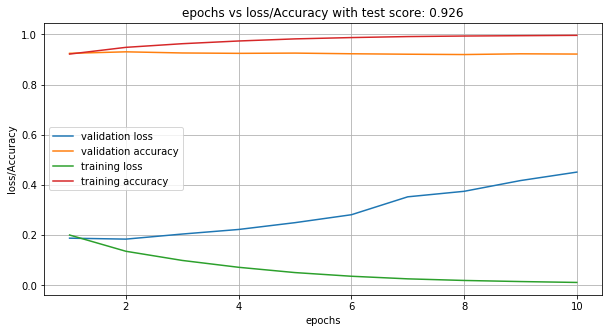

In [35]:
plt.figure(figsize=(10,5))
plt.grid()
plt.plot(range(1,11),history1.history['val_loss'],label="validation loss")
plt.plot(range(1,11),history1.history['val_accuracy'],label="validation accuracy")
plt.plot(range(1,11),history1.history['loss'],label="training loss")
plt.plot(range(1,11),history1.history['accuracy'],label="training accuracy")
plt.legend()
plt.ylabel("loss/Accuracy")
plt.xlabel("epochs")
plt.title("epochs vs loss/Accuracy with test score: "+str(np.round(scores1[1],3)))
plt.show()

In [42]:
#model with 2 LSTM layers
model2 = keras.models.Sequential()
model2.add(keras.layers.embeddings.Embedding(len(frequencySortedWords)+1,
                                             embedding_vecor_length,
                                             input_length=max_review_length))
model2.add(keras.layers.LSTM(100, return_sequences=True))
model2.add(keras.layers.LSTM(50))
model2.add(keras.layers.Dense(1, activation='tanh'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1600, 128)         7437824   
_________________________________________________________________
lstm_8 (LSTM)                (None, 1600, 100)         91600     
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 7,559,675
Trainable params: 7,559,675
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
history2 = model2.fit(x=x_train,
                    y=y_train,
                    batch_size=128,
                    epochs=10,
                    verbose=1,
                    validation_split=0.2, #spliting 20% train data for validation
                    workers=-1,
                    use_multiprocessing=True)
# Final evaluation of the model
scores2 = model2.evaluate(x_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores2[1]*100))

Train on 203935 samples, validate on 50984 samples
Epoch 1/10


 21632/203935 [==>...........................] - ETA: 1:15:56 - loss: 7.5336 - accuracy: 0.109 - ETA: 1:10:08 - loss: 5.1537 - accuracy: 0.148 - ETA: 1:08:09 - loss: 4.2667 - accuracy: 0.132 - ETA: 1:07:00 - loss: 3.7252 - accuracy: 0.132 - ETA: 1:05:37 - loss: 3.3221 - accuracy: 0.143 - ETA: 1:05:49 - loss: 3.0220 - accuracy: 0.139 - ETA: 1:06:19 - loss: 2.7584 - accuracy: 0.147 - ETA: 1:09:56 - loss: 2.5316 - accuracy: 0.178 - ETA: 1:13:09 - loss: 2.3225 - accuracy: 0.226 - ETA: 1:15:31 - loss: 2.1400 - accuracy: 0.280 - ETA: 1:17:31 - loss: 1.9861 - accuracy: 0.333 - ETA: 1:19:06 - loss: 1.8701 - accuracy: 0.375 - ETA: 1:20:33 - loss: 1.7699 - accuracy: 0.412 - ETA: 1:21:49 - loss: 1.6914 - accuracy: 0.442 - ETA: 1:22:54 - loss: 1.6148 - accuracy: 0.469 - ETA: 1:23:56 - loss: 1.5404 - accuracy: 0.495 - ETA: 1:24:07 - loss: 1.4789 - accuracy: 0.515 - ETA: 1:22:46 - loss: 1.4212 - accuracy: 0.533 - ETA: 1:21:31 - loss: 1.3666 - accuracy: 0.551 - ETA: 1:22:23 - loss: 1.3181 - accuracy:

 65152/203935 [========>.....................] - ETA: 1:14:00 - loss: 0.4140 - accuracy: 0.850 - ETA: 1:13:57 - loss: 0.4135 - accuracy: 0.850 - ETA: 1:13:55 - loss: 0.4132 - accuracy: 0.850 - ETA: 1:13:52 - loss: 0.4127 - accuracy: 0.851 - ETA: 1:13:49 - loss: 0.4122 - accuracy: 0.851 - ETA: 1:13:46 - loss: 0.4116 - accuracy: 0.851 - ETA: 1:13:44 - loss: 0.4111 - accuracy: 0.851 - ETA: 1:13:41 - loss: 0.4105 - accuracy: 0.851 - ETA: 1:13:39 - loss: 0.4099 - accuracy: 0.851 - ETA: 1:13:34 - loss: 0.4096 - accuracy: 0.852 - ETA: 1:13:26 - loss: 0.4091 - accuracy: 0.852 - ETA: 1:13:19 - loss: 0.4089 - accuracy: 0.852 - ETA: 1:13:16 - loss: 0.4087 - accuracy: 0.852 - ETA: 1:13:14 - loss: 0.4082 - accuracy: 0.852 - ETA: 1:13:11 - loss: 0.4080 - accuracy: 0.852 - ETA: 1:13:08 - loss: 0.4075 - accuracy: 0.852 - ETA: 1:13:06 - loss: 0.4072 - accuracy: 0.852 - ETA: 1:13:03 - loss: 0.4069 - accuracy: 0.852 - ETA: 1:13:00 - loss: 0.4066 - accuracy: 0.852 - ETA: 1:12:58 - loss: 0.4060 - accuracy:

 87424/203935 [===========>..................] - ETA: 1:04:06 - loss: 0.3690 - accuracy: 0.862 - ETA: 1:04:03 - loss: 0.3687 - accuracy: 0.862 - ETA: 1:03:59 - loss: 0.3685 - accuracy: 0.862 - ETA: 1:03:56 - loss: 0.3682 - accuracy: 0.863 - ETA: 1:03:53 - loss: 0.3679 - accuracy: 0.863 - ETA: 1:03:50 - loss: 0.3675 - accuracy: 0.863 - ETA: 1:03:47 - loss: 0.3672 - accuracy: 0.863 - ETA: 1:03:44 - loss: 0.3669 - accuracy: 0.863 - ETA: 1:03:41 - loss: 0.3667 - accuracy: 0.863 - ETA: 1:03:35 - loss: 0.3664 - accuracy: 0.863 - ETA: 1:03:29 - loss: 0.3662 - accuracy: 0.863 - ETA: 1:03:25 - loss: 0.3659 - accuracy: 0.863 - ETA: 1:03:22 - loss: 0.3656 - accuracy: 0.863 - ETA: 1:03:18 - loss: 0.3653 - accuracy: 0.863 - ETA: 1:03:15 - loss: 0.3650 - accuracy: 0.864 - ETA: 1:03:12 - loss: 0.3646 - accuracy: 0.864 - ETA: 1:03:09 - loss: 0.3645 - accuracy: 0.864 - ETA: 1:03:06 - loss: 0.3641 - accuracy: 0.864 - ETA: 1:03:03 - loss: 0.3638 - accuracy: 0.864 - ETA: 1:03:00 - loss: 0.3635 - accuracy:

110208/203935 [===============>..............] - ETA: 53:52 - loss: 0.3295 - accuracy: 0.876 - ETA: 53:48 - loss: 0.3292 - accuracy: 0.876 - ETA: 53:45 - loss: 0.3291 - accuracy: 0.876 - ETA: 53:42 - loss: 0.3289 - accuracy: 0.876 - ETA: 53:39 - loss: 0.3288 - accuracy: 0.876 - ETA: 53:35 - loss: 0.3286 - accuracy: 0.876 - ETA: 53:32 - loss: 0.3284 - accuracy: 0.876 - ETA: 53:28 - loss: 0.3283 - accuracy: 0.876 - ETA: 53:23 - loss: 0.3281 - accuracy: 0.876 - ETA: 53:18 - loss: 0.3280 - accuracy: 0.876 - ETA: 53:15 - loss: 0.3279 - accuracy: 0.876 - ETA: 53:11 - loss: 0.3278 - accuracy: 0.876 - ETA: 53:08 - loss: 0.3277 - accuracy: 0.876 - ETA: 53:05 - loss: 0.3275 - accuracy: 0.876 - ETA: 53:01 - loss: 0.3273 - accuracy: 0.876 - ETA: 52:58 - loss: 0.3271 - accuracy: 0.877 - ETA: 52:55 - loss: 0.3269 - accuracy: 0.877 - ETA: 52:52 - loss: 0.3267 - accuracy: 0.877 - ETA: 52:48 - loss: 0.3264 - accuracy: 0.877 - ETA: 52:45 - loss: 0.3261 - accuracy: 0.877 - ETA: 52:42 - loss: 0.3260 - acc

132992/203935 [==================>...........] - ETA: 43:21 - loss: 0.3029 - accuracy: 0.886 - ETA: 43:16 - loss: 0.3027 - accuracy: 0.886 - ETA: 43:12 - loss: 0.3025 - accuracy: 0.886 - ETA: 43:08 - loss: 0.3024 - accuracy: 0.886 - ETA: 43:05 - loss: 0.3023 - accuracy: 0.886 - ETA: 43:02 - loss: 0.3022 - accuracy: 0.886 - ETA: 42:58 - loss: 0.3020 - accuracy: 0.886 - ETA: 42:55 - loss: 0.3018 - accuracy: 0.886 - ETA: 42:52 - loss: 0.3017 - accuracy: 0.886 - ETA: 42:48 - loss: 0.3015 - accuracy: 0.886 - ETA: 42:45 - loss: 0.3014 - accuracy: 0.886 - ETA: 42:41 - loss: 0.3012 - accuracy: 0.886 - ETA: 42:38 - loss: 0.3011 - accuracy: 0.886 - ETA: 42:35 - loss: 0.3010 - accuracy: 0.886 - ETA: 42:31 - loss: 0.3009 - accuracy: 0.886 - ETA: 42:27 - loss: 0.3008 - accuracy: 0.886 - ETA: 42:23 - loss: 0.3008 - accuracy: 0.886 - ETA: 42:18 - loss: 0.3007 - accuracy: 0.886 - ETA: 42:15 - loss: 0.3006 - accuracy: 0.886 - ETA: 42:12 - loss: 0.3005 - accuracy: 0.886 - ETA: 42:08 - loss: 0.3003 - acc

155776/203935 [=====================>........] - ETA: 32:48 - loss: 0.2846 - accuracy: 0.892 - ETA: 32:45 - loss: 0.2845 - accuracy: 0.892 - ETA: 32:42 - loss: 0.2845 - accuracy: 0.892 - ETA: 32:38 - loss: 0.2844 - accuracy: 0.892 - ETA: 32:33 - loss: 0.2844 - accuracy: 0.892 - ETA: 32:30 - loss: 0.2843 - accuracy: 0.892 - ETA: 32:26 - loss: 0.2842 - accuracy: 0.892 - ETA: 32:23 - loss: 0.2841 - accuracy: 0.892 - ETA: 32:19 - loss: 0.2840 - accuracy: 0.892 - ETA: 32:16 - loss: 0.2838 - accuracy: 0.892 - ETA: 32:12 - loss: 0.2838 - accuracy: 0.893 - ETA: 32:09 - loss: 0.2837 - accuracy: 0.893 - ETA: 32:05 - loss: 0.2836 - accuracy: 0.893 - ETA: 32:02 - loss: 0.2835 - accuracy: 0.893 - ETA: 31:58 - loss: 0.2835 - accuracy: 0.893 - ETA: 31:55 - loss: 0.2835 - accuracy: 0.893 - ETA: 31:51 - loss: 0.2835 - accuracy: 0.893 - ETA: 31:47 - loss: 0.2834 - accuracy: 0.893 - ETA: 31:43 - loss: 0.2833 - accuracy: 0.893 - ETA: 31:40 - loss: 0.2832 - accuracy: 0.893 - ETA: 31:37 - loss: 0.2831 - acc

178560/203935 [=========================>....] - ETA: 22:15 - loss: 0.2713 - accuracy: 0.897 - ETA: 22:11 - loss: 0.2711 - accuracy: 0.897 - ETA: 22:07 - loss: 0.2710 - accuracy: 0.897 - ETA: 22:04 - loss: 0.2710 - accuracy: 0.897 - ETA: 22:01 - loss: 0.2710 - accuracy: 0.897 - ETA: 21:57 - loss: 0.2709 - accuracy: 0.897 - ETA: 21:54 - loss: 0.2707 - accuracy: 0.897 - ETA: 21:50 - loss: 0.2707 - accuracy: 0.897 - ETA: 21:47 - loss: 0.2706 - accuracy: 0.897 - ETA: 21:43 - loss: 0.2706 - accuracy: 0.897 - ETA: 21:40 - loss: 0.2705 - accuracy: 0.897 - ETA: 21:36 - loss: 0.2705 - accuracy: 0.897 - ETA: 21:32 - loss: 0.2704 - accuracy: 0.897 - ETA: 21:28 - loss: 0.2703 - accuracy: 0.897 - ETA: 21:25 - loss: 0.2702 - accuracy: 0.897 - ETA: 21:21 - loss: 0.2702 - accuracy: 0.898 - ETA: 21:18 - loss: 0.2701 - accuracy: 0.898 - ETA: 21:14 - loss: 0.2700 - accuracy: 0.898 - ETA: 21:11 - loss: 0.2700 - accuracy: 0.898 - ETA: 21:07 - loss: 0.2699 - accuracy: 0.898 - ETA: 21:04 - loss: 0.2698 - acc

202112/203935 [============================>.] - ETA: 11:42 - loss: 0.2608 - accuracy: 0.901 - ETA: 11:38 - loss: 0.2607 - accuracy: 0.901 - ETA: 11:35 - loss: 0.2607 - accuracy: 0.901 - ETA: 11:31 - loss: 0.2607 - accuracy: 0.901 - ETA: 11:28 - loss: 0.2606 - accuracy: 0.901 - ETA: 11:24 - loss: 0.2605 - accuracy: 0.901 - ETA: 11:20 - loss: 0.2605 - accuracy: 0.901 - ETA: 11:17 - loss: 0.2604 - accuracy: 0.901 - ETA: 11:13 - loss: 0.2603 - accuracy: 0.901 - ETA: 11:09 - loss: 0.2603 - accuracy: 0.901 - ETA: 11:06 - loss: 0.2602 - accuracy: 0.901 - ETA: 11:02 - loss: 0.2601 - accuracy: 0.901 - ETA: 10:59 - loss: 0.2601 - accuracy: 0.901 - ETA: 10:55 - loss: 0.2600 - accuracy: 0.901 - ETA: 10:52 - loss: 0.2600 - accuracy: 0.901 - ETA: 10:48 - loss: 0.2600 - accuracy: 0.901 - ETA: 10:45 - loss: 0.2599 - accuracy: 0.901 - ETA: 10:41 - loss: 0.2598 - accuracy: 0.901 - ETA: 10:38 - loss: 0.2598 - accuracy: 0.901 - ETA: 10:34 - loss: 0.2597 - accuracy: 0.901 - ETA: 10:31 - loss: 0.2597 - acc

203935/203935 [==============================] - ETA: 47s - loss: 0.2517 - accuracy: 0.904 - ETA: 43s - loss: 0.2517 - accuracy: 0.904 - ETA: 40s - loss: 0.2517 - accuracy: 0.904 - ETA: 36s - loss: 0.2517 - accuracy: 0.904 - ETA: 32s - loss: 0.2517 - accuracy: 0.904 - ETA: 29s - loss: 0.2516 - accuracy: 0.904 - ETA: 25s - loss: 0.2516 - accuracy: 0.904 - ETA: 22s - loss: 0.2515 - accuracy: 0.904 - ETA: 18s - loss: 0.2515 - accuracy: 0.904 - ETA: 15s - loss: 0.2514 - accuracy: 0.904 - ETA: 11s - loss: 0.2514 - accuracy: 0.904 - ETA: 7s - loss: 0.2513 - accuracy: 0.904 - ETA: 4s - loss: 0.2513 - accuracy: 0.90 - ETA: 0s - loss: 0.2513 - accuracy: 0.90 - 6420s 31ms/step - loss: 0.2512 - accuracy: 0.9046 - val_loss: 0.1967 - val_accuracy: 0.9235
Epoch 2/10


 21760/203935 [==>...........................] - ETA: 1:40:39 - loss: 0.1659 - accuracy: 0.914 - ETA: 1:41:26 - loss: 0.1424 - accuracy: 0.941 - ETA: 1:41:08 - loss: 0.1604 - accuracy: 0.934 - ETA: 1:40:48 - loss: 0.1540 - accuracy: 0.943 - ETA: 1:39:58 - loss: 0.1512 - accuracy: 0.943 - ETA: 1:40:01 - loss: 0.1674 - accuracy: 0.938 - ETA: 1:39:53 - loss: 0.1570 - accuracy: 0.942 - ETA: 1:39:50 - loss: 0.1504 - accuracy: 0.943 - ETA: 1:39:43 - loss: 0.1465 - accuracy: 0.943 - ETA: 1:39:42 - loss: 0.1437 - accuracy: 0.945 - ETA: 1:39:50 - loss: 0.1422 - accuracy: 0.946 - ETA: 1:39:46 - loss: 0.1446 - accuracy: 0.946 - ETA: 1:39:38 - loss: 0.1432 - accuracy: 0.945 - ETA: 1:39:39 - loss: 0.1402 - accuracy: 0.945 - ETA: 1:38:35 - loss: 0.1383 - accuracy: 0.946 - ETA: 1:36:10 - loss: 0.1475 - accuracy: 0.944 - ETA: 1:35:38 - loss: 0.1493 - accuracy: 0.943 - ETA: 1:35:45 - loss: 0.1467 - accuracy: 0.945 - ETA: 1:35:50 - loss: 0.1465 - accuracy: 0.945 - ETA: 1:36:05 - loss: 0.1496 - accuracy:

 65280/203935 [========>.....................] - ETA: 1:14:27 - loss: 0.1481 - accuracy: 0.944 - ETA: 1:14:20 - loss: 0.1481 - accuracy: 0.944 - ETA: 1:14:17 - loss: 0.1480 - accuracy: 0.944 - ETA: 1:14:14 - loss: 0.1481 - accuracy: 0.944 - ETA: 1:14:11 - loss: 0.1483 - accuracy: 0.944 - ETA: 1:14:08 - loss: 0.1483 - accuracy: 0.944 - ETA: 1:14:06 - loss: 0.1482 - accuracy: 0.944 - ETA: 1:14:03 - loss: 0.1483 - accuracy: 0.944 - ETA: 1:14:00 - loss: 0.1485 - accuracy: 0.944 - ETA: 1:13:58 - loss: 0.1486 - accuracy: 0.944 - ETA: 1:13:55 - loss: 0.1485 - accuracy: 0.944 - ETA: 1:13:52 - loss: 0.1486 - accuracy: 0.944 - ETA: 1:13:49 - loss: 0.1486 - accuracy: 0.944 - ETA: 1:13:44 - loss: 0.1488 - accuracy: 0.944 - ETA: 1:13:36 - loss: 0.1489 - accuracy: 0.944 - ETA: 1:13:30 - loss: 0.1488 - accuracy: 0.944 - ETA: 1:13:27 - loss: 0.1491 - accuracy: 0.944 - ETA: 1:13:24 - loss: 0.1492 - accuracy: 0.944 - ETA: 1:13:21 - loss: 0.1491 - accuracy: 0.944 - ETA: 1:13:18 - loss: 0.1489 - accuracy:

 87552/203935 [===========>..................] - ETA: 1:04:12 - loss: 0.1485 - accuracy: 0.944 - ETA: 1:04:09 - loss: 0.1485 - accuracy: 0.945 - ETA: 1:04:06 - loss: 0.1486 - accuracy: 0.944 - ETA: 1:04:03 - loss: 0.1485 - accuracy: 0.944 - ETA: 1:04:00 - loss: 0.1486 - accuracy: 0.944 - ETA: 1:03:57 - loss: 0.1486 - accuracy: 0.944 - ETA: 1:03:54 - loss: 0.1488 - accuracy: 0.944 - ETA: 1:03:51 - loss: 0.1489 - accuracy: 0.944 - ETA: 1:03:48 - loss: 0.1489 - accuracy: 0.944 - ETA: 1:03:44 - loss: 0.1490 - accuracy: 0.944 - ETA: 1:03:41 - loss: 0.1489 - accuracy: 0.944 - ETA: 1:03:38 - loss: 0.1490 - accuracy: 0.944 - ETA: 1:03:34 - loss: 0.1491 - accuracy: 0.944 - ETA: 1:03:27 - loss: 0.1491 - accuracy: 0.944 - ETA: 1:03:22 - loss: 0.1490 - accuracy: 0.944 - ETA: 1:03:19 - loss: 0.1491 - accuracy: 0.944 - ETA: 1:03:16 - loss: 0.1491 - accuracy: 0.944 - ETA: 1:03:13 - loss: 0.1490 - accuracy: 0.944 - ETA: 1:03:10 - loss: 0.1491 - accuracy: 0.944 - ETA: 1:03:07 - loss: 0.1491 - accuracy:

110336/203935 [===============>..............] - ETA: 54:00 - loss: 0.1523 - accuracy: 0.943 - ETA: 53:55 - loss: 0.1522 - accuracy: 0.943 - ETA: 53:50 - loss: 0.1522 - accuracy: 0.943 - ETA: 53:45 - loss: 0.1523 - accuracy: 0.943 - ETA: 53:42 - loss: 0.1522 - accuracy: 0.943 - ETA: 53:39 - loss: 0.1521 - accuracy: 0.943 - ETA: 53:36 - loss: 0.1520 - accuracy: 0.943 - ETA: 53:32 - loss: 0.1519 - accuracy: 0.943 - ETA: 53:29 - loss: 0.1521 - accuracy: 0.943 - ETA: 53:26 - loss: 0.1521 - accuracy: 0.943 - ETA: 53:22 - loss: 0.1523 - accuracy: 0.943 - ETA: 53:19 - loss: 0.1525 - accuracy: 0.943 - ETA: 53:16 - loss: 0.1525 - accuracy: 0.943 - ETA: 53:12 - loss: 0.1526 - accuracy: 0.943 - ETA: 53:09 - loss: 0.1526 - accuracy: 0.943 - ETA: 53:06 - loss: 0.1525 - accuracy: 0.943 - ETA: 53:02 - loss: 0.1529 - accuracy: 0.943 - ETA: 52:59 - loss: 0.1529 - accuracy: 0.943 - ETA: 52:56 - loss: 0.1527 - accuracy: 0.943 - ETA: 52:52 - loss: 0.1527 - accuracy: 0.944 - ETA: 52:47 - loss: 0.1528 - acc

133120/203935 [==================>...........] - ETA: 43:24 - loss: 0.1568 - accuracy: 0.943 - ETA: 43:20 - loss: 0.1568 - accuracy: 0.943 - ETA: 43:17 - loss: 0.1568 - accuracy: 0.943 - ETA: 43:14 - loss: 0.1568 - accuracy: 0.943 - ETA: 43:10 - loss: 0.1568 - accuracy: 0.943 - ETA: 43:07 - loss: 0.1568 - accuracy: 0.943 - ETA: 43:03 - loss: 0.1568 - accuracy: 0.942 - ETA: 43:00 - loss: 0.1568 - accuracy: 0.943 - ETA: 42:56 - loss: 0.1567 - accuracy: 0.942 - ETA: 42:51 - loss: 0.1568 - accuracy: 0.942 - ETA: 42:47 - loss: 0.1567 - accuracy: 0.943 - ETA: 42:44 - loss: 0.1567 - accuracy: 0.943 - ETA: 42:41 - loss: 0.1566 - accuracy: 0.943 - ETA: 42:37 - loss: 0.1566 - accuracy: 0.942 - ETA: 42:34 - loss: 0.1567 - accuracy: 0.942 - ETA: 42:30 - loss: 0.1566 - accuracy: 0.942 - ETA: 42:27 - loss: 0.1566 - accuracy: 0.942 - ETA: 42:24 - loss: 0.1566 - accuracy: 0.942 - ETA: 42:20 - loss: 0.1567 - accuracy: 0.942 - ETA: 42:17 - loss: 0.1566 - accuracy: 0.942 - ETA: 42:13 - loss: 0.1566 - acc

155904/203935 [=====================>........] - ETA: 32:48 - loss: 0.1557 - accuracy: 0.942 - ETA: 32:45 - loss: 0.1557 - accuracy: 0.942 - ETA: 32:41 - loss: 0.1557 - accuracy: 0.942 - ETA: 32:38 - loss: 0.1557 - accuracy: 0.942 - ETA: 32:34 - loss: 0.1557 - accuracy: 0.942 - ETA: 32:30 - loss: 0.1557 - accuracy: 0.942 - ETA: 32:26 - loss: 0.1557 - accuracy: 0.942 - ETA: 32:22 - loss: 0.1557 - accuracy: 0.942 - ETA: 32:19 - loss: 0.1557 - accuracy: 0.942 - ETA: 32:15 - loss: 0.1556 - accuracy: 0.942 - ETA: 32:12 - loss: 0.1556 - accuracy: 0.942 - ETA: 32:08 - loss: 0.1556 - accuracy: 0.942 - ETA: 32:05 - loss: 0.1555 - accuracy: 0.942 - ETA: 32:01 - loss: 0.1555 - accuracy: 0.942 - ETA: 31:58 - loss: 0.1555 - accuracy: 0.942 - ETA: 31:55 - loss: 0.1555 - accuracy: 0.942 - ETA: 31:51 - loss: 0.1555 - accuracy: 0.942 - ETA: 31:48 - loss: 0.1555 - accuracy: 0.942 - ETA: 31:44 - loss: 0.1555 - accuracy: 0.942 - ETA: 31:41 - loss: 0.1555 - accuracy: 0.942 - ETA: 31:36 - loss: 0.1554 - acc

178688/203935 [=========================>....] - ETA: 22:13 - loss: 0.1561 - accuracy: 0.942 - ETA: 22:10 - loss: 0.1561 - accuracy: 0.942 - ETA: 22:06 - loss: 0.1560 - accuracy: 0.942 - ETA: 22:03 - loss: 0.1560 - accuracy: 0.942 - ETA: 21:59 - loss: 0.1560 - accuracy: 0.942 - ETA: 21:55 - loss: 0.1559 - accuracy: 0.942 - ETA: 21:51 - loss: 0.1560 - accuracy: 0.942 - ETA: 21:48 - loss: 0.1560 - accuracy: 0.942 - ETA: 21:45 - loss: 0.1560 - accuracy: 0.942 - ETA: 21:41 - loss: 0.1560 - accuracy: 0.942 - ETA: 21:38 - loss: 0.1561 - accuracy: 0.942 - ETA: 21:34 - loss: 0.1561 - accuracy: 0.942 - ETA: 21:30 - loss: 0.1561 - accuracy: 0.942 - ETA: 21:27 - loss: 0.1561 - accuracy: 0.942 - ETA: 21:23 - loss: 0.1561 - accuracy: 0.942 - ETA: 21:20 - loss: 0.1561 - accuracy: 0.942 - ETA: 21:16 - loss: 0.1561 - accuracy: 0.942 - ETA: 21:13 - loss: 0.1561 - accuracy: 0.942 - ETA: 21:09 - loss: 0.1561 - accuracy: 0.942 - ETA: 21:05 - loss: 0.1561 - accuracy: 0.942 - ETA: 21:02 - loss: 0.1561 - acc

202240/203935 [============================>.] - ETA: 11:38 - loss: 0.1566 - accuracy: 0.942 - ETA: 11:35 - loss: 0.1566 - accuracy: 0.942 - ETA: 11:31 - loss: 0.1566 - accuracy: 0.942 - ETA: 11:28 - loss: 0.1566 - accuracy: 0.942 - ETA: 11:24 - loss: 0.1566 - accuracy: 0.942 - ETA: 11:21 - loss: 0.1566 - accuracy: 0.942 - ETA: 11:17 - loss: 0.1565 - accuracy: 0.942 - ETA: 11:14 - loss: 0.1565 - accuracy: 0.942 - ETA: 11:10 - loss: 0.1565 - accuracy: 0.942 - ETA: 11:07 - loss: 0.1564 - accuracy: 0.942 - ETA: 11:03 - loss: 0.1564 - accuracy: 0.942 - ETA: 10:59 - loss: 0.1564 - accuracy: 0.942 - ETA: 10:56 - loss: 0.1564 - accuracy: 0.942 - ETA: 10:52 - loss: 0.1564 - accuracy: 0.942 - ETA: 10:49 - loss: 0.1565 - accuracy: 0.942 - ETA: 10:45 - loss: 0.1565 - accuracy: 0.942 - ETA: 10:42 - loss: 0.1565 - accuracy: 0.942 - ETA: 10:38 - loss: 0.1565 - accuracy: 0.942 - ETA: 10:34 - loss: 0.1565 - accuracy: 0.942 - ETA: 10:31 - loss: 0.1565 - accuracy: 0.942 - ETA: 10:27 - loss: 0.1564 - acc

203935/203935 [==============================] - ETA: 43s - loss: 0.1563 - accuracy: 0.942 - ETA: 40s - loss: 0.1563 - accuracy: 0.942 - ETA: 36s - loss: 0.1563 - accuracy: 0.942 - ETA: 32s - loss: 0.1563 - accuracy: 0.942 - ETA: 29s - loss: 0.1563 - accuracy: 0.942 - ETA: 25s - loss: 0.1563 - accuracy: 0.942 - ETA: 22s - loss: 0.1563 - accuracy: 0.942 - ETA: 18s - loss: 0.1563 - accuracy: 0.942 - ETA: 15s - loss: 0.1563 - accuracy: 0.942 - ETA: 11s - loss: 0.1563 - accuracy: 0.942 - ETA: 7s - loss: 0.1563 - accuracy: 0.942 - ETA: 4s - loss: 0.1563 - accuracy: 0.94 - ETA: 0s - loss: 0.1563 - accuracy: 0.94 - 6423s 31ms/step - loss: 0.1563 - accuracy: 0.9421 - val_loss: 0.2127 - val_accuracy: 0.9258
Epoch 3/10


 21760/203935 [==>...........................] - ETA: 1:43:46 - loss: 0.0671 - accuracy: 0.976 - ETA: 1:42:37 - loss: 0.0986 - accuracy: 0.960 - ETA: 1:42:26 - loss: 0.0799 - accuracy: 0.974 - ETA: 1:41:53 - loss: 0.0880 - accuracy: 0.970 - ETA: 1:41:35 - loss: 0.0963 - accuracy: 0.964 - ETA: 1:41:37 - loss: 0.0972 - accuracy: 0.962 - ETA: 1:41:28 - loss: 0.1019 - accuracy: 0.959 - ETA: 1:41:02 - loss: 0.1089 - accuracy: 0.956 - ETA: 1:41:00 - loss: 0.1078 - accuracy: 0.956 - ETA: 1:40:46 - loss: 0.1186 - accuracy: 0.956 - ETA: 1:40:31 - loss: 0.1229 - accuracy: 0.956 - ETA: 1:40:20 - loss: 0.1209 - accuracy: 0.957 - ETA: 1:40:07 - loss: 0.1176 - accuracy: 0.956 - ETA: 1:40:00 - loss: 0.1146 - accuracy: 0.956 - ETA: 1:39:52 - loss: 0.1176 - accuracy: 0.955 - ETA: 1:38:20 - loss: 0.1171 - accuracy: 0.956 - ETA: 1:36:03 - loss: 0.1150 - accuracy: 0.957 - ETA: 1:34:46 - loss: 0.1160 - accuracy: 0.957 - ETA: 1:34:54 - loss: 0.1149 - accuracy: 0.957 - ETA: 1:34:59 - loss: 0.1192 - accuracy:

 65280/203935 [========>.....................] - ETA: 1:14:17 - loss: 0.1292 - accuracy: 0.955 - ETA: 1:14:14 - loss: 0.1291 - accuracy: 0.955 - ETA: 1:14:12 - loss: 0.1290 - accuracy: 0.956 - ETA: 1:14:09 - loss: 0.1290 - accuracy: 0.956 - ETA: 1:14:06 - loss: 0.1289 - accuracy: 0.956 - ETA: 1:14:03 - loss: 0.1289 - accuracy: 0.956 - ETA: 1:14:00 - loss: 0.1291 - accuracy: 0.956 - ETA: 1:13:57 - loss: 0.1293 - accuracy: 0.955 - ETA: 1:13:55 - loss: 0.1293 - accuracy: 0.955 - ETA: 1:13:52 - loss: 0.1293 - accuracy: 0.955 - ETA: 1:13:46 - loss: 0.1292 - accuracy: 0.955 - ETA: 1:13:38 - loss: 0.1292 - accuracy: 0.955 - ETA: 1:13:31 - loss: 0.1290 - accuracy: 0.955 - ETA: 1:13:29 - loss: 0.1287 - accuracy: 0.956 - ETA: 1:13:26 - loss: 0.1286 - accuracy: 0.956 - ETA: 1:13:23 - loss: 0.1286 - accuracy: 0.956 - ETA: 1:13:21 - loss: 0.1284 - accuracy: 0.956 - ETA: 1:13:18 - loss: 0.1284 - accuracy: 0.956 - ETA: 1:13:15 - loss: 0.1287 - accuracy: 0.956 - ETA: 1:13:13 - loss: 0.1285 - accuracy:

 87552/203935 [===========>..................] - ETA: 1:04:09 - loss: 0.1271 - accuracy: 0.956 - ETA: 1:04:06 - loss: 0.1273 - accuracy: 0.956 - ETA: 1:04:02 - loss: 0.1272 - accuracy: 0.956 - ETA: 1:03:59 - loss: 0.1272 - accuracy: 0.956 - ETA: 1:03:56 - loss: 0.1271 - accuracy: 0.956 - ETA: 1:03:53 - loss: 0.1271 - accuracy: 0.956 - ETA: 1:03:50 - loss: 0.1270 - accuracy: 0.956 - ETA: 1:03:47 - loss: 0.1272 - accuracy: 0.956 - ETA: 1:03:44 - loss: 0.1271 - accuracy: 0.956 - ETA: 1:03:41 - loss: 0.1271 - accuracy: 0.956 - ETA: 1:03:38 - loss: 0.1271 - accuracy: 0.956 - ETA: 1:03:33 - loss: 0.1271 - accuracy: 0.956 - ETA: 1:03:27 - loss: 0.1270 - accuracy: 0.956 - ETA: 1:03:22 - loss: 0.1269 - accuracy: 0.956 - ETA: 1:03:19 - loss: 0.1268 - accuracy: 0.956 - ETA: 1:03:16 - loss: 0.1269 - accuracy: 0.956 - ETA: 1:03:12 - loss: 0.1269 - accuracy: 0.956 - ETA: 1:03:09 - loss: 0.1268 - accuracy: 0.956 - ETA: 1:03:06 - loss: 0.1268 - accuracy: 0.956 - ETA: 1:03:03 - loss: 0.1267 - accuracy:

110336/203935 [===============>..............] - ETA: 53:50 - loss: 0.1288 - accuracy: 0.955 - ETA: 53:47 - loss: 0.1288 - accuracy: 0.955 - ETA: 53:44 - loss: 0.1288 - accuracy: 0.955 - ETA: 53:40 - loss: 0.1287 - accuracy: 0.955 - ETA: 53:37 - loss: 0.1287 - accuracy: 0.955 - ETA: 53:33 - loss: 0.1286 - accuracy: 0.955 - ETA: 53:28 - loss: 0.1286 - accuracy: 0.955 - ETA: 53:23 - loss: 0.1286 - accuracy: 0.955 - ETA: 53:19 - loss: 0.1288 - accuracy: 0.955 - ETA: 53:16 - loss: 0.1287 - accuracy: 0.955 - ETA: 53:13 - loss: 0.1287 - accuracy: 0.955 - ETA: 53:10 - loss: 0.1288 - accuracy: 0.955 - ETA: 53:06 - loss: 0.1289 - accuracy: 0.955 - ETA: 53:03 - loss: 0.1289 - accuracy: 0.955 - ETA: 53:00 - loss: 0.1289 - accuracy: 0.955 - ETA: 52:57 - loss: 0.1291 - accuracy: 0.955 - ETA: 52:53 - loss: 0.1290 - accuracy: 0.955 - ETA: 52:50 - loss: 0.1290 - accuracy: 0.955 - ETA: 52:47 - loss: 0.1291 - accuracy: 0.955 - ETA: 52:44 - loss: 0.1292 - accuracy: 0.955 - ETA: 52:41 - loss: 0.1292 - acc

133120/203935 [==================>...........] - ETA: 43:16 - loss: 0.1295 - accuracy: 0.954 - ETA: 43:12 - loss: 0.1294 - accuracy: 0.954 - ETA: 43:08 - loss: 0.1295 - accuracy: 0.954 - ETA: 43:05 - loss: 0.1296 - accuracy: 0.954 - ETA: 43:02 - loss: 0.1296 - accuracy: 0.954 - ETA: 42:58 - loss: 0.1295 - accuracy: 0.954 - ETA: 42:55 - loss: 0.1297 - accuracy: 0.954 - ETA: 42:52 - loss: 0.1296 - accuracy: 0.954 - ETA: 42:48 - loss: 0.1295 - accuracy: 0.954 - ETA: 42:45 - loss: 0.1295 - accuracy: 0.954 - ETA: 42:41 - loss: 0.1295 - accuracy: 0.954 - ETA: 42:38 - loss: 0.1294 - accuracy: 0.954 - ETA: 42:35 - loss: 0.1295 - accuracy: 0.954 - ETA: 42:31 - loss: 0.1295 - accuracy: 0.954 - ETA: 42:28 - loss: 0.1294 - accuracy: 0.954 - ETA: 42:24 - loss: 0.1294 - accuracy: 0.954 - ETA: 42:21 - loss: 0.1294 - accuracy: 0.954 - ETA: 42:16 - loss: 0.1293 - accuracy: 0.954 - ETA: 42:11 - loss: 0.1294 - accuracy: 0.954 - ETA: 42:08 - loss: 0.1293 - accuracy: 0.954 - ETA: 42:05 - loss: 0.1294 - acc

155904/203935 [=====================>........] - ETA: 32:45 - loss: 0.1381 - accuracy: 0.951 - ETA: 32:42 - loss: 0.1382 - accuracy: 0.951 - ETA: 32:38 - loss: 0.1381 - accuracy: 0.951 - ETA: 32:35 - loss: 0.1383 - accuracy: 0.951 - ETA: 32:32 - loss: 0.1383 - accuracy: 0.951 - ETA: 32:28 - loss: 0.1384 - accuracy: 0.951 - ETA: 32:25 - loss: 0.1385 - accuracy: 0.951 - ETA: 32:21 - loss: 0.1385 - accuracy: 0.951 - ETA: 32:18 - loss: 0.1385 - accuracy: 0.951 - ETA: 32:14 - loss: 0.1385 - accuracy: 0.951 - ETA: 32:11 - loss: 0.1385 - accuracy: 0.951 - ETA: 32:07 - loss: 0.1385 - accuracy: 0.951 - ETA: 32:03 - loss: 0.1385 - accuracy: 0.951 - ETA: 31:59 - loss: 0.1385 - accuracy: 0.951 - ETA: 31:55 - loss: 0.1386 - accuracy: 0.951 - ETA: 31:51 - loss: 0.1385 - accuracy: 0.951 - ETA: 31:48 - loss: 0.1385 - accuracy: 0.951 - ETA: 31:44 - loss: 0.1386 - accuracy: 0.951 - ETA: 31:41 - loss: 0.1386 - accuracy: 0.951 - ETA: 31:37 - loss: 0.1386 - accuracy: 0.951 - ETA: 31:34 - loss: 0.1386 - acc

178688/203935 [=========================>....] - ETA: 22:11 - loss: 0.1399 - accuracy: 0.950 - ETA: 22:08 - loss: 0.1400 - accuracy: 0.950 - ETA: 22:04 - loss: 0.1400 - accuracy: 0.950 - ETA: 22:01 - loss: 0.1400 - accuracy: 0.950 - ETA: 21:57 - loss: 0.1400 - accuracy: 0.950 - ETA: 21:54 - loss: 0.1400 - accuracy: 0.950 - ETA: 21:50 - loss: 0.1400 - accuracy: 0.950 - ETA: 21:47 - loss: 0.1400 - accuracy: 0.950 - ETA: 21:43 - loss: 0.1400 - accuracy: 0.950 - ETA: 21:39 - loss: 0.1401 - accuracy: 0.950 - ETA: 21:36 - loss: 0.1401 - accuracy: 0.950 - ETA: 21:32 - loss: 0.1402 - accuracy: 0.950 - ETA: 21:29 - loss: 0.1405 - accuracy: 0.950 - ETA: 21:25 - loss: 0.1407 - accuracy: 0.950 - ETA: 21:22 - loss: 0.1411 - accuracy: 0.950 - ETA: 21:18 - loss: 0.1416 - accuracy: 0.950 - ETA: 21:15 - loss: 0.1423 - accuracy: 0.950 - ETA: 21:11 - loss: 0.1427 - accuracy: 0.950 - ETA: 21:08 - loss: 0.1429 - accuracy: 0.949 - ETA: 21:04 - loss: 0.1432 - accuracy: 0.949 - ETA: 21:00 - loss: 0.1433 - acc

202240/203935 [============================>.] - ETA: 11:38 - loss: 0.1505 - accuracy: 0.948 - ETA: 11:34 - loss: 0.1505 - accuracy: 0.948 - ETA: 11:31 - loss: 0.1505 - accuracy: 0.948 - ETA: 11:27 - loss: 0.1505 - accuracy: 0.948 - ETA: 11:24 - loss: 0.1505 - accuracy: 0.948 - ETA: 11:20 - loss: 0.1506 - accuracy: 0.948 - ETA: 11:16 - loss: 0.1509 - accuracy: 0.948 - ETA: 11:13 - loss: 0.1510 - accuracy: 0.948 - ETA: 11:09 - loss: 0.1509 - accuracy: 0.948 - ETA: 11:06 - loss: 0.1509 - accuracy: 0.948 - ETA: 11:02 - loss: 0.1510 - accuracy: 0.948 - ETA: 10:59 - loss: 0.1510 - accuracy: 0.948 - ETA: 10:55 - loss: 0.1511 - accuracy: 0.948 - ETA: 10:52 - loss: 0.1511 - accuracy: 0.948 - ETA: 10:48 - loss: 0.1511 - accuracy: 0.948 - ETA: 10:45 - loss: 0.1511 - accuracy: 0.948 - ETA: 10:41 - loss: 0.1511 - accuracy: 0.948 - ETA: 10:38 - loss: 0.1511 - accuracy: 0.948 - ETA: 10:34 - loss: 0.1510 - accuracy: 0.948 - ETA: 10:30 - loss: 0.1510 - accuracy: 0.948 - ETA: 10:27 - loss: 0.1510 - acc

203935/203935 [==============================] - ETA: 43s - loss: 0.1509 - accuracy: 0.947 - ETA: 40s - loss: 0.1509 - accuracy: 0.947 - ETA: 36s - loss: 0.1509 - accuracy: 0.947 - ETA: 32s - loss: 0.1509 - accuracy: 0.947 - ETA: 29s - loss: 0.1510 - accuracy: 0.947 - ETA: 25s - loss: 0.1510 - accuracy: 0.947 - ETA: 22s - loss: 0.1509 - accuracy: 0.947 - ETA: 18s - loss: 0.1509 - accuracy: 0.947 - ETA: 15s - loss: 0.1510 - accuracy: 0.947 - ETA: 11s - loss: 0.1509 - accuracy: 0.947 - ETA: 7s - loss: 0.1510 - accuracy: 0.947 - ETA: 4s - loss: 0.1510 - accuracy: 0.94 - ETA: 0s - loss: 0.1510 - accuracy: 0.94 - 6413s 31ms/step - loss: 0.1510 - accuracy: 0.9479 - val_loss: 0.2055 - val_accuracy: 0.9244
Epoch 4/10


 21760/203935 [==>...........................] - ETA: 1:14:21 - loss: 0.1616 - accuracy: 0.929 - ETA: 1:26:59 - loss: 0.1163 - accuracy: 0.949 - ETA: 1:31:46 - loss: 0.1185 - accuracy: 0.953 - ETA: 1:35:08 - loss: 0.1085 - accuracy: 0.959 - ETA: 1:36:15 - loss: 0.1046 - accuracy: 0.962 - ETA: 1:37:27 - loss: 0.1037 - accuracy: 0.963 - ETA: 1:37:52 - loss: 0.1088 - accuracy: 0.962 - ETA: 1:37:50 - loss: 0.1237 - accuracy: 0.962 - ETA: 1:38:05 - loss: 0.1255 - accuracy: 0.962 - ETA: 1:37:58 - loss: 0.1235 - accuracy: 0.962 - ETA: 1:38:09 - loss: 0.1200 - accuracy: 0.964 - ETA: 1:38:04 - loss: 0.1193 - accuracy: 0.963 - ETA: 1:38:09 - loss: 0.1245 - accuracy: 0.964 - ETA: 1:38:08 - loss: 0.1213 - accuracy: 0.965 - ETA: 1:38:21 - loss: 0.1216 - accuracy: 0.964 - ETA: 1:38:20 - loss: 0.1190 - accuracy: 0.964 - ETA: 1:38:22 - loss: 0.1180 - accuracy: 0.963 - ETA: 1:38:23 - loss: 0.1176 - accuracy: 0.964 - ETA: 1:37:08 - loss: 0.1149 - accuracy: 0.964 - ETA: 1:35:11 - loss: 0.1150 - accuracy:

 65280/203935 [========>.....................] - ETA: 1:14:07 - loss: 0.1074 - accuracy: 0.963 - ETA: 1:14:04 - loss: 0.1073 - accuracy: 0.963 - ETA: 1:14:01 - loss: 0.1072 - accuracy: 0.963 - ETA: 1:13:59 - loss: 0.1074 - accuracy: 0.963 - ETA: 1:13:56 - loss: 0.1078 - accuracy: 0.963 - ETA: 1:13:53 - loss: 0.1079 - accuracy: 0.963 - ETA: 1:13:48 - loss: 0.1078 - accuracy: 0.963 - ETA: 1:13:40 - loss: 0.1080 - accuracy: 0.963 - ETA: 1:13:33 - loss: 0.1079 - accuracy: 0.963 - ETA: 1:13:31 - loss: 0.1079 - accuracy: 0.963 - ETA: 1:13:28 - loss: 0.1077 - accuracy: 0.963 - ETA: 1:13:26 - loss: 0.1076 - accuracy: 0.963 - ETA: 1:13:23 - loss: 0.1075 - accuracy: 0.963 - ETA: 1:13:20 - loss: 0.1074 - accuracy: 0.963 - ETA: 1:13:18 - loss: 0.1072 - accuracy: 0.963 - ETA: 1:13:15 - loss: 0.1073 - accuracy: 0.963 - ETA: 1:13:12 - loss: 0.1075 - accuracy: 0.963 - ETA: 1:13:09 - loss: 0.1075 - accuracy: 0.963 - ETA: 1:13:07 - loss: 0.1075 - accuracy: 0.963 - ETA: 1:13:04 - loss: 0.1074 - accuracy:

 87680/203935 [===========>..................] - ETA: 1:03:55 - loss: 0.1110 - accuracy: 0.962 - ETA: 1:03:50 - loss: 0.1110 - accuracy: 0.962 - ETA: 1:03:47 - loss: 0.1109 - accuracy: 0.962 - ETA: 1:03:44 - loss: 0.1109 - accuracy: 0.962 - ETA: 1:03:41 - loss: 0.1109 - accuracy: 0.962 - ETA: 1:03:38 - loss: 0.1108 - accuracy: 0.962 - ETA: 1:03:35 - loss: 0.1107 - accuracy: 0.962 - ETA: 1:03:32 - loss: 0.1106 - accuracy: 0.962 - ETA: 1:03:29 - loss: 0.1105 - accuracy: 0.962 - ETA: 1:03:26 - loss: 0.1107 - accuracy: 0.962 - ETA: 1:03:23 - loss: 0.1107 - accuracy: 0.962 - ETA: 1:03:20 - loss: 0.1109 - accuracy: 0.962 - ETA: 1:03:17 - loss: 0.1109 - accuracy: 0.962 - ETA: 1:03:12 - loss: 0.1110 - accuracy: 0.962 - ETA: 1:03:06 - loss: 0.1111 - accuracy: 0.962 - ETA: 1:03:03 - loss: 0.1111 - accuracy: 0.962 - ETA: 1:03:00 - loss: 0.1111 - accuracy: 0.962 - ETA: 1:02:57 - loss: 0.1110 - accuracy: 0.962 - ETA: 1:02:54 - loss: 0.1110 - accuracy: 0.962 - ETA: 1:02:51 - loss: 0.1110 - accuracy:

110464/203935 [===============>..............] - ETA: 53:36 - loss: 0.1153 - accuracy: 0.960 - ETA: 53:31 - loss: 0.1152 - accuracy: 0.960 - ETA: 53:26 - loss: 0.1153 - accuracy: 0.960 - ETA: 53:22 - loss: 0.1152 - accuracy: 0.960 - ETA: 53:18 - loss: 0.1152 - accuracy: 0.960 - ETA: 53:15 - loss: 0.1151 - accuracy: 0.960 - ETA: 53:12 - loss: 0.1151 - accuracy: 0.960 - ETA: 53:09 - loss: 0.1151 - accuracy: 0.960 - ETA: 53:05 - loss: 0.1151 - accuracy: 0.960 - ETA: 53:02 - loss: 0.1153 - accuracy: 0.960 - ETA: 52:59 - loss: 0.1153 - accuracy: 0.960 - ETA: 52:56 - loss: 0.1154 - accuracy: 0.960 - ETA: 52:53 - loss: 0.1154 - accuracy: 0.960 - ETA: 52:49 - loss: 0.1155 - accuracy: 0.960 - ETA: 52:46 - loss: 0.1155 - accuracy: 0.960 - ETA: 52:41 - loss: 0.1155 - accuracy: 0.960 - ETA: 52:36 - loss: 0.1156 - accuracy: 0.960 - ETA: 52:33 - loss: 0.1156 - accuracy: 0.960 - ETA: 52:30 - loss: 0.1155 - accuracy: 0.960 - ETA: 52:26 - loss: 0.1155 - accuracy: 0.960 - ETA: 52:23 - loss: 0.1154 - acc

133248/203935 [==================>...........] - ETA: 43:01 - loss: 0.1142 - accuracy: 0.960 - ETA: 42:58 - loss: 0.1141 - accuracy: 0.960 - ETA: 42:55 - loss: 0.1140 - accuracy: 0.960 - ETA: 42:51 - loss: 0.1140 - accuracy: 0.960 - ETA: 42:48 - loss: 0.1142 - accuracy: 0.960 - ETA: 42:45 - loss: 0.1142 - accuracy: 0.960 - ETA: 42:41 - loss: 0.1144 - accuracy: 0.960 - ETA: 42:37 - loss: 0.1144 - accuracy: 0.960 - ETA: 42:33 - loss: 0.1145 - accuracy: 0.960 - ETA: 42:29 - loss: 0.1146 - accuracy: 0.960 - ETA: 42:26 - loss: 0.1145 - accuracy: 0.960 - ETA: 42:23 - loss: 0.1145 - accuracy: 0.960 - ETA: 42:19 - loss: 0.1147 - accuracy: 0.960 - ETA: 42:16 - loss: 0.1146 - accuracy: 0.960 - ETA: 42:13 - loss: 0.1147 - accuracy: 0.960 - ETA: 42:09 - loss: 0.1146 - accuracy: 0.960 - ETA: 42:06 - loss: 0.1146 - accuracy: 0.960 - ETA: 42:02 - loss: 0.1146 - accuracy: 0.960 - ETA: 41:59 - loss: 0.1146 - accuracy: 0.960 - ETA: 41:55 - loss: 0.1146 - accuracy: 0.960 - ETA: 41:50 - loss: 0.1147 - acc

156032/203935 [=====================>........] - ETA: 32:31 - loss: 0.1145 - accuracy: 0.960 - ETA: 32:27 - loss: 0.1145 - accuracy: 0.960 - ETA: 32:24 - loss: 0.1145 - accuracy: 0.960 - ETA: 32:20 - loss: 0.1146 - accuracy: 0.960 - ETA: 32:17 - loss: 0.1146 - accuracy: 0.960 - ETA: 32:13 - loss: 0.1146 - accuracy: 0.960 - ETA: 32:10 - loss: 0.1145 - accuracy: 0.960 - ETA: 32:07 - loss: 0.1146 - accuracy: 0.960 - ETA: 32:03 - loss: 0.1146 - accuracy: 0.960 - ETA: 32:00 - loss: 0.1147 - accuracy: 0.960 - ETA: 31:56 - loss: 0.1146 - accuracy: 0.960 - ETA: 31:52 - loss: 0.1147 - accuracy: 0.960 - ETA: 31:48 - loss: 0.1147 - accuracy: 0.960 - ETA: 31:45 - loss: 0.1146 - accuracy: 0.960 - ETA: 31:41 - loss: 0.1146 - accuracy: 0.960 - ETA: 31:38 - loss: 0.1145 - accuracy: 0.960 - ETA: 31:34 - loss: 0.1145 - accuracy: 0.960 - ETA: 31:31 - loss: 0.1146 - accuracy: 0.960 - ETA: 31:28 - loss: 0.1145 - accuracy: 0.960 - ETA: 31:24 - loss: 0.1145 - accuracy: 0.960 - ETA: 31:21 - loss: 0.1144 - acc

178816/203935 [=========================>....] - ETA: 22:00 - loss: 0.1144 - accuracy: 0.960 - ETA: 21:57 - loss: 0.1143 - accuracy: 0.960 - ETA: 21:53 - loss: 0.1143 - accuracy: 0.960 - ETA: 21:49 - loss: 0.1143 - accuracy: 0.960 - ETA: 21:46 - loss: 0.1142 - accuracy: 0.960 - ETA: 21:42 - loss: 0.1142 - accuracy: 0.960 - ETA: 21:39 - loss: 0.1142 - accuracy: 0.960 - ETA: 21:35 - loss: 0.1142 - accuracy: 0.960 - ETA: 21:32 - loss: 0.1142 - accuracy: 0.960 - ETA: 21:28 - loss: 0.1142 - accuracy: 0.960 - ETA: 21:25 - loss: 0.1141 - accuracy: 0.960 - ETA: 21:22 - loss: 0.1141 - accuracy: 0.960 - ETA: 21:18 - loss: 0.1141 - accuracy: 0.960 - ETA: 21:14 - loss: 0.1141 - accuracy: 0.961 - ETA: 21:10 - loss: 0.1141 - accuracy: 0.961 - ETA: 21:07 - loss: 0.1140 - accuracy: 0.961 - ETA: 21:03 - loss: 0.1141 - accuracy: 0.961 - ETA: 21:00 - loss: 0.1141 - accuracy: 0.961 - ETA: 20:56 - loss: 0.1140 - accuracy: 0.961 - ETA: 20:53 - loss: 0.1140 - accuracy: 0.961 - ETA: 20:49 - loss: 0.1140 - acc

202368/203935 [============================>.] - ETA: 11:30 - loss: 0.1154 - accuracy: 0.960 - ETA: 11:27 - loss: 0.1155 - accuracy: 0.960 - ETA: 11:23 - loss: 0.1155 - accuracy: 0.960 - ETA: 11:19 - loss: 0.1155 - accuracy: 0.960 - ETA: 11:16 - loss: 0.1155 - accuracy: 0.960 - ETA: 11:12 - loss: 0.1155 - accuracy: 0.960 - ETA: 11:09 - loss: 0.1155 - accuracy: 0.960 - ETA: 11:05 - loss: 0.1155 - accuracy: 0.960 - ETA: 11:02 - loss: 0.1155 - accuracy: 0.960 - ETA: 10:58 - loss: 0.1154 - accuracy: 0.960 - ETA: 10:55 - loss: 0.1154 - accuracy: 0.960 - ETA: 10:51 - loss: 0.1154 - accuracy: 0.960 - ETA: 10:48 - loss: 0.1155 - accuracy: 0.960 - ETA: 10:44 - loss: 0.1155 - accuracy: 0.960 - ETA: 10:40 - loss: 0.1155 - accuracy: 0.960 - ETA: 10:37 - loss: 0.1155 - accuracy: 0.960 - ETA: 10:33 - loss: 0.1155 - accuracy: 0.960 - ETA: 10:30 - loss: 0.1155 - accuracy: 0.960 - ETA: 10:26 - loss: 0.1155 - accuracy: 0.960 - ETA: 10:23 - loss: 0.1154 - accuracy: 0.960 - ETA: 10:19 - loss: 0.1154 - acc

203935/203935 [==============================] - ETA: 39s - loss: 0.1162 - accuracy: 0.959 - ETA: 36s - loss: 0.1164 - accuracy: 0.959 - ETA: 32s - loss: 0.1164 - accuracy: 0.959 - ETA: 29s - loss: 0.1163 - accuracy: 0.959 - ETA: 25s - loss: 0.1163 - accuracy: 0.959 - ETA: 22s - loss: 0.1163 - accuracy: 0.959 - ETA: 18s - loss: 0.1163 - accuracy: 0.959 - ETA: 14s - loss: 0.1163 - accuracy: 0.959 - ETA: 11s - loss: 0.1163 - accuracy: 0.959 - ETA: 7s - loss: 0.1162 - accuracy: 0.959 - ETA: 4s - loss: 0.1162 - accuracy: 0.95 - ETA: 0s - loss: 0.1162 - accuracy: 0.95 - 6363s 31ms/step - loss: 0.1162 - accuracy: 0.9598 - val_loss: 0.2618 - val_accuracy: 0.9220
Epoch 5/10


 21760/203935 [==>...........................] - ETA: 1:39:04 - loss: 0.0819 - accuracy: 0.984 - ETA: 1:39:22 - loss: 0.0960 - accuracy: 0.976 - ETA: 1:39:21 - loss: 0.0934 - accuracy: 0.976 - ETA: 1:39:18 - loss: 0.0899 - accuracy: 0.974 - ETA: 1:39:39 - loss: 0.0855 - accuracy: 0.973 - ETA: 1:40:26 - loss: 0.0843 - accuracy: 0.975 - ETA: 1:40:19 - loss: 0.0790 - accuracy: 0.976 - ETA: 1:40:02 - loss: 0.0750 - accuracy: 0.977 - ETA: 1:39:55 - loss: 0.0729 - accuracy: 0.979 - ETA: 1:39:43 - loss: 0.0716 - accuracy: 0.977 - ETA: 1:39:45 - loss: 0.0759 - accuracy: 0.974 - ETA: 1:39:41 - loss: 0.0740 - accuracy: 0.975 - ETA: 1:39:25 - loss: 0.0763 - accuracy: 0.973 - ETA: 1:39:26 - loss: 0.0735 - accuracy: 0.973 - ETA: 1:39:14 - loss: 0.0738 - accuracy: 0.974 - ETA: 1:38:00 - loss: 0.0740 - accuracy: 0.972 - ETA: 1:35:37 - loss: 0.0745 - accuracy: 0.971 - ETA: 1:34:05 - loss: 0.0739 - accuracy: 0.971 - ETA: 1:34:19 - loss: 0.0775 - accuracy: 0.970 - ETA: 1:34:27 - loss: 0.0823 - accuracy:

 65280/203935 [========>.....................] - ETA: 1:13:48 - loss: 0.1196 - accuracy: 0.954 - ETA: 1:13:45 - loss: 0.1195 - accuracy: 0.954 - ETA: 1:13:39 - loss: 0.1193 - accuracy: 0.954 - ETA: 1:13:31 - loss: 0.1191 - accuracy: 0.954 - ETA: 1:13:28 - loss: 0.1189 - accuracy: 0.954 - ETA: 1:13:26 - loss: 0.1188 - accuracy: 0.954 - ETA: 1:13:23 - loss: 0.1187 - accuracy: 0.954 - ETA: 1:13:20 - loss: 0.1186 - accuracy: 0.954 - ETA: 1:13:18 - loss: 0.1186 - accuracy: 0.954 - ETA: 1:13:15 - loss: 0.1186 - accuracy: 0.954 - ETA: 1:13:12 - loss: 0.1184 - accuracy: 0.954 - ETA: 1:13:10 - loss: 0.1184 - accuracy: 0.954 - ETA: 1:13:03 - loss: 0.1185 - accuracy: 0.954 - ETA: 1:12:55 - loss: 0.1186 - accuracy: 0.954 - ETA: 1:12:51 - loss: 0.1189 - accuracy: 0.954 - ETA: 1:12:48 - loss: 0.1187 - accuracy: 0.954 - ETA: 1:12:45 - loss: 0.1187 - accuracy: 0.954 - ETA: 1:12:42 - loss: 0.1185 - accuracy: 0.954 - ETA: 1:12:39 - loss: 0.1187 - accuracy: 0.954 - ETA: 1:12:37 - loss: 0.1186 - accuracy:

 87680/203935 [===========>..................] - ETA: 1:03:40 - loss: 0.1174 - accuracy: 0.957 - ETA: 1:03:36 - loss: 0.1174 - accuracy: 0.957 - ETA: 1:03:33 - loss: 0.1175 - accuracy: 0.957 - ETA: 1:03:30 - loss: 0.1174 - accuracy: 0.957 - ETA: 1:03:27 - loss: 0.1173 - accuracy: 0.957 - ETA: 1:03:23 - loss: 0.1172 - accuracy: 0.957 - ETA: 1:03:17 - loss: 0.1171 - accuracy: 0.957 - ETA: 1:03:11 - loss: 0.1169 - accuracy: 0.957 - ETA: 1:03:08 - loss: 0.1168 - accuracy: 0.957 - ETA: 1:03:05 - loss: 0.1167 - accuracy: 0.957 - ETA: 1:03:02 - loss: 0.1168 - accuracy: 0.957 - ETA: 1:02:59 - loss: 0.1170 - accuracy: 0.957 - ETA: 1:02:56 - loss: 0.1169 - accuracy: 0.957 - ETA: 1:02:53 - loss: 0.1168 - accuracy: 0.957 - ETA: 1:02:50 - loss: 0.1169 - accuracy: 0.957 - ETA: 1:02:47 - loss: 0.1169 - accuracy: 0.957 - ETA: 1:02:44 - loss: 0.1167 - accuracy: 0.957 - ETA: 1:02:40 - loss: 0.1167 - accuracy: 0.957 - ETA: 1:02:34 - loss: 0.1168 - accuracy: 0.957 - ETA: 1:02:28 - loss: 0.1166 - accuracy:

110464/203935 [===============>..............] - ETA: 53:18 - loss: 0.1118 - accuracy: 0.958 - ETA: 53:15 - loss: 0.1118 - accuracy: 0.958 - ETA: 53:12 - loss: 0.1117 - accuracy: 0.958 - ETA: 53:09 - loss: 0.1117 - accuracy: 0.958 - ETA: 53:06 - loss: 0.1117 - accuracy: 0.958 - ETA: 53:02 - loss: 0.1118 - accuracy: 0.958 - ETA: 52:58 - loss: 0.1117 - accuracy: 0.958 - ETA: 52:54 - loss: 0.1116 - accuracy: 0.958 - ETA: 52:49 - loss: 0.1116 - accuracy: 0.958 - ETA: 52:45 - loss: 0.1116 - accuracy: 0.958 - ETA: 52:42 - loss: 0.1118 - accuracy: 0.958 - ETA: 52:38 - loss: 0.1117 - accuracy: 0.958 - ETA: 52:35 - loss: 0.1117 - accuracy: 0.958 - ETA: 52:32 - loss: 0.1116 - accuracy: 0.958 - ETA: 52:29 - loss: 0.1118 - accuracy: 0.958 - ETA: 52:25 - loss: 0.1118 - accuracy: 0.958 - ETA: 52:22 - loss: 0.1118 - accuracy: 0.958 - ETA: 52:19 - loss: 0.1117 - accuracy: 0.958 - ETA: 52:16 - loss: 0.1118 - accuracy: 0.958 - ETA: 52:12 - loss: 0.1119 - accuracy: 0.958 - ETA: 52:09 - loss: 0.1118 - acc

133248/203935 [==================>...........] - ETA: 42:50 - loss: 0.1122 - accuracy: 0.958 - ETA: 42:46 - loss: 0.1122 - accuracy: 0.958 - ETA: 42:43 - loss: 0.1123 - accuracy: 0.958 - ETA: 42:40 - loss: 0.1123 - accuracy: 0.958 - ETA: 42:36 - loss: 0.1123 - accuracy: 0.958 - ETA: 42:32 - loss: 0.1123 - accuracy: 0.958 - ETA: 42:28 - loss: 0.1123 - accuracy: 0.958 - ETA: 42:24 - loss: 0.1124 - accuracy: 0.958 - ETA: 42:20 - loss: 0.1125 - accuracy: 0.958 - ETA: 42:17 - loss: 0.1125 - accuracy: 0.958 - ETA: 42:14 - loss: 0.1125 - accuracy: 0.958 - ETA: 42:11 - loss: 0.1125 - accuracy: 0.958 - ETA: 42:07 - loss: 0.1125 - accuracy: 0.958 - ETA: 42:04 - loss: 0.1125 - accuracy: 0.958 - ETA: 42:00 - loss: 0.1126 - accuracy: 0.958 - ETA: 41:57 - loss: 0.1126 - accuracy: 0.958 - ETA: 41:54 - loss: 0.1126 - accuracy: 0.958 - ETA: 41:51 - loss: 0.1127 - accuracy: 0.958 - ETA: 41:47 - loss: 0.1128 - accuracy: 0.958 - ETA: 41:43 - loss: 0.1128 - accuracy: 0.958 - ETA: 41:39 - loss: 0.1128 - acc

156032/203935 [=====================>........] - ETA: 32:24 - loss: 0.1115 - accuracy: 0.959 - ETA: 32:20 - loss: 0.1115 - accuracy: 0.959 - ETA: 32:16 - loss: 0.1116 - accuracy: 0.959 - ETA: 32:13 - loss: 0.1116 - accuracy: 0.959 - ETA: 32:09 - loss: 0.1116 - accuracy: 0.959 - ETA: 32:06 - loss: 0.1116 - accuracy: 0.959 - ETA: 32:02 - loss: 0.1116 - accuracy: 0.959 - ETA: 31:59 - loss: 0.1116 - accuracy: 0.959 - ETA: 31:56 - loss: 0.1115 - accuracy: 0.959 - ETA: 31:52 - loss: 0.1115 - accuracy: 0.959 - ETA: 31:49 - loss: 0.1115 - accuracy: 0.959 - ETA: 31:45 - loss: 0.1115 - accuracy: 0.959 - ETA: 31:42 - loss: 0.1116 - accuracy: 0.959 - ETA: 31:37 - loss: 0.1116 - accuracy: 0.959 - ETA: 31:34 - loss: 0.1116 - accuracy: 0.959 - ETA: 31:31 - loss: 0.1116 - accuracy: 0.959 - ETA: 31:27 - loss: 0.1115 - accuracy: 0.959 - ETA: 31:24 - loss: 0.1116 - accuracy: 0.959 - ETA: 31:20 - loss: 0.1116 - accuracy: 0.959 - ETA: 31:17 - loss: 0.1116 - accuracy: 0.959 - ETA: 31:14 - loss: 0.1115 - acc

178816/203935 [=========================>....] - ETA: 21:57 - loss: 0.1100 - accuracy: 0.960 - ETA: 21:53 - loss: 0.1099 - accuracy: 0.960 - ETA: 21:50 - loss: 0.1099 - accuracy: 0.960 - ETA: 21:46 - loss: 0.1100 - accuracy: 0.960 - ETA: 21:43 - loss: 0.1101 - accuracy: 0.960 - ETA: 21:39 - loss: 0.1100 - accuracy: 0.960 - ETA: 21:36 - loss: 0.1100 - accuracy: 0.960 - ETA: 21:32 - loss: 0.1100 - accuracy: 0.960 - ETA: 21:29 - loss: 0.1099 - accuracy: 0.960 - ETA: 21:26 - loss: 0.1099 - accuracy: 0.960 - ETA: 21:22 - loss: 0.1099 - accuracy: 0.960 - ETA: 21:19 - loss: 0.1099 - accuracy: 0.960 - ETA: 21:15 - loss: 0.1100 - accuracy: 0.960 - ETA: 21:12 - loss: 0.1099 - accuracy: 0.960 - ETA: 21:08 - loss: 0.1099 - accuracy: 0.960 - ETA: 21:05 - loss: 0.1099 - accuracy: 0.960 - ETA: 21:01 - loss: 0.1098 - accuracy: 0.960 - ETA: 20:57 - loss: 0.1099 - accuracy: 0.960 - ETA: 20:54 - loss: 0.1100 - accuracy: 0.960 - ETA: 20:50 - loss: 0.1100 - accuracy: 0.960 - ETA: 20:47 - loss: 0.1100 - acc

202368/203935 [============================>.] - ETA: 11:30 - loss: 0.1098 - accuracy: 0.960 - ETA: 11:26 - loss: 0.1098 - accuracy: 0.960 - ETA: 11:23 - loss: 0.1098 - accuracy: 0.960 - ETA: 11:19 - loss: 0.1098 - accuracy: 0.960 - ETA: 11:16 - loss: 0.1098 - accuracy: 0.960 - ETA: 11:12 - loss: 0.1098 - accuracy: 0.960 - ETA: 11:09 - loss: 0.1097 - accuracy: 0.960 - ETA: 11:05 - loss: 0.1097 - accuracy: 0.960 - ETA: 11:02 - loss: 0.1098 - accuracy: 0.960 - ETA: 10:58 - loss: 0.1098 - accuracy: 0.960 - ETA: 10:54 - loss: 0.1098 - accuracy: 0.960 - ETA: 10:51 - loss: 0.1098 - accuracy: 0.960 - ETA: 10:47 - loss: 0.1098 - accuracy: 0.960 - ETA: 10:44 - loss: 0.1098 - accuracy: 0.960 - ETA: 10:40 - loss: 0.1098 - accuracy: 0.960 - ETA: 10:37 - loss: 0.1098 - accuracy: 0.960 - ETA: 10:33 - loss: 0.1098 - accuracy: 0.960 - ETA: 10:30 - loss: 0.1098 - accuracy: 0.960 - ETA: 10:26 - loss: 0.1098 - accuracy: 0.960 - ETA: 10:23 - loss: 0.1098 - accuracy: 0.960 - ETA: 10:19 - loss: 0.1098 - acc

203935/203935 [==============================] - ETA: 39s - loss: 0.1093 - accuracy: 0.960 - ETA: 36s - loss: 0.1092 - accuracy: 0.960 - ETA: 32s - loss: 0.1093 - accuracy: 0.960 - ETA: 29s - loss: 0.1093 - accuracy: 0.960 - ETA: 25s - loss: 0.1093 - accuracy: 0.960 - ETA: 22s - loss: 0.1093 - accuracy: 0.960 - ETA: 18s - loss: 0.1092 - accuracy: 0.960 - ETA: 15s - loss: 0.1092 - accuracy: 0.960 - ETA: 11s - loss: 0.1093 - accuracy: 0.960 - ETA: 7s - loss: 0.1093 - accuracy: 0.960 - ETA: 4s - loss: 0.1093 - accuracy: 0.96 - ETA: 0s - loss: 0.1093 - accuracy: 0.96 - 6770s 33ms/step - loss: 0.1093 - accuracy: 0.9606 - val_loss: 0.2376 - val_accuracy: 0.9191
Epoch 6/10


 21760/203935 [==>...........................] - ETA: 2:33:43 - loss: 0.1009 - accuracy: 0.953 - ETA: 2:31:37 - loss: 0.0761 - accuracy: 0.968 - ETA: 2:30:50 - loss: 0.0677 - accuracy: 0.968 - ETA: 2:30:59 - loss: 0.0732 - accuracy: 0.968 - ETA: 2:30:41 - loss: 0.0756 - accuracy: 0.971 - ETA: 2:30:27 - loss: 0.0738 - accuracy: 0.972 - ETA: 2:30:43 - loss: 0.0806 - accuracy: 0.968 - ETA: 2:30:54 - loss: 0.0842 - accuracy: 0.967 - ETA: 2:31:32 - loss: 0.0804 - accuracy: 0.968 - ETA: 2:34:51 - loss: 0.0904 - accuracy: 0.968 - ETA: 2:34:11 - loss: 0.0868 - accuracy: 0.970 - ETA: 2:34:02 - loss: 0.0853 - accuracy: 0.971 - ETA: 2:33:59 - loss: 0.0824 - accuracy: 0.973 - ETA: 2:33:50 - loss: 0.0826 - accuracy: 0.971 - ETA: 2:33:32 - loss: 0.0828 - accuracy: 0.971 - ETA: 2:33:30 - loss: 0.0810 - accuracy: 0.973 - ETA: 2:33:39 - loss: 0.0786 - accuracy: 0.974 - ETA: 2:34:03 - loss: 0.0775 - accuracy: 0.974 - ETA: 2:34:05 - loss: 0.0829 - accuracy: 0.972 - ETA: 2:33:54 - loss: 0.0842 - accuracy:

 65280/203935 [========>.....................] - ETA: 1:57:49 - loss: 0.0761 - accuracy: 0.974 - ETA: 1:57:35 - loss: 0.0761 - accuracy: 0.974 - ETA: 1:57:22 - loss: 0.0760 - accuracy: 0.974 - ETA: 1:57:09 - loss: 0.0758 - accuracy: 0.974 - ETA: 1:56:59 - loss: 0.0757 - accuracy: 0.974 - ETA: 1:56:47 - loss: 0.0758 - accuracy: 0.974 - ETA: 1:56:39 - loss: 0.0762 - accuracy: 0.974 - ETA: 1:56:32 - loss: 0.0761 - accuracy: 0.974 - ETA: 1:56:24 - loss: 0.0762 - accuracy: 0.974 - ETA: 1:56:12 - loss: 0.0761 - accuracy: 0.974 - ETA: 1:56:01 - loss: 0.0759 - accuracy: 0.974 - ETA: 1:55:48 - loss: 0.0758 - accuracy: 0.974 - ETA: 1:55:37 - loss: 0.0758 - accuracy: 0.974 - ETA: 1:55:25 - loss: 0.0759 - accuracy: 0.974 - ETA: 1:55:13 - loss: 0.0758 - accuracy: 0.974 - ETA: 1:55:02 - loss: 0.0762 - accuracy: 0.974 - ETA: 1:54:50 - loss: 0.0762 - accuracy: 0.974 - ETA: 1:54:41 - loss: 0.0763 - accuracy: 0.974 - ETA: 1:54:37 - loss: 0.0766 - accuracy: 0.974 - ETA: 1:54:28 - loss: 0.0766 - accuracy:

 87040/203935 [===========>..................] - ETA: 1:35:44 - loss: 0.0756 - accuracy: 0.975 - ETA: 1:35:38 - loss: 0.0756 - accuracy: 0.975 - ETA: 1:35:32 - loss: 0.0759 - accuracy: 0.975 - ETA: 1:35:26 - loss: 0.0760 - accuracy: 0.975 - ETA: 1:35:20 - loss: 0.0759 - accuracy: 0.975 - ETA: 1:35:14 - loss: 0.0759 - accuracy: 0.975 - ETA: 1:35:08 - loss: 0.0759 - accuracy: 0.975 - ETA: 1:35:02 - loss: 0.0758 - accuracy: 0.975 - ETA: 1:34:55 - loss: 0.0758 - accuracy: 0.975 - ETA: 1:34:49 - loss: 0.0757 - accuracy: 0.975 - ETA: 1:34:51 - loss: 0.0758 - accuracy: 0.975 - ETA: 1:34:52 - loss: 0.0757 - accuracy: 0.975 - ETA: 1:34:48 - loss: 0.0762 - accuracy: 0.975 - ETA: 1:34:39 - loss: 0.0764 - accuracy: 0.975 - ETA: 1:34:31 - loss: 0.0763 - accuracy: 0.975 - ETA: 1:34:23 - loss: 0.0763 - accuracy: 0.975 - ETA: 1:34:19 - loss: 0.0761 - accuracy: 0.975 - ETA: 1:34:15 - loss: 0.0762 - accuracy: 0.975 - ETA: 1:34:11 - loss: 0.0762 - accuracy: 0.975 - ETA: 1:34:06 - loss: 0.0761 - accuracy:

108800/203935 [===============>..............] - ETA: 1:18:59 - loss: 0.0783 - accuracy: 0.975 - ETA: 1:18:52 - loss: 0.0782 - accuracy: 0.975 - ETA: 1:18:44 - loss: 0.0782 - accuracy: 0.975 - ETA: 1:18:35 - loss: 0.0781 - accuracy: 0.975 - ETA: 1:18:29 - loss: 0.0781 - accuracy: 0.975 - ETA: 1:18:23 - loss: 0.0781 - accuracy: 0.975 - ETA: 1:18:16 - loss: 0.0781 - accuracy: 0.975 - ETA: 1:18:10 - loss: 0.0782 - accuracy: 0.975 - ETA: 1:18:04 - loss: 0.0783 - accuracy: 0.975 - ETA: 1:17:58 - loss: 0.0783 - accuracy: 0.975 - ETA: 1:17:52 - loss: 0.0783 - accuracy: 0.975 - ETA: 1:17:45 - loss: 0.0782 - accuracy: 0.975 - ETA: 1:17:39 - loss: 0.0783 - accuracy: 0.975 - ETA: 1:17:33 - loss: 0.0783 - accuracy: 0.975 - ETA: 1:17:27 - loss: 0.0782 - accuracy: 0.975 - ETA: 1:17:21 - loss: 0.0782 - accuracy: 0.975 - ETA: 1:17:15 - loss: 0.0782 - accuracy: 0.975 - ETA: 1:17:09 - loss: 0.0782 - accuracy: 0.975 - ETA: 1:17:02 - loss: 0.0782 - accuracy: 0.975 - ETA: 1:16:56 - loss: 0.0781 - accuracy:

131328/203935 [==================>...........] - ETA: 1:02:55 - loss: 0.0786 - accuracy: 0.975 - ETA: 1:02:49 - loss: 0.0788 - accuracy: 0.975 - ETA: 1:02:44 - loss: 0.0788 - accuracy: 0.975 - ETA: 1:02:38 - loss: 0.0788 - accuracy: 0.975 - ETA: 1:02:32 - loss: 0.0788 - accuracy: 0.975 - ETA: 1:02:27 - loss: 0.0788 - accuracy: 0.975 - ETA: 1:02:21 - loss: 0.0787 - accuracy: 0.975 - ETA: 1:02:16 - loss: 0.0787 - accuracy: 0.975 - ETA: 1:02:10 - loss: 0.0787 - accuracy: 0.975 - ETA: 1:02:04 - loss: 0.0788 - accuracy: 0.975 - ETA: 1:01:59 - loss: 0.0788 - accuracy: 0.975 - ETA: 1:01:53 - loss: 0.0788 - accuracy: 0.975 - ETA: 1:01:47 - loss: 0.0788 - accuracy: 0.975 - ETA: 1:01:42 - loss: 0.0787 - accuracy: 0.975 - ETA: 1:01:36 - loss: 0.0787 - accuracy: 0.975 - ETA: 1:01:31 - loss: 0.0787 - accuracy: 0.975 - ETA: 1:01:25 - loss: 0.0787 - accuracy: 0.975 - ETA: 1:01:20 - loss: 0.0787 - accuracy: 0.975 - ETA: 1:01:14 - loss: 0.0787 - accuracy: 0.975 - ETA: 1:01:08 - loss: 0.0788 - accuracy:

154112/203935 [=====================>........] - ETA: 47:44 - loss: 0.0810 - accuracy: 0.974 - ETA: 47:39 - loss: 0.0812 - accuracy: 0.974 - ETA: 47:34 - loss: 0.0813 - accuracy: 0.974 - ETA: 47:30 - loss: 0.0814 - accuracy: 0.974 - ETA: 47:25 - loss: 0.0816 - accuracy: 0.974 - ETA: 47:20 - loss: 0.0817 - accuracy: 0.974 - ETA: 47:16 - loss: 0.0818 - accuracy: 0.974 - ETA: 47:11 - loss: 0.0818 - accuracy: 0.974 - ETA: 47:06 - loss: 0.0820 - accuracy: 0.974 - ETA: 47:01 - loss: 0.0822 - accuracy: 0.973 - ETA: 46:57 - loss: 0.0823 - accuracy: 0.973 - ETA: 46:52 - loss: 0.0824 - accuracy: 0.973 - ETA: 46:47 - loss: 0.0825 - accuracy: 0.973 - ETA: 46:43 - loss: 0.0826 - accuracy: 0.973 - ETA: 46:38 - loss: 0.0827 - accuracy: 0.973 - ETA: 46:34 - loss: 0.0827 - accuracy: 0.973 - ETA: 46:29 - loss: 0.0828 - accuracy: 0.973 - ETA: 46:25 - loss: 0.0828 - accuracy: 0.973 - ETA: 46:20 - loss: 0.0829 - accuracy: 0.973 - ETA: 46:16 - loss: 0.0830 - accuracy: 0.973 - ETA: 46:11 - loss: 0.0831 - acc

176896/203935 [=========================>....] - ETA: 33:32 - loss: 0.0848 - accuracy: 0.972 - ETA: 33:27 - loss: 0.0848 - accuracy: 0.972 - ETA: 33:21 - loss: 0.0848 - accuracy: 0.972 - ETA: 33:16 - loss: 0.0848 - accuracy: 0.972 - ETA: 33:11 - loss: 0.0847 - accuracy: 0.972 - ETA: 33:06 - loss: 0.0848 - accuracy: 0.972 - ETA: 33:01 - loss: 0.0848 - accuracy: 0.972 - ETA: 32:56 - loss: 0.0847 - accuracy: 0.972 - ETA: 32:51 - loss: 0.0847 - accuracy: 0.972 - ETA: 32:46 - loss: 0.0847 - accuracy: 0.972 - ETA: 32:41 - loss: 0.0847 - accuracy: 0.972 - ETA: 32:35 - loss: 0.0847 - accuracy: 0.972 - ETA: 32:30 - loss: 0.0847 - accuracy: 0.972 - ETA: 32:25 - loss: 0.0846 - accuracy: 0.972 - ETA: 32:20 - loss: 0.0846 - accuracy: 0.972 - ETA: 32:15 - loss: 0.0846 - accuracy: 0.972 - ETA: 32:10 - loss: 0.0846 - accuracy: 0.972 - ETA: 32:04 - loss: 0.0846 - accuracy: 0.972 - ETA: 31:59 - loss: 0.0845 - accuracy: 0.972 - ETA: 31:54 - loss: 0.0846 - accuracy: 0.972 - ETA: 31:49 - loss: 0.0846 - acc

200064/203935 [============================>.] - ETA: 17:48 - loss: 0.0848 - accuracy: 0.972 - ETA: 17:43 - loss: 0.0848 - accuracy: 0.972 - ETA: 17:38 - loss: 0.0848 - accuracy: 0.972 - ETA: 17:32 - loss: 0.0848 - accuracy: 0.972 - ETA: 17:27 - loss: 0.0848 - accuracy: 0.972 - ETA: 17:22 - loss: 0.0848 - accuracy: 0.972 - ETA: 17:17 - loss: 0.0848 - accuracy: 0.972 - ETA: 17:11 - loss: 0.0848 - accuracy: 0.972 - ETA: 17:06 - loss: 0.0848 - accuracy: 0.972 - ETA: 17:01 - loss: 0.0848 - accuracy: 0.972 - ETA: 16:56 - loss: 0.0848 - accuracy: 0.972 - ETA: 16:50 - loss: 0.0849 - accuracy: 0.972 - ETA: 16:45 - loss: 0.0848 - accuracy: 0.972 - ETA: 16:40 - loss: 0.0848 - accuracy: 0.972 - ETA: 16:35 - loss: 0.0848 - accuracy: 0.972 - ETA: 16:29 - loss: 0.0848 - accuracy: 0.972 - ETA: 16:24 - loss: 0.0847 - accuracy: 0.972 - ETA: 16:19 - loss: 0.0848 - accuracy: 0.972 - ETA: 16:14 - loss: 0.0848 - accuracy: 0.972 - ETA: 16:08 - loss: 0.0848 - accuracy: 0.972 - ETA: 16:03 - loss: 0.0848 - acc

203935/203935 [==============================] - ETA: 2:24 - loss: 0.0844 - accuracy: 0.97 - ETA: 2:19 - loss: 0.0843 - accuracy: 0.97 - ETA: 2:14 - loss: 0.0843 - accuracy: 0.97 - ETA: 2:09 - loss: 0.0843 - accuracy: 0.97 - ETA: 2:04 - loss: 0.0843 - accuracy: 0.97 - ETA: 1:59 - loss: 0.0843 - accuracy: 0.97 - ETA: 1:54 - loss: 0.0843 - accuracy: 0.97 - ETA: 1:49 - loss: 0.0843 - accuracy: 0.97 - ETA: 1:44 - loss: 0.0843 - accuracy: 0.97 - ETA: 1:39 - loss: 0.0843 - accuracy: 0.97 - ETA: 1:34 - loss: 0.0843 - accuracy: 0.97 - ETA: 1:30 - loss: 0.0843 - accuracy: 0.97 - ETA: 1:25 - loss: 0.0843 - accuracy: 0.97 - ETA: 1:20 - loss: 0.0843 - accuracy: 0.97 - ETA: 1:15 - loss: 0.0843 - accuracy: 0.97 - ETA: 1:10 - loss: 0.0843 - accuracy: 0.97 - ETA: 1:05 - loss: 0.0843 - accuracy: 0.97 - ETA: 1:00 - loss: 0.0843 - accuracy: 0.97 - ETA: 55s - loss: 0.0843 - accuracy: 0.9727 - ETA: 50s - loss: 0.0843 - accuracy: 0.972 - ETA: 45s - loss: 0.0843 - accuracy: 0.972 - ETA: 40s - loss: 0.0843 - 

 21760/203935 [==>...........................] - ETA: 1:45:08 - loss: 0.1470 - accuracy: 0.992 - ETA: 1:43:32 - loss: 0.0940 - accuracy: 0.992 - ETA: 1:43:32 - loss: 0.0790 - accuracy: 0.989 - ETA: 1:43:12 - loss: 0.0687 - accuracy: 0.990 - ETA: 1:43:07 - loss: 0.0624 - accuracy: 0.990 - ETA: 1:42:47 - loss: 0.0570 - accuracy: 0.992 - ETA: 1:42:39 - loss: 0.0517 - accuracy: 0.993 - ETA: 1:42:36 - loss: 0.0472 - accuracy: 0.993 - ETA: 1:41:10 - loss: 0.0440 - accuracy: 0.993 - ETA: 1:37:06 - loss: 0.0408 - accuracy: 0.994 - ETA: 1:35:03 - loss: 0.0417 - accuracy: 0.993 - ETA: 1:35:30 - loss: 0.0462 - accuracy: 0.992 - ETA: 1:35:57 - loss: 0.0457 - accuracy: 0.991 - ETA: 1:36:13 - loss: 0.0578 - accuracy: 0.986 - ETA: 1:36:37 - loss: 0.0573 - accuracy: 0.985 - ETA: 1:36:53 - loss: 0.0735 - accuracy: 0.980 - ETA: 1:37:03 - loss: 0.0871 - accuracy: 0.977 - ETA: 1:37:14 - loss: 0.1158 - accuracy: 0.972 - ETA: 1:37:28 - loss: 0.1405 - accuracy: 0.967 - ETA: 1:37:42 - loss: 0.1652 - accuracy:

 65280/203935 [========>.....................] - ETA: 1:16:17 - loss: 0.0824 - accuracy: 0.976 - ETA: 1:16:14 - loss: 0.0826 - accuracy: 0.977 - ETA: 1:16:10 - loss: 0.0825 - accuracy: 0.976 - ETA: 1:16:06 - loss: 0.0823 - accuracy: 0.977 - ETA: 1:15:57 - loss: 0.0822 - accuracy: 0.977 - ETA: 1:15:52 - loss: 0.0822 - accuracy: 0.977 - ETA: 1:15:49 - loss: 0.0820 - accuracy: 0.977 - ETA: 1:15:46 - loss: 0.0821 - accuracy: 0.977 - ETA: 1:15:43 - loss: 0.0819 - accuracy: 0.977 - ETA: 1:15:40 - loss: 0.0818 - accuracy: 0.977 - ETA: 1:15:37 - loss: 0.0816 - accuracy: 0.977 - ETA: 1:15:34 - loss: 0.0814 - accuracy: 0.977 - ETA: 1:15:31 - loss: 0.0813 - accuracy: 0.977 - ETA: 1:15:28 - loss: 0.0816 - accuracy: 0.977 - ETA: 1:15:25 - loss: 0.0815 - accuracy: 0.977 - ETA: 1:15:22 - loss: 0.0817 - accuracy: 0.977 - ETA: 1:15:19 - loss: 0.0817 - accuracy: 0.977 - ETA: 1:15:13 - loss: 0.0815 - accuracy: 0.977 - ETA: 1:15:04 - loss: 0.0814 - accuracy: 0.977 - ETA: 1:15:04 - loss: 0.0812 - accuracy:

 87424/203935 [===========>..................] - ETA: 1:06:04 - loss: 0.0782 - accuracy: 0.978 - ETA: 1:06:00 - loss: 0.0781 - accuracy: 0.978 - ETA: 1:05:57 - loss: 0.0780 - accuracy: 0.978 - ETA: 1:05:54 - loss: 0.0780 - accuracy: 0.978 - ETA: 1:05:50 - loss: 0.0779 - accuracy: 0.978 - ETA: 1:05:47 - loss: 0.0778 - accuracy: 0.978 - ETA: 1:05:44 - loss: 0.0777 - accuracy: 0.978 - ETA: 1:05:41 - loss: 0.0780 - accuracy: 0.978 - ETA: 1:05:37 - loss: 0.0779 - accuracy: 0.978 - ETA: 1:05:34 - loss: 0.0778 - accuracy: 0.978 - ETA: 1:05:30 - loss: 0.0777 - accuracy: 0.978 - ETA: 1:05:27 - loss: 0.0777 - accuracy: 0.978 - ETA: 1:05:24 - loss: 0.0779 - accuracy: 0.978 - ETA: 1:05:20 - loss: 0.0781 - accuracy: 0.978 - ETA: 1:05:17 - loss: 0.0780 - accuracy: 0.978 - ETA: 1:05:14 - loss: 0.0779 - accuracy: 0.978 - ETA: 1:05:09 - loss: 0.0778 - accuracy: 0.978 - ETA: 1:05:02 - loss: 0.0777 - accuracy: 0.978 - ETA: 1:04:59 - loss: 0.0776 - accuracy: 0.978 - ETA: 1:04:55 - loss: 0.0777 - accuracy:

110208/203935 [===============>..............] - ETA: 55:36 - loss: 0.0747 - accuracy: 0.978 - ETA: 55:32 - loss: 0.0747 - accuracy: 0.978 - ETA: 55:29 - loss: 0.0746 - accuracy: 0.978 - ETA: 55:25 - loss: 0.0746 - accuracy: 0.978 - ETA: 55:22 - loss: 0.0746 - accuracy: 0.978 - ETA: 55:19 - loss: 0.0745 - accuracy: 0.978 - ETA: 55:15 - loss: 0.0748 - accuracy: 0.978 - ETA: 55:12 - loss: 0.0748 - accuracy: 0.978 - ETA: 55:08 - loss: 0.0748 - accuracy: 0.978 - ETA: 55:05 - loss: 0.0748 - accuracy: 0.978 - ETA: 55:02 - loss: 0.0747 - accuracy: 0.978 - ETA: 54:58 - loss: 0.0747 - accuracy: 0.978 - ETA: 54:55 - loss: 0.0746 - accuracy: 0.978 - ETA: 54:51 - loss: 0.0746 - accuracy: 0.978 - ETA: 54:48 - loss: 0.0746 - accuracy: 0.978 - ETA: 54:44 - loss: 0.0745 - accuracy: 0.978 - ETA: 54:40 - loss: 0.0744 - accuracy: 0.978 - ETA: 54:35 - loss: 0.0744 - accuracy: 0.978 - ETA: 54:30 - loss: 0.0746 - accuracy: 0.978 - ETA: 54:26 - loss: 0.0746 - accuracy: 0.978 - ETA: 54:23 - loss: 0.0745 - acc

132992/203935 [==================>...........] - ETA: 44:37 - loss: 0.0739 - accuracy: 0.978 - ETA: 44:34 - loss: 0.0739 - accuracy: 0.978 - ETA: 44:30 - loss: 0.0738 - accuracy: 0.978 - ETA: 44:27 - loss: 0.0739 - accuracy: 0.978 - ETA: 44:23 - loss: 0.0739 - accuracy: 0.978 - ETA: 44:20 - loss: 0.0739 - accuracy: 0.978 - ETA: 44:16 - loss: 0.0738 - accuracy: 0.978 - ETA: 44:13 - loss: 0.0738 - accuracy: 0.978 - ETA: 44:09 - loss: 0.0739 - accuracy: 0.978 - ETA: 44:06 - loss: 0.0738 - accuracy: 0.978 - ETA: 44:02 - loss: 0.0737 - accuracy: 0.978 - ETA: 43:59 - loss: 0.0737 - accuracy: 0.978 - ETA: 43:55 - loss: 0.0737 - accuracy: 0.978 - ETA: 43:51 - loss: 0.0737 - accuracy: 0.978 - ETA: 43:47 - loss: 0.0739 - accuracy: 0.978 - ETA: 43:42 - loss: 0.0739 - accuracy: 0.978 - ETA: 43:38 - loss: 0.0739 - accuracy: 0.978 - ETA: 43:35 - loss: 0.0738 - accuracy: 0.978 - ETA: 43:31 - loss: 0.0739 - accuracy: 0.978 - ETA: 43:28 - loss: 0.0739 - accuracy: 0.978 - ETA: 43:24 - loss: 0.0738 - acc

155776/203935 [=====================>........] - ETA: 33:44 - loss: 0.0733 - accuracy: 0.978 - ETA: 33:41 - loss: 0.0733 - accuracy: 0.978 - ETA: 33:37 - loss: 0.0733 - accuracy: 0.978 - ETA: 33:34 - loss: 0.0732 - accuracy: 0.978 - ETA: 33:30 - loss: 0.0733 - accuracy: 0.978 - ETA: 33:25 - loss: 0.0732 - accuracy: 0.978 - ETA: 33:21 - loss: 0.0732 - accuracy: 0.978 - ETA: 33:18 - loss: 0.0732 - accuracy: 0.978 - ETA: 33:14 - loss: 0.0732 - accuracy: 0.978 - ETA: 33:11 - loss: 0.0731 - accuracy: 0.978 - ETA: 33:07 - loss: 0.0731 - accuracy: 0.978 - ETA: 33:03 - loss: 0.0732 - accuracy: 0.978 - ETA: 33:00 - loss: 0.0731 - accuracy: 0.978 - ETA: 32:56 - loss: 0.0732 - accuracy: 0.978 - ETA: 32:53 - loss: 0.0732 - accuracy: 0.978 - ETA: 32:49 - loss: 0.0731 - accuracy: 0.978 - ETA: 32:46 - loss: 0.0731 - accuracy: 0.978 - ETA: 32:42 - loss: 0.0733 - accuracy: 0.978 - ETA: 32:38 - loss: 0.0733 - accuracy: 0.978 - ETA: 32:35 - loss: 0.0733 - accuracy: 0.978 - ETA: 32:31 - loss: 0.0732 - acc

178560/203935 [=========================>....] - ETA: 22:57 - loss: 0.0767 - accuracy: 0.977 - ETA: 22:53 - loss: 0.0767 - accuracy: 0.977 - ETA: 22:50 - loss: 0.0766 - accuracy: 0.977 - ETA: 22:46 - loss: 0.0766 - accuracy: 0.977 - ETA: 22:43 - loss: 0.0766 - accuracy: 0.977 - ETA: 22:39 - loss: 0.0765 - accuracy: 0.977 - ETA: 22:36 - loss: 0.0765 - accuracy: 0.977 - ETA: 22:32 - loss: 0.0765 - accuracy: 0.977 - ETA: 22:28 - loss: 0.0765 - accuracy: 0.977 - ETA: 22:24 - loss: 0.0765 - accuracy: 0.977 - ETA: 22:21 - loss: 0.0764 - accuracy: 0.977 - ETA: 22:17 - loss: 0.0764 - accuracy: 0.977 - ETA: 22:14 - loss: 0.0764 - accuracy: 0.977 - ETA: 22:10 - loss: 0.0764 - accuracy: 0.977 - ETA: 22:07 - loss: 0.0764 - accuracy: 0.977 - ETA: 22:03 - loss: 0.0764 - accuracy: 0.977 - ETA: 22:00 - loss: 0.0764 - accuracy: 0.977 - ETA: 21:56 - loss: 0.0764 - accuracy: 0.977 - ETA: 21:53 - loss: 0.0764 - accuracy: 0.977 - ETA: 21:49 - loss: 0.0764 - accuracy: 0.977 - ETA: 21:46 - loss: 0.0764 - acc

202112/203935 [============================>.] - ETA: 12:16 - loss: 0.0766 - accuracy: 0.977 - ETA: 12:12 - loss: 0.0766 - accuracy: 0.977 - ETA: 12:08 - loss: 0.0766 - accuracy: 0.977 - ETA: 12:05 - loss: 0.0765 - accuracy: 0.977 - ETA: 12:01 - loss: 0.0765 - accuracy: 0.977 - ETA: 11:58 - loss: 0.0765 - accuracy: 0.977 - ETA: 11:54 - loss: 0.0765 - accuracy: 0.977 - ETA: 11:50 - loss: 0.0766 - accuracy: 0.977 - ETA: 11:47 - loss: 0.0767 - accuracy: 0.977 - ETA: 11:43 - loss: 0.0767 - accuracy: 0.977 - ETA: 11:39 - loss: 0.0767 - accuracy: 0.977 - ETA: 11:36 - loss: 0.0767 - accuracy: 0.977 - ETA: 11:32 - loss: 0.0768 - accuracy: 0.977 - ETA: 11:28 - loss: 0.0768 - accuracy: 0.977 - ETA: 11:25 - loss: 0.0768 - accuracy: 0.977 - ETA: 11:21 - loss: 0.0768 - accuracy: 0.977 - ETA: 11:17 - loss: 0.0767 - accuracy: 0.977 - ETA: 11:14 - loss: 0.0767 - accuracy: 0.977 - ETA: 11:10 - loss: 0.0767 - accuracy: 0.977 - ETA: 11:06 - loss: 0.0767 - accuracy: 0.977 - ETA: 11:03 - loss: 0.0767 - acc

203935/203935 [==============================] - ETA: 50s - loss: 0.0778 - accuracy: 0.977 - ETA: 46s - loss: 0.0778 - accuracy: 0.977 - ETA: 42s - loss: 0.0779 - accuracy: 0.976 - ETA: 38s - loss: 0.0779 - accuracy: 0.976 - ETA: 35s - loss: 0.0779 - accuracy: 0.976 - ETA: 31s - loss: 0.0779 - accuracy: 0.976 - ETA: 27s - loss: 0.0779 - accuracy: 0.976 - ETA: 23s - loss: 0.0780 - accuracy: 0.976 - ETA: 19s - loss: 0.0780 - accuracy: 0.976 - ETA: 16s - loss: 0.0780 - accuracy: 0.976 - ETA: 12s - loss: 0.0780 - accuracy: 0.976 - ETA: 8s - loss: 0.0780 - accuracy: 0.976 - ETA: 4s - loss: 0.0780 - accuracy: 0.97 - ETA: 0s - loss: 0.0780 - accuracy: 0.97 - 6876s 34ms/step - loss: 0.0780 - accuracy: 0.9769 - val_loss: 0.3255 - val_accuracy: 0.9179
Epoch 8/10


 21760/203935 [==>...........................] - ETA: 1:07:10 - loss: 0.0388 - accuracy: 0.984 - ETA: 1:06:53 - loss: 0.0379 - accuracy: 0.984 - ETA: 1:18:59 - loss: 0.0415 - accuracy: 0.981 - ETA: 1:25:00 - loss: 0.0448 - accuracy: 0.982 - ETA: 1:28:47 - loss: 0.0429 - accuracy: 0.984 - ETA: 1:31:26 - loss: 0.0483 - accuracy: 0.983 - ETA: 1:33:07 - loss: 0.0654 - accuracy: 0.982 - ETA: 1:34:37 - loss: 0.0678 - accuracy: 0.980 - ETA: 1:35:32 - loss: 0.0645 - accuracy: 0.980 - ETA: 1:36:20 - loss: 0.0637 - accuracy: 0.980 - ETA: 1:37:06 - loss: 0.0612 - accuracy: 0.980 - ETA: 1:37:37 - loss: 0.0589 - accuracy: 0.981 - ETA: 1:37:58 - loss: 0.0568 - accuracy: 0.982 - ETA: 1:38:16 - loss: 0.0539 - accuracy: 0.983 - ETA: 1:38:31 - loss: 0.0527 - accuracy: 0.983 - ETA: 1:38:45 - loss: 0.0516 - accuracy: 0.984 - ETA: 1:39:05 - loss: 0.0500 - accuracy: 0.984 - ETA: 1:39:17 - loss: 0.0550 - accuracy: 0.985 - ETA: 1:39:24 - loss: 0.0533 - accuracy: 0.986 - ETA: 1:39:28 - loss: 0.0537 - accuracy:

 65280/203935 [========>.....................] - ETA: 1:18:45 - loss: 0.0554 - accuracy: 0.984 - ETA: 1:18:42 - loss: 0.0557 - accuracy: 0.984 - ETA: 1:18:39 - loss: 0.0557 - accuracy: 0.984 - ETA: 1:18:36 - loss: 0.0559 - accuracy: 0.984 - ETA: 1:18:32 - loss: 0.0559 - accuracy: 0.984 - ETA: 1:18:26 - loss: 0.0562 - accuracy: 0.984 - ETA: 1:18:17 - loss: 0.0562 - accuracy: 0.984 - ETA: 1:18:08 - loss: 0.0562 - accuracy: 0.984 - ETA: 1:18:04 - loss: 0.0561 - accuracy: 0.984 - ETA: 1:18:01 - loss: 0.0561 - accuracy: 0.984 - ETA: 1:17:58 - loss: 0.0561 - accuracy: 0.984 - ETA: 1:17:55 - loss: 0.0560 - accuracy: 0.984 - ETA: 1:17:51 - loss: 0.0559 - accuracy: 0.984 - ETA: 1:17:48 - loss: 0.0561 - accuracy: 0.984 - ETA: 1:17:45 - loss: 0.0560 - accuracy: 0.984 - ETA: 1:17:42 - loss: 0.0559 - accuracy: 0.984 - ETA: 1:17:38 - loss: 0.0558 - accuracy: 0.984 - ETA: 1:17:35 - loss: 0.0557 - accuracy: 0.984 - ETA: 1:17:32 - loss: 0.0556 - accuracy: 0.984 - ETA: 1:17:28 - loss: 0.0556 - accuracy:

 87296/203935 [===========>..................] - ETA: 1:07:55 - loss: 0.0552 - accuracy: 0.985 - ETA: 1:07:49 - loss: 0.0552 - accuracy: 0.985 - ETA: 1:07:43 - loss: 0.0551 - accuracy: 0.985 - ETA: 1:07:39 - loss: 0.0551 - accuracy: 0.985 - ETA: 1:07:35 - loss: 0.0552 - accuracy: 0.985 - ETA: 1:07:31 - loss: 0.0551 - accuracy: 0.985 - ETA: 1:07:28 - loss: 0.0553 - accuracy: 0.985 - ETA: 1:07:24 - loss: 0.0553 - accuracy: 0.985 - ETA: 1:07:20 - loss: 0.0553 - accuracy: 0.985 - ETA: 1:07:17 - loss: 0.0552 - accuracy: 0.985 - ETA: 1:07:13 - loss: 0.0552 - accuracy: 0.985 - ETA: 1:07:09 - loss: 0.0553 - accuracy: 0.984 - ETA: 1:07:05 - loss: 0.0553 - accuracy: 0.984 - ETA: 1:07:02 - loss: 0.0552 - accuracy: 0.984 - ETA: 1:06:58 - loss: 0.0553 - accuracy: 0.984 - ETA: 1:06:54 - loss: 0.0552 - accuracy: 0.984 - ETA: 1:06:51 - loss: 0.0553 - accuracy: 0.984 - ETA: 1:06:47 - loss: 0.0553 - accuracy: 0.984 - ETA: 1:06:43 - loss: 0.0552 - accuracy: 0.984 - ETA: 1:06:39 - loss: 0.0552 - accuracy:

110080/203935 [===============>..............] - ETA: 56:48 - loss: 0.0561 - accuracy: 0.984 - ETA: 56:45 - loss: 0.0560 - accuracy: 0.984 - ETA: 56:41 - loss: 0.0560 - accuracy: 0.984 - ETA: 56:37 - loss: 0.0560 - accuracy: 0.984 - ETA: 56:34 - loss: 0.0560 - accuracy: 0.984 - ETA: 56:30 - loss: 0.0560 - accuracy: 0.984 - ETA: 56:26 - loss: 0.0561 - accuracy: 0.984 - ETA: 56:23 - loss: 0.0561 - accuracy: 0.984 - ETA: 56:19 - loss: 0.0560 - accuracy: 0.984 - ETA: 56:15 - loss: 0.0560 - accuracy: 0.984 - ETA: 56:12 - loss: 0.0561 - accuracy: 0.984 - ETA: 56:08 - loss: 0.0561 - accuracy: 0.984 - ETA: 56:04 - loss: 0.0561 - accuracy: 0.984 - ETA: 56:00 - loss: 0.0561 - accuracy: 0.984 - ETA: 55:57 - loss: 0.0561 - accuracy: 0.984 - ETA: 55:53 - loss: 0.0562 - accuracy: 0.984 - ETA: 55:49 - loss: 0.0562 - accuracy: 0.984 - ETA: 55:46 - loss: 0.0562 - accuracy: 0.984 - ETA: 55:42 - loss: 0.0562 - accuracy: 0.984 - ETA: 55:38 - loss: 0.0563 - accuracy: 0.984 - ETA: 55:34 - loss: 0.0564 - acc

132864/203935 [==================>...........] - ETA: 45:35 - loss: 0.0567 - accuracy: 0.984 - ETA: 45:30 - loss: 0.0567 - accuracy: 0.984 - ETA: 45:27 - loss: 0.0567 - accuracy: 0.984 - ETA: 45:23 - loss: 0.0566 - accuracy: 0.984 - ETA: 45:19 - loss: 0.0567 - accuracy: 0.984 - ETA: 45:15 - loss: 0.0566 - accuracy: 0.984 - ETA: 45:12 - loss: 0.0566 - accuracy: 0.984 - ETA: 45:08 - loss: 0.0567 - accuracy: 0.984 - ETA: 45:04 - loss: 0.0567 - accuracy: 0.984 - ETA: 45:01 - loss: 0.0566 - accuracy: 0.984 - ETA: 44:57 - loss: 0.0566 - accuracy: 0.984 - ETA: 44:53 - loss: 0.0566 - accuracy: 0.984 - ETA: 44:49 - loss: 0.0567 - accuracy: 0.984 - ETA: 44:46 - loss: 0.0567 - accuracy: 0.984 - ETA: 44:42 - loss: 0.0566 - accuracy: 0.984 - ETA: 44:38 - loss: 0.0566 - accuracy: 0.984 - ETA: 44:34 - loss: 0.0566 - accuracy: 0.984 - ETA: 44:31 - loss: 0.0565 - accuracy: 0.984 - ETA: 44:27 - loss: 0.0565 - accuracy: 0.984 - ETA: 44:23 - loss: 0.0565 - accuracy: 0.984 - ETA: 44:19 - loss: 0.0565 - acc

155648/203935 [=====================>........] - ETA: 34:26 - loss: 0.0568 - accuracy: 0.984 - ETA: 34:23 - loss: 0.0568 - accuracy: 0.984 - ETA: 34:19 - loss: 0.0568 - accuracy: 0.984 - ETA: 34:15 - loss: 0.0567 - accuracy: 0.984 - ETA: 34:12 - loss: 0.0567 - accuracy: 0.984 - ETA: 34:08 - loss: 0.0567 - accuracy: 0.984 - ETA: 34:04 - loss: 0.0567 - accuracy: 0.984 - ETA: 33:59 - loss: 0.0567 - accuracy: 0.984 - ETA: 33:55 - loss: 0.0567 - accuracy: 0.984 - ETA: 33:51 - loss: 0.0567 - accuracy: 0.984 - ETA: 33:48 - loss: 0.0568 - accuracy: 0.984 - ETA: 33:44 - loss: 0.0568 - accuracy: 0.984 - ETA: 33:40 - loss: 0.0568 - accuracy: 0.984 - ETA: 33:37 - loss: 0.0568 - accuracy: 0.984 - ETA: 33:33 - loss: 0.0567 - accuracy: 0.984 - ETA: 33:29 - loss: 0.0567 - accuracy: 0.984 - ETA: 33:26 - loss: 0.0567 - accuracy: 0.984 - ETA: 33:22 - loss: 0.0568 - accuracy: 0.984 - ETA: 33:18 - loss: 0.0568 - accuracy: 0.983 - ETA: 33:14 - loss: 0.0569 - accuracy: 0.983 - ETA: 33:11 - loss: 0.0568 - acc

178432/203935 [=========================>....] - ETA: 23:20 - loss: 0.0578 - accuracy: 0.983 - ETA: 23:16 - loss: 0.0577 - accuracy: 0.983 - ETA: 23:13 - loss: 0.0577 - accuracy: 0.983 - ETA: 23:09 - loss: 0.0577 - accuracy: 0.983 - ETA: 23:05 - loss: 0.0576 - accuracy: 0.983 - ETA: 23:02 - loss: 0.0576 - accuracy: 0.983 - ETA: 22:58 - loss: 0.0577 - accuracy: 0.983 - ETA: 22:54 - loss: 0.0577 - accuracy: 0.983 - ETA: 22:50 - loss: 0.0577 - accuracy: 0.983 - ETA: 22:47 - loss: 0.0577 - accuracy: 0.983 - ETA: 22:43 - loss: 0.0577 - accuracy: 0.983 - ETA: 22:39 - loss: 0.0577 - accuracy: 0.983 - ETA: 22:36 - loss: 0.0577 - accuracy: 0.983 - ETA: 22:32 - loss: 0.0580 - accuracy: 0.983 - ETA: 22:28 - loss: 0.0580 - accuracy: 0.983 - ETA: 22:25 - loss: 0.0579 - accuracy: 0.983 - ETA: 22:21 - loss: 0.0580 - accuracy: 0.983 - ETA: 22:17 - loss: 0.0580 - accuracy: 0.983 - ETA: 22:13 - loss: 0.0580 - accuracy: 0.983 - ETA: 22:10 - loss: 0.0580 - accuracy: 0.983 - ETA: 22:06 - loss: 0.0582 - acc

201984/203935 [============================>.] - ETA: 12:15 - loss: 0.0591 - accuracy: 0.983 - ETA: 12:11 - loss: 0.0590 - accuracy: 0.983 - ETA: 12:07 - loss: 0.0590 - accuracy: 0.983 - ETA: 12:03 - loss: 0.0590 - accuracy: 0.983 - ETA: 12:00 - loss: 0.0590 - accuracy: 0.983 - ETA: 11:56 - loss: 0.0589 - accuracy: 0.983 - ETA: 11:52 - loss: 0.0589 - accuracy: 0.983 - ETA: 11:48 - loss: 0.0589 - accuracy: 0.983 - ETA: 11:45 - loss: 0.0589 - accuracy: 0.983 - ETA: 11:41 - loss: 0.0589 - accuracy: 0.983 - ETA: 11:37 - loss: 0.0589 - accuracy: 0.983 - ETA: 11:34 - loss: 0.0589 - accuracy: 0.983 - ETA: 11:30 - loss: 0.0589 - accuracy: 0.983 - ETA: 11:26 - loss: 0.0589 - accuracy: 0.983 - ETA: 11:22 - loss: 0.0590 - accuracy: 0.983 - ETA: 11:18 - loss: 0.0590 - accuracy: 0.983 - ETA: 11:15 - loss: 0.0589 - accuracy: 0.983 - ETA: 11:11 - loss: 0.0589 - accuracy: 0.983 - ETA: 11:07 - loss: 0.0589 - accuracy: 0.983 - ETA: 11:04 - loss: 0.0589 - accuracy: 0.983 - ETA: 11:00 - loss: 0.0589 - acc

203935/203935 [==============================] - ETA: 52s - loss: 0.0614 - accuracy: 0.982 - ETA: 48s - loss: 0.0613 - accuracy: 0.982 - ETA: 45s - loss: 0.0613 - accuracy: 0.982 - ETA: 41s - loss: 0.0613 - accuracy: 0.982 - ETA: 37s - loss: 0.0613 - accuracy: 0.982 - ETA: 34s - loss: 0.0613 - accuracy: 0.982 - ETA: 30s - loss: 0.0613 - accuracy: 0.982 - ETA: 26s - loss: 0.0612 - accuracy: 0.982 - ETA: 23s - loss: 0.0613 - accuracy: 0.982 - ETA: 19s - loss: 0.0613 - accuracy: 0.982 - ETA: 15s - loss: 0.0613 - accuracy: 0.982 - ETA: 11s - loss: 0.0613 - accuracy: 0.982 - ETA: 8s - loss: 0.0613 - accuracy: 0.982 - ETA: 4s - loss: 0.0614 - accuracy: 0.98 - ETA: 0s - loss: 0.0614 - accuracy: 0.98 - 6630s 33ms/step - loss: 0.0614 - accuracy: 0.9828 - val_loss: 0.3417 - val_accuracy: 0.9194
Epoch 9/10


 21760/203935 [==>...........................] - ETA: 1:13:09 - loss: 0.0194 - accuracy: 0.992 - ETA: 1:07:23 - loss: 0.0195 - accuracy: 0.992 - ETA: 1:18:21 - loss: 0.0150 - accuracy: 0.994 - ETA: 1:23:29 - loss: 0.0185 - accuracy: 0.992 - ETA: 1:26:54 - loss: 0.0280 - accuracy: 0.987 - ETA: 1:28:58 - loss: 0.0269 - accuracy: 0.988 - ETA: 1:30:38 - loss: 0.0278 - accuracy: 0.988 - ETA: 1:31:42 - loss: 0.0291 - accuracy: 0.989 - ETA: 1:32:41 - loss: 0.0289 - accuracy: 0.990 - ETA: 1:33:35 - loss: 0.0300 - accuracy: 0.989 - ETA: 1:34:03 - loss: 0.0321 - accuracy: 0.990 - ETA: 1:34:19 - loss: 0.0331 - accuracy: 0.989 - ETA: 1:34:34 - loss: 0.0326 - accuracy: 0.989 - ETA: 1:34:41 - loss: 0.0441 - accuracy: 0.989 - ETA: 1:34:56 - loss: 0.0431 - accuracy: 0.989 - ETA: 1:35:04 - loss: 0.0429 - accuracy: 0.989 - ETA: 1:34:00 - loss: 0.0416 - accuracy: 0.990 - ETA: 1:32:08 - loss: 0.0414 - accuracy: 0.990 - ETA: 1:31:02 - loss: 0.0410 - accuracy: 0.990 - ETA: 1:31:24 - loss: 0.0413 - accuracy:

 65280/203935 [========>.....................] - ETA: 1:20:51 - loss: 0.0711 - accuracy: 0.981 - ETA: 1:20:48 - loss: 0.0711 - accuracy: 0.981 - ETA: 1:20:45 - loss: 0.0710 - accuracy: 0.981 - ETA: 1:20:41 - loss: 0.0710 - accuracy: 0.981 - ETA: 1:20:37 - loss: 0.0712 - accuracy: 0.981 - ETA: 1:20:33 - loss: 0.0711 - accuracy: 0.981 - ETA: 1:20:29 - loss: 0.0709 - accuracy: 0.981 - ETA: 1:20:25 - loss: 0.0708 - accuracy: 0.981 - ETA: 1:20:21 - loss: 0.0708 - accuracy: 0.981 - ETA: 1:20:17 - loss: 0.0707 - accuracy: 0.981 - ETA: 1:20:13 - loss: 0.0706 - accuracy: 0.981 - ETA: 1:20:10 - loss: 0.0704 - accuracy: 0.981 - ETA: 1:20:06 - loss: 0.0704 - accuracy: 0.981 - ETA: 1:20:02 - loss: 0.0706 - accuracy: 0.981 - ETA: 1:19:58 - loss: 0.0705 - accuracy: 0.981 - ETA: 1:19:54 - loss: 0.0705 - accuracy: 0.981 - ETA: 1:19:50 - loss: 0.0703 - accuracy: 0.981 - ETA: 1:19:46 - loss: 0.0702 - accuracy: 0.981 - ETA: 1:19:43 - loss: 0.0701 - accuracy: 0.981 - ETA: 1:19:39 - loss: 0.0704 - accuracy:

 87040/203935 [===========>..................] - ETA: 1:11:09 - loss: 0.0633 - accuracy: 0.983 - ETA: 1:11:05 - loss: 0.0632 - accuracy: 0.983 - ETA: 1:11:01 - loss: 0.0632 - accuracy: 0.983 - ETA: 1:10:57 - loss: 0.0632 - accuracy: 0.983 - ETA: 1:10:53 - loss: 0.0632 - accuracy: 0.983 - ETA: 1:10:49 - loss: 0.0631 - accuracy: 0.983 - ETA: 1:10:45 - loss: 0.0630 - accuracy: 0.983 - ETA: 1:10:41 - loss: 0.0631 - accuracy: 0.983 - ETA: 1:10:37 - loss: 0.0631 - accuracy: 0.982 - ETA: 1:10:33 - loss: 0.0630 - accuracy: 0.983 - ETA: 1:10:29 - loss: 0.0629 - accuracy: 0.983 - ETA: 1:10:25 - loss: 0.0629 - accuracy: 0.983 - ETA: 1:10:21 - loss: 0.0628 - accuracy: 0.983 - ETA: 1:10:17 - loss: 0.0627 - accuracy: 0.983 - ETA: 1:10:13 - loss: 0.0627 - accuracy: 0.983 - ETA: 1:10:09 - loss: 0.0626 - accuracy: 0.983 - ETA: 1:10:04 - loss: 0.0625 - accuracy: 0.983 - ETA: 1:10:00 - loss: 0.0627 - accuracy: 0.983 - ETA: 1:09:56 - loss: 0.0627 - accuracy: 0.983 - ETA: 1:09:52 - loss: 0.0626 - accuracy:

109824/203935 [===============>..............] - ETA: 59:41 - loss: 0.0594 - accuracy: 0.984 - ETA: 59:37 - loss: 0.0593 - accuracy: 0.984 - ETA: 59:33 - loss: 0.0594 - accuracy: 0.984 - ETA: 59:29 - loss: 0.0594 - accuracy: 0.984 - ETA: 59:24 - loss: 0.0593 - accuracy: 0.984 - ETA: 59:20 - loss: 0.0595 - accuracy: 0.984 - ETA: 59:16 - loss: 0.0595 - accuracy: 0.984 - ETA: 59:12 - loss: 0.0596 - accuracy: 0.984 - ETA: 59:08 - loss: 0.0596 - accuracy: 0.984 - ETA: 59:04 - loss: 0.0597 - accuracy: 0.984 - ETA: 59:00 - loss: 0.0596 - accuracy: 0.984 - ETA: 58:56 - loss: 0.0596 - accuracy: 0.984 - ETA: 58:53 - loss: 0.0595 - accuracy: 0.984 - ETA: 58:50 - loss: 0.0595 - accuracy: 0.984 - ETA: 58:48 - loss: 0.0596 - accuracy: 0.984 - ETA: 58:45 - loss: 0.0596 - accuracy: 0.984 - ETA: 58:42 - loss: 0.0596 - accuracy: 0.984 - ETA: 58:40 - loss: 0.0595 - accuracy: 0.984 - ETA: 58:38 - loss: 0.0595 - accuracy: 0.984 - ETA: 58:34 - loss: 0.0596 - accuracy: 0.984 - ETA: 58:31 - loss: 0.0595 - acc

132608/203935 [==================>...........] - ETA: 48:21 - loss: 0.0592 - accuracy: 0.984 - ETA: 48:17 - loss: 0.0592 - accuracy: 0.984 - ETA: 48:13 - loss: 0.0591 - accuracy: 0.984 - ETA: 48:09 - loss: 0.0591 - accuracy: 0.984 - ETA: 48:05 - loss: 0.0592 - accuracy: 0.984 - ETA: 48:01 - loss: 0.0592 - accuracy: 0.984 - ETA: 47:57 - loss: 0.0594 - accuracy: 0.984 - ETA: 47:53 - loss: 0.0593 - accuracy: 0.984 - ETA: 47:49 - loss: 0.0595 - accuracy: 0.984 - ETA: 47:45 - loss: 0.0595 - accuracy: 0.984 - ETA: 47:41 - loss: 0.0595 - accuracy: 0.984 - ETA: 47:38 - loss: 0.0594 - accuracy: 0.984 - ETA: 47:34 - loss: 0.0594 - accuracy: 0.984 - ETA: 47:30 - loss: 0.0596 - accuracy: 0.984 - ETA: 47:26 - loss: 0.0595 - accuracy: 0.984 - ETA: 47:22 - loss: 0.0595 - accuracy: 0.984 - ETA: 47:19 - loss: 0.0596 - accuracy: 0.984 - ETA: 47:15 - loss: 0.0596 - accuracy: 0.984 - ETA: 47:11 - loss: 0.0596 - accuracy: 0.984 - ETA: 47:07 - loss: 0.0595 - accuracy: 0.984 - ETA: 47:03 - loss: 0.0595 - acc

155392/203935 [=====================>........] - ETA: 36:41 - loss: 0.0621 - accuracy: 0.983 - ETA: 36:37 - loss: 0.0622 - accuracy: 0.983 - ETA: 36:33 - loss: 0.0622 - accuracy: 0.983 - ETA: 36:29 - loss: 0.0622 - accuracy: 0.983 - ETA: 36:24 - loss: 0.0622 - accuracy: 0.983 - ETA: 36:20 - loss: 0.0622 - accuracy: 0.983 - ETA: 36:16 - loss: 0.0622 - accuracy: 0.983 - ETA: 36:12 - loss: 0.0621 - accuracy: 0.983 - ETA: 36:08 - loss: 0.0621 - accuracy: 0.983 - ETA: 36:04 - loss: 0.0621 - accuracy: 0.983 - ETA: 36:00 - loss: 0.0621 - accuracy: 0.983 - ETA: 35:56 - loss: 0.0621 - accuracy: 0.983 - ETA: 35:52 - loss: 0.0621 - accuracy: 0.983 - ETA: 35:48 - loss: 0.0622 - accuracy: 0.983 - ETA: 35:44 - loss: 0.0622 - accuracy: 0.983 - ETA: 35:40 - loss: 0.0623 - accuracy: 0.982 - ETA: 35:36 - loss: 0.0622 - accuracy: 0.983 - ETA: 35:32 - loss: 0.0622 - accuracy: 0.983 - ETA: 35:28 - loss: 0.0622 - accuracy: 0.982 - ETA: 35:24 - loss: 0.0623 - accuracy: 0.982 - ETA: 35:20 - loss: 0.0623 - acc

178176/203935 [=========================>....] - ETA: 24:56 - loss: 0.0639 - accuracy: 0.982 - ETA: 24:53 - loss: 0.0640 - accuracy: 0.982 - ETA: 24:49 - loss: 0.0639 - accuracy: 0.982 - ETA: 24:45 - loss: 0.0639 - accuracy: 0.982 - ETA: 24:41 - loss: 0.0639 - accuracy: 0.982 - ETA: 24:37 - loss: 0.0639 - accuracy: 0.982 - ETA: 24:33 - loss: 0.0639 - accuracy: 0.982 - ETA: 24:30 - loss: 0.0639 - accuracy: 0.982 - ETA: 24:26 - loss: 0.0638 - accuracy: 0.982 - ETA: 24:22 - loss: 0.0638 - accuracy: 0.982 - ETA: 24:18 - loss: 0.0638 - accuracy: 0.982 - ETA: 24:14 - loss: 0.0638 - accuracy: 0.982 - ETA: 24:10 - loss: 0.0638 - accuracy: 0.982 - ETA: 24:06 - loss: 0.0638 - accuracy: 0.982 - ETA: 24:02 - loss: 0.0638 - accuracy: 0.982 - ETA: 23:59 - loss: 0.0638 - accuracy: 0.982 - ETA: 23:55 - loss: 0.0638 - accuracy: 0.982 - ETA: 23:51 - loss: 0.0638 - accuracy: 0.982 - ETA: 23:47 - loss: 0.0638 - accuracy: 0.982 - ETA: 23:43 - loss: 0.0637 - accuracy: 0.982 - ETA: 23:39 - loss: 0.0638 - acc

201600/203935 [============================>.] - ETA: 13:10 - loss: 0.0634 - accuracy: 0.982 - ETA: 13:06 - loss: 0.0634 - accuracy: 0.982 - ETA: 13:02 - loss: 0.0634 - accuracy: 0.982 - ETA: 12:58 - loss: 0.0634 - accuracy: 0.982 - ETA: 12:54 - loss: 0.0633 - accuracy: 0.982 - ETA: 12:50 - loss: 0.0633 - accuracy: 0.982 - ETA: 12:46 - loss: 0.0633 - accuracy: 0.982 - ETA: 12:42 - loss: 0.0633 - accuracy: 0.982 - ETA: 12:38 - loss: 0.0633 - accuracy: 0.982 - ETA: 12:34 - loss: 0.0633 - accuracy: 0.982 - ETA: 12:30 - loss: 0.0632 - accuracy: 0.982 - ETA: 12:26 - loss: 0.0632 - accuracy: 0.982 - ETA: 12:23 - loss: 0.0632 - accuracy: 0.982 - ETA: 12:19 - loss: 0.0632 - accuracy: 0.982 - ETA: 12:15 - loss: 0.0631 - accuracy: 0.982 - ETA: 12:11 - loss: 0.0631 - accuracy: 0.982 - ETA: 12:07 - loss: 0.0631 - accuracy: 0.982 - ETA: 12:03 - loss: 0.0631 - accuracy: 0.982 - ETA: 11:59 - loss: 0.0631 - accuracy: 0.982 - ETA: 11:55 - loss: 0.0630 - accuracy: 0.982 - ETA: 11:51 - loss: 0.0631 - acc

203935/203935 [==============================] - ETA: 1:07 - loss: 0.0623 - accuracy: 0.98 - ETA: 1:03 - loss: 0.0623 - accuracy: 0.98 - ETA: 59s - loss: 0.0623 - accuracy: 0.9826 - ETA: 55s - loss: 0.0623 - accuracy: 0.982 - ETA: 51s - loss: 0.0624 - accuracy: 0.982 - ETA: 48s - loss: 0.0624 - accuracy: 0.982 - ETA: 44s - loss: 0.0624 - accuracy: 0.982 - ETA: 40s - loss: 0.0624 - accuracy: 0.982 - ETA: 36s - loss: 0.0624 - accuracy: 0.982 - ETA: 32s - loss: 0.0624 - accuracy: 0.982 - ETA: 28s - loss: 0.0624 - accuracy: 0.982 - ETA: 24s - loss: 0.0624 - accuracy: 0.982 - ETA: 20s - loss: 0.0624 - accuracy: 0.982 - ETA: 16s - loss: 0.0624 - accuracy: 0.982 - ETA: 12s - loss: 0.0624 - accuracy: 0.982 - ETA: 8s - loss: 0.0624 - accuracy: 0.982 - ETA: 4s - loss: 0.0624 - accuracy: 0.98 - ETA: 0s - loss: 0.0623 - accuracy: 0.98 - 7021s 34ms/step - loss: 0.0623 - accuracy: 0.9825 - val_loss: 0.4135 - val_accuracy: 0.9157
Epoch 10/10


 21760/203935 [==>...........................] - ETA: 1:44:24 - loss: 0.0348 - accuracy: 0.992 - ETA: 1:45:00 - loss: 0.0386 - accuracy: 0.988 - ETA: 1:43:51 - loss: 0.0369 - accuracy: 0.989 - ETA: 1:43:13 - loss: 0.0698 - accuracy: 0.986 - ETA: 1:43:57 - loss: 0.0853 - accuracy: 0.984 - ETA: 1:43:51 - loss: 0.0759 - accuracy: 0.985 - ETA: 1:43:42 - loss: 0.0692 - accuracy: 0.985 - ETA: 1:43:36 - loss: 0.0636 - accuracy: 0.985 - ETA: 1:43:21 - loss: 0.0609 - accuracy: 0.984 - ETA: 1:43:18 - loss: 0.0578 - accuracy: 0.984 - ETA: 1:43:15 - loss: 0.0556 - accuracy: 0.984 - ETA: 1:43:46 - loss: 0.0532 - accuracy: 0.985 - ETA: 1:43:42 - loss: 0.0500 - accuracy: 0.986 - ETA: 1:43:53 - loss: 0.0471 - accuracy: 0.987 - ETA: 1:44:06 - loss: 0.0450 - accuracy: 0.988 - ETA: 1:43:51 - loss: 0.0431 - accuracy: 0.988 - ETA: 1:43:51 - loss: 0.0498 - accuracy: 0.987 - ETA: 1:43:37 - loss: 0.0502 - accuracy: 0.987 - ETA: 1:43:39 - loss: 0.0479 - accuracy: 0.987 - ETA: 1:43:35 - loss: 0.0466 - accuracy:

 65280/203935 [========>.....................] - ETA: 1:18:17 - loss: 0.0428 - accuracy: 0.990 - ETA: 1:18:14 - loss: 0.0431 - accuracy: 0.990 - ETA: 1:18:10 - loss: 0.0434 - accuracy: 0.990 - ETA: 1:18:07 - loss: 0.0440 - accuracy: 0.990 - ETA: 1:18:03 - loss: 0.0439 - accuracy: 0.990 - ETA: 1:18:00 - loss: 0.0438 - accuracy: 0.990 - ETA: 1:17:57 - loss: 0.0439 - accuracy: 0.990 - ETA: 1:17:53 - loss: 0.0438 - accuracy: 0.990 - ETA: 1:17:50 - loss: 0.0438 - accuracy: 0.990 - ETA: 1:17:46 - loss: 0.0437 - accuracy: 0.990 - ETA: 1:17:43 - loss: 0.0437 - accuracy: 0.990 - ETA: 1:17:39 - loss: 0.0439 - accuracy: 0.990 - ETA: 1:17:36 - loss: 0.0439 - accuracy: 0.990 - ETA: 1:17:33 - loss: 0.0437 - accuracy: 0.990 - ETA: 1:17:29 - loss: 0.0438 - accuracy: 0.990 - ETA: 1:17:26 - loss: 0.0438 - accuracy: 0.990 - ETA: 1:17:22 - loss: 0.0437 - accuracy: 0.990 - ETA: 1:17:19 - loss: 0.0436 - accuracy: 0.990 - ETA: 1:17:15 - loss: 0.0436 - accuracy: 0.990 - ETA: 1:17:12 - loss: 0.0434 - accuracy:

 87424/203935 [===========>..................] - ETA: 1:07:16 - loss: 0.0485 - accuracy: 0.988 - ETA: 1:07:10 - loss: 0.0489 - accuracy: 0.988 - ETA: 1:07:05 - loss: 0.0489 - accuracy: 0.988 - ETA: 1:07:01 - loss: 0.0490 - accuracy: 0.988 - ETA: 1:06:58 - loss: 0.0490 - accuracy: 0.988 - ETA: 1:06:54 - loss: 0.0490 - accuracy: 0.988 - ETA: 1:06:51 - loss: 0.0491 - accuracy: 0.988 - ETA: 1:06:47 - loss: 0.0491 - accuracy: 0.988 - ETA: 1:06:44 - loss: 0.0492 - accuracy: 0.987 - ETA: 1:06:40 - loss: 0.0491 - accuracy: 0.988 - ETA: 1:06:37 - loss: 0.0492 - accuracy: 0.987 - ETA: 1:06:33 - loss: 0.0492 - accuracy: 0.987 - ETA: 1:06:30 - loss: 0.0491 - accuracy: 0.987 - ETA: 1:06:26 - loss: 0.0491 - accuracy: 0.987 - ETA: 1:06:23 - loss: 0.0491 - accuracy: 0.987 - ETA: 1:06:20 - loss: 0.0490 - accuracy: 0.987 - ETA: 1:06:16 - loss: 0.0491 - accuracy: 0.987 - ETA: 1:06:12 - loss: 0.0492 - accuracy: 0.987 - ETA: 1:06:09 - loss: 0.0492 - accuracy: 0.987 - ETA: 1:06:05 - loss: 0.0492 - accuracy:

110208/203935 [===============>..............] - ETA: 56:16 - loss: 0.0576 - accuracy: 0.985 - ETA: 56:12 - loss: 0.0576 - accuracy: 0.985 - ETA: 56:09 - loss: 0.0576 - accuracy: 0.985 - ETA: 56:05 - loss: 0.0576 - accuracy: 0.985 - ETA: 56:02 - loss: 0.0576 - accuracy: 0.985 - ETA: 55:58 - loss: 0.0575 - accuracy: 0.985 - ETA: 55:54 - loss: 0.0575 - accuracy: 0.985 - ETA: 55:48 - loss: 0.0575 - accuracy: 0.985 - ETA: 55:45 - loss: 0.0574 - accuracy: 0.985 - ETA: 55:41 - loss: 0.0574 - accuracy: 0.985 - ETA: 55:38 - loss: 0.0576 - accuracy: 0.985 - ETA: 55:34 - loss: 0.0576 - accuracy: 0.985 - ETA: 55:30 - loss: 0.0575 - accuracy: 0.985 - ETA: 55:27 - loss: 0.0577 - accuracy: 0.985 - ETA: 55:23 - loss: 0.0577 - accuracy: 0.985 - ETA: 55:20 - loss: 0.0577 - accuracy: 0.985 - ETA: 55:16 - loss: 0.0577 - accuracy: 0.985 - ETA: 55:13 - loss: 0.0577 - accuracy: 0.985 - ETA: 55:09 - loss: 0.0576 - accuracy: 0.985 - ETA: 55:05 - loss: 0.0576 - accuracy: 0.985 - ETA: 54:59 - loss: 0.0575 - acc

132992/203935 [==================>...........] - ETA: 45:47 - loss: 0.0575 - accuracy: 0.984 - ETA: 45:44 - loss: 0.0575 - accuracy: 0.985 - ETA: 45:41 - loss: 0.0574 - accuracy: 0.985 - ETA: 45:37 - loss: 0.0574 - accuracy: 0.985 - ETA: 45:34 - loss: 0.0573 - accuracy: 0.985 - ETA: 45:30 - loss: 0.0573 - accuracy: 0.985 - ETA: 45:27 - loss: 0.0573 - accuracy: 0.985 - ETA: 45:24 - loss: 0.0573 - accuracy: 0.985 - ETA: 45:21 - loss: 0.0573 - accuracy: 0.985 - ETA: 45:17 - loss: 0.0573 - accuracy: 0.985 - ETA: 45:14 - loss: 0.0572 - accuracy: 0.985 - ETA: 45:10 - loss: 0.0572 - accuracy: 0.985 - ETA: 45:06 - loss: 0.0572 - accuracy: 0.985 - ETA: 45:02 - loss: 0.0572 - accuracy: 0.985 - ETA: 44:59 - loss: 0.0573 - accuracy: 0.985 - ETA: 44:55 - loss: 0.0573 - accuracy: 0.985 - ETA: 44:52 - loss: 0.0573 - accuracy: 0.985 - ETA: 44:48 - loss: 0.0572 - accuracy: 0.985 - ETA: 44:45 - loss: 0.0572 - accuracy: 0.985 - ETA: 44:42 - loss: 0.0572 - accuracy: 0.985 - ETA: 44:38 - loss: 0.0572 - acc

155776/203935 [=====================>........] - ETA: 34:49 - loss: 0.0569 - accuracy: 0.985 - ETA: 34:45 - loss: 0.0568 - accuracy: 0.985 - ETA: 34:41 - loss: 0.0568 - accuracy: 0.985 - ETA: 34:37 - loss: 0.0569 - accuracy: 0.985 - ETA: 34:32 - loss: 0.0570 - accuracy: 0.985 - ETA: 34:28 - loss: 0.0569 - accuracy: 0.985 - ETA: 34:24 - loss: 0.0569 - accuracy: 0.985 - ETA: 34:20 - loss: 0.0569 - accuracy: 0.985 - ETA: 34:16 - loss: 0.0569 - accuracy: 0.985 - ETA: 34:13 - loss: 0.0569 - accuracy: 0.985 - ETA: 34:09 - loss: 0.0568 - accuracy: 0.985 - ETA: 34:05 - loss: 0.0568 - accuracy: 0.985 - ETA: 34:01 - loss: 0.0567 - accuracy: 0.985 - ETA: 33:58 - loss: 0.0568 - accuracy: 0.985 - ETA: 33:54 - loss: 0.0567 - accuracy: 0.985 - ETA: 33:50 - loss: 0.0567 - accuracy: 0.985 - ETA: 33:47 - loss: 0.0568 - accuracy: 0.985 - ETA: 33:43 - loss: 0.0568 - accuracy: 0.985 - ETA: 33:39 - loss: 0.0568 - accuracy: 0.985 - ETA: 33:35 - loss: 0.0567 - accuracy: 0.985 - ETA: 33:32 - loss: 0.0567 - acc

178560/203935 [=========================>....] - ETA: 23:36 - loss: 0.0561 - accuracy: 0.985 - ETA: 23:33 - loss: 0.0561 - accuracy: 0.985 - ETA: 23:29 - loss: 0.0561 - accuracy: 0.985 - ETA: 23:25 - loss: 0.0561 - accuracy: 0.985 - ETA: 23:21 - loss: 0.0561 - accuracy: 0.985 - ETA: 23:18 - loss: 0.0561 - accuracy: 0.985 - ETA: 23:14 - loss: 0.0561 - accuracy: 0.985 - ETA: 23:10 - loss: 0.0560 - accuracy: 0.985 - ETA: 23:06 - loss: 0.0560 - accuracy: 0.985 - ETA: 23:02 - loss: 0.0560 - accuracy: 0.985 - ETA: 22:59 - loss: 0.0561 - accuracy: 0.985 - ETA: 22:55 - loss: 0.0561 - accuracy: 0.985 - ETA: 22:51 - loss: 0.0560 - accuracy: 0.985 - ETA: 22:47 - loss: 0.0560 - accuracy: 0.985 - ETA: 22:44 - loss: 0.0560 - accuracy: 0.985 - ETA: 22:40 - loss: 0.0559 - accuracy: 0.985 - ETA: 22:36 - loss: 0.0559 - accuracy: 0.985 - ETA: 22:32 - loss: 0.0559 - accuracy: 0.985 - ETA: 22:29 - loss: 0.0559 - accuracy: 0.985 - ETA: 22:25 - loss: 0.0559 - accuracy: 0.985 - ETA: 22:21 - loss: 0.0559 - acc

202112/203935 [============================>.] - ETA: 12:25 - loss: 0.0559 - accuracy: 0.985 - ETA: 12:21 - loss: 0.0559 - accuracy: 0.985 - ETA: 12:18 - loss: 0.0559 - accuracy: 0.985 - ETA: 12:14 - loss: 0.0559 - accuracy: 0.985 - ETA: 12:10 - loss: 0.0558 - accuracy: 0.985 - ETA: 12:06 - loss: 0.0558 - accuracy: 0.985 - ETA: 12:02 - loss: 0.0558 - accuracy: 0.985 - ETA: 11:59 - loss: 0.0558 - accuracy: 0.985 - ETA: 11:55 - loss: 0.0558 - accuracy: 0.985 - ETA: 11:51 - loss: 0.0558 - accuracy: 0.985 - ETA: 11:47 - loss: 0.0558 - accuracy: 0.985 - ETA: 11:44 - loss: 0.0559 - accuracy: 0.985 - ETA: 11:40 - loss: 0.0559 - accuracy: 0.985 - ETA: 11:36 - loss: 0.0559 - accuracy: 0.985 - ETA: 11:32 - loss: 0.0559 - accuracy: 0.985 - ETA: 11:28 - loss: 0.0559 - accuracy: 0.985 - ETA: 11:24 - loss: 0.0559 - accuracy: 0.985 - ETA: 11:21 - loss: 0.0558 - accuracy: 0.985 - ETA: 11:17 - loss: 0.0558 - accuracy: 0.985 - ETA: 11:13 - loss: 0.0558 - accuracy: 0.985 - ETA: 11:09 - loss: 0.0559 - acc

203935/203935 [==============================] - ETA: 49s - loss: 0.0554 - accuracy: 0.985 - ETA: 46s - loss: 0.0554 - accuracy: 0.985 - ETA: 42s - loss: 0.0553 - accuracy: 0.985 - ETA: 38s - loss: 0.0553 - accuracy: 0.985 - ETA: 34s - loss: 0.0553 - accuracy: 0.985 - ETA: 31s - loss: 0.0553 - accuracy: 0.985 - ETA: 27s - loss: 0.0552 - accuracy: 0.985 - ETA: 23s - loss: 0.0552 - accuracy: 0.985 - ETA: 19s - loss: 0.0552 - accuracy: 0.985 - ETA: 15s - loss: 0.0552 - accuracy: 0.985 - ETA: 12s - loss: 0.0552 - accuracy: 0.985 - ETA: 8s - loss: 0.0552 - accuracy: 0.985 - ETA: 4s - loss: 0.0552 - accuracy: 0.98 - ETA: 0s - loss: 0.0551 - accuracy: 0.98 - 6775s 33ms/step - loss: 0.0552 - accuracy: 0.9855 - val_loss: 0.4844 - val_accuracy: 0.9157


 18624/109252 [====>.........................] - ETA: 2:00:2 - ETA: 1:59:4 - ETA: 1:59:2 - ETA: 2:00:3 - ETA: 1:59:0 - ETA: 1:58:0 - ETA: 1:58:2 - ETA: 1:58:2 - ETA: 1:58:5 - ETA: 1:58:5 - ETA: 1:58:4 - ETA: 1:58:5 - ETA: 1:57:5 - ETA: 1:54:2 - ETA: 1:51:1 - ETA: 1:48:4 - ETA: 1:46:3 - ETA: 1:45:5 - ETA: 1:44:1 - ETA: 1:42:2 - ETA: 1:40:5 - ETA: 1:39:3 - ETA: 1:38:5 - ETA: 1:39:1 - ETA: 1:39:5 - ETA: 1:40:2 - ETA: 1:41:0 - ETA: 1:41:3 - ETA: 1:42:0 - ETA: 1:42:4 - ETA: 1:43:1 - ETA: 1:43:4 - ETA: 1:44:0 - ETA: 1:44:1 - ETA: 1:44:2 - ETA: 1:44:3 - ETA: 1:44:5 - ETA: 1:45:1 - ETA: 1:45:2 - ETA: 1:45:2 - ETA: 1:45:3 - ETA: 1:45:5 - ETA: 1:45:5 - ETA: 1:46:0 - ETA: 1:46:1 - ETA: 1:46:2 - ETA: 1:46:3 - ETA: 1:46:4 - ETA: 1:46:5 - ETA: 1:47:0 - ETA: 1:47:1 - ETA: 1:47:2 - ETA: 1:47:0 - ETA: 1:46:2 - ETA: 1:45:4 - ETA: 1:45:0 - ETA: 1:44:2 - ETA: 1:43:4 - ETA: 1:43:0 - ETA: 1:42:4 - ETA: 1:42:2 - ETA: 1:42:2 - ETA: 1:42:3 - ETA: 1:42:4 - ETA: 1:42:5 - ETA: 1:43:0 - ETA: 1:43:1 - ETA: 1:43:2 -

 57120/109252 [==============>...............] - ETA: 1:10:4 - ETA: 1:10:3 - ETA: 1:10:3 - ETA: 1:10:3 - ETA: 1:10:3 - ETA: 1:10:3 - ETA: 1:10:3 - ETA: 1:10:2 - ETA: 1:10:2 - ETA: 1:10:2 - ETA: 1:10:1 - ETA: 1:10:1 - ETA: 1:10:1 - ETA: 1:10:0 - ETA: 1:10:0 - ETA: 1:10:0 - ETA: 1:10:0 - ETA: 1:10:0 - ETA: 1:10:0 - ETA: 1:09:5 - ETA: 1:09:5 - ETA: 1:09:5 - ETA: 1:09:5 - ETA: 1:09:5 - ETA: 1:09:5 - ETA: 1:09:5 - ETA: 1:09:4 - ETA: 1:09:4 - ETA: 1:09:4 - ETA: 1:09:4 - ETA: 1:09:4 - ETA: 1:09:4 - ETA: 1:09:4 - ETA: 1:09:3 - ETA: 1:09:3 - ETA: 1:09:3 - ETA: 1:09:3 - ETA: 1:09:3 - ETA: 1:09:3 - ETA: 1:09:2 - ETA: 1:09:2 - ETA: 1:09:2 - ETA: 1:09:2 - ETA: 1:09:2 - ETA: 1:09:2 - ETA: 1:09:2 - ETA: 1:09:1 - ETA: 1:09:1 - ETA: 1:09:1 - ETA: 1:09:1 - ETA: 1:09:1 - ETA: 1:09:1 - ETA: 1:09:0 - ETA: 1:09:0 - ETA: 1:09:0 - ETA: 1:09:0 - ETA: 1:08:5 - ETA: 1:08:5 - ETA: 1:08:5 - ETA: 1:08:4 - ETA: 1:08:4 - ETA: 1:08:4 - ETA: 1:08:4 - ETA: 1:08:3 - ETA: 1:08:3 - ETA: 1:08:3 - ETA: 1:08:3 - ETA: 1:08:3 -

 78848/109252 [====================>.........] - ETA: 51:3 - ETA: 51:3 - ETA: 51:3 - ETA: 51:3 - ETA: 51:3 - ETA: 51:2 - ETA: 51:2 - ETA: 51:2 - ETA: 51:2 - ETA: 51:2 - ETA: 51:2 - ETA: 51:1 - ETA: 51:1 - ETA: 51:1 - ETA: 51:1 - ETA: 51:0 - ETA: 51:0 - ETA: 51:0 - ETA: 51:0 - ETA: 50:5 - ETA: 50:5 - ETA: 50:5 - ETA: 50:5 - ETA: 50:5 - ETA: 50:4 - ETA: 50:4 - ETA: 50:4 - ETA: 50:4 - ETA: 50:4 - ETA: 50:4 - ETA: 50:3 - ETA: 50:3 - ETA: 50:3 - ETA: 50:3 - ETA: 50:3 - ETA: 50:3 - ETA: 50:2 - ETA: 50:2 - ETA: 50:2 - ETA: 50:2 - ETA: 50:2 - ETA: 50:2 - ETA: 50:1 - ETA: 50:1 - ETA: 50:1 - ETA: 50:1 - ETA: 50:1 - ETA: 50:1 - ETA: 50:0 - ETA: 50:0 - ETA: 50:0 - ETA: 50:0 - ETA: 50:0 - ETA: 49:5 - ETA: 49:5 - ETA: 49:5 - ETA: 49:5 - ETA: 49:5 - ETA: 49:5 - ETA: 49:4 - ETA: 49:4 - ETA: 49:4 - ETA: 49:4 - ETA: 49:4 - ETA: 49:3 - ETA: 49:3 - ETA: 49:3 - ETA: 49:3 - ETA: 49:2 - ETA: 49:2 - ETA: 49:2 - ETA: 49:2 - ETA: 49:2 - ETA: 49:1 - ETA: 49:1 - ETA: 49:1 - ETA: 49:1 - ETA: 49:1 - ETA: 49:1 - ETA

100864/109252 [==========================>...] - ETA: 30:0 - ETA: 30:0 - ETA: 30:0 - ETA: 29:5 - ETA: 29:5 - ETA: 29:5 - ETA: 29:5 - ETA: 29:5 - ETA: 29:4 - ETA: 29:4 - ETA: 29:4 - ETA: 29:4 - ETA: 29:4 - ETA: 29:4 - ETA: 29:3 - ETA: 29:3 - ETA: 29:3 - ETA: 29:3 - ETA: 29:3 - ETA: 29:2 - ETA: 29:2 - ETA: 29:2 - ETA: 29:2 - ETA: 29:2 - ETA: 29:1 - ETA: 29:1 - ETA: 29:1 - ETA: 29:1 - ETA: 29:1 - ETA: 29:0 - ETA: 29:0 - ETA: 29:0 - ETA: 29:0 - ETA: 29:0 - ETA: 28:5 - ETA: 28:5 - ETA: 28:5 - ETA: 28:5 - ETA: 28:5 - ETA: 28:5 - ETA: 28:4 - ETA: 28:4 - ETA: 28:4 - ETA: 28:4 - ETA: 28:4 - ETA: 28:3 - ETA: 28:3 - ETA: 28:3 - ETA: 28:3 - ETA: 28:3 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:2 - ETA: 28:1 - ETA: 28:1 - ETA: 28:1 - ETA: 28:1 - ETA: 28:1 - ETA: 28:0 - ETA: 28:0 - ETA: 28:0 - ETA: 28:0 - ETA: 28:0 - ETA: 28:0 - ETA: 27:5 - ETA: 27:5 - ETA: 27:5 - ETA: 27:5 - ETA: 27:5 - ETA: 27:4 - ETA: 27:4 - ETA: 27:4 - ETA: 27:4 - ETA: 27:3 - ETA: 27:3 - ETA: 27:3 - ETA

109252/109252 [==============================] - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - E

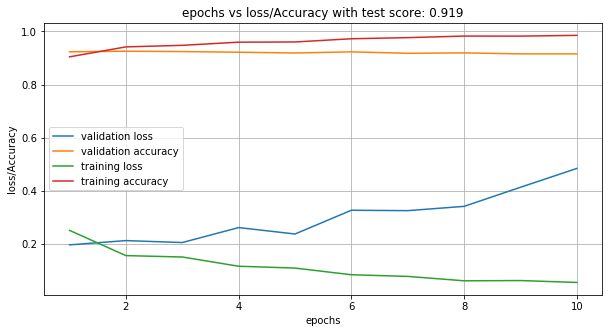

In [44]:
plt.figure(figsize=(10,5))
plt.grid()
plt.plot(range(1,11),history2.history['val_loss'],label="validation loss")
plt.plot(range(1,11),history2.history['val_accuracy'],label="validation accuracy")
plt.plot(range(1,11),history2.history['loss'],label="training loss")
plt.plot(range(1,11),history2.history['accuracy'],label="training accuracy")
plt.legend()
plt.ylabel("loss/Accuracy")
plt.xlabel("epochs")
plt.title("epochs vs loss/Accuracy with test score: "+str(np.round(scores2[1],3)))
plt.show()

In [45]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names =["model","training accuracy","validation accuracy","test accuracy"]
table.add_row(["model (1 LSTM)",
              np.round(max(history1.history["accuracy"]),3),
              np.round(max(history1.history["val_accuracy"]),3),
              np.round(scores1[1],3)])
table.add_row(["model (2 LSTM)\n with tanh activation",
              np.round(max(history2.history["accuracy"]),3),
              np.round(max(history2.history["val_accuracy"]),3),
              np.round(scores2[1],3)])

# [5] Conclusions

In [46]:
print(table)

+-----------------------+-------------------+---------------------+---------------+
|         model         | training accuracy | validation accuracy | test accuracy |
+-----------------------+-------------------+---------------------+---------------+
|     model (1 LSTM)    |       0.996       |        0.931        |     0.926     |
|     model (2 LSTM)    |       0.985       |        0.926        |     0.919     |
|  with tanh activation |                   |                     |               |
+-----------------------+-------------------+---------------------+---------------+
